# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [1.0, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

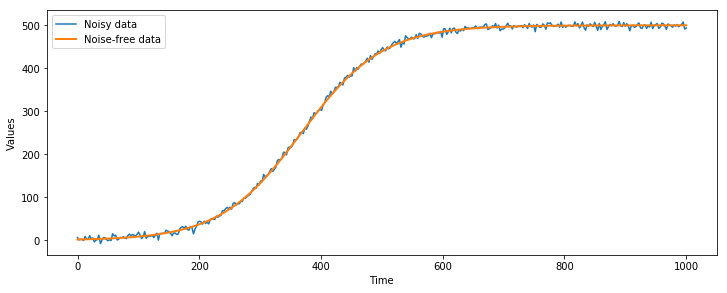

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([-1.0, -1.0], [2.0, 2.0])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.89263544 0.91743688]
-17740.5064155649
accepted


[1.03551929 0.86917941]
-48676.65137283477
accepted


[1.33437622 1.19375327]
-291709.1828568155


1     6      0.5       0.5       0          0:00.0
[0.7955439  0.90548814]
-9411.312561316072
accepted


[1.01261786 1.0080125 ]
-54152.31692627469


[1.15188767 1.41247287]
-457780.6882255305


2     9      0.667     0.333     0          0:00.0
[0.91479754 0.82114777]
-37726.294484310005


[1.11595741 0.73894855]
-92320.66172813895


[1.25180531 1.38742431]
-489166.4775905876


3     12     0.5       0.25      0          0:00.0
[0.77328839 0.86217766]
-19161.17238739868


[1.22722075 0.95804645]
-103423.96886294553


[1.13128527 1.0799051 ]
-122646.70664424919
accepted


[0.76372158 0.85820581]
-20813.13983799039


[1.0481773  1.06009387]
-8

-31196.64527950717


[0.6307082  0.88840934]
-45457.06015572929


[0.71511018 1.1957147 ]
-34377.31946142977


[0.80803475 1.29489994]
-111622.47427457031


[0.82319228 0.95104359]
-6337.095019845009


[0.72739826 0.77153984]
-59007.18960773753


[0.65210079 1.14027793]
-22839.848599133235


[0.76288347 1.12475774]
-18619.146511748426


[0.77523665 1.10969172]
-16649.500610274034


[0.81887451 1.02308409]
-8031.019859002753


[0.56557981 1.04374205]
-59193.454649133695


[0.69320652 1.00784976]
-5674.981293657252


[0.63414419 0.96028507]
-27845.766981845423


[0.7871898  0.95818511]
-3234.588430332316


[0.9118517  0.83611688]
-33391.27039548933


[0.81096426 1.0396289 ]
-8807.220896308458


[0.85650459 1.14035393]
-47026.719783736364


[0.80856897 0.96538585]
-4398.757828636991


[0.56659162 0.9701344 ]
-67583.59749508112


[0.82377054 0.88126129]
-14978.30379827522


[0.90390457 1.01851844]
-25392.89436358659


[0.86681035 1.10376553]
-36802.91244598497


[0.65347689 0.93724823]
-24

[0.65235852 0.85790222]
-45296.336986799135


[0.80510998 0.92401187]
-7146.82305357332


[0.72027983 1.01072251]
-2355.763256545682


[0.5696792  0.84444061]
-99687.88818032887


[0.98170306 0.89843763]
-35628.440621872774


[0.68610634 0.98075098]
-8625.34278958677


[0.71983842 0.88985531]
-17312.911715244674


[0.91940529 1.09583252]
-51063.172117701506


[0.74687946 1.03508001]
-2376.784560727305


[0.77643508 1.07839801]
-10042.614748403437


[0.70037653 0.91599645]
-15014.078175463734


[0.84907381 1.08005261]
-24793.070168277853


[0.51322093 1.17211151]
-104680.25536469596


[0.69962486 1.00389487]
-4791.937683595748


140   423    0.0355    0.0496    0.0851     0:00.4
[0.8021063 0.9695383]
-3738.0886469956063


[0.6835623  1.01893286]
-7137.053170347865


[0.79439884 1.17637178]
-42667.75846650748


[0.78768926 0.99784699]
-2640.9891297433337


[0.60426705 0.86893768]
-66135.93962469122


[0.98581129 0.93851802]
-36575.3511533881


[0.63812563 1.06412521]
-19316.223814064666


[0.7539329  1.00020367]
-1208.2289743800002
accepted


[0.76258422 0.99977629]
-1344.162588290681


[0.77617839 1.01238919]
-2339.647135988609


[0.75490212 1.00681694]
-1287.2389765354578


[0.7424405  0.98375678]
-1681.632879608032


[0.71650462 0.97621853]
-4056.836562150262


[0.75505693 1.00738252]
-1299.796895388132


[0.77207534 1.01180807]
-2056.9659928567494


[0.75148833 0.98506567]
-1415.6341213802461


[0.76571405 0.98744647]
-1444.034497522191


[0.74940998 1.0073787 ]
-1257.086405175954


[0.75737468 0.98932607]
-1296.897271252316
accepted


[0.75726304 1.00447449]
-1285.803031195353


[0.76447031 0.99513172]
-1367.8182796596382


[0.76029708 0.99688898]
-1276.8378561743764
accepted


[0.7580115  0.98213927]
-1466.6900344888854


[0.74655293 0.99315912]
-1303.0002906710306


[0.75509628 0.98903575]
-1296.4865446357041


[0.75306822 1.00415341]
-1230.505347873146


[0.74961576 1.00431333]
-1222.6531384701732


[0.74296861 0.9849946 ]
-1615.9816165739153


[0.75619805 0.995

[0.75100592 1.00018225]
-1201.8493277388002
accepted


[0.7518435  0.99888054]
-1201.1632775586588


[0.75106895 0.99890332]
-1202.2287183295748
accepted


[0.75044471 1.0010069 ]
-1204.1166382660115
accepted


[0.75177199 0.99923404]
-1200.9272069500464
accepted


[0.7506036  0.99857961]
-1204.3741230876312


[0.75067373 1.00063415]
-1202.9638032107212
accepted


[0.75280711 0.99924193]
-1201.8969363314602


[0.75199802 0.99887792]
-1201.1239622387754
accepted


[0.75136675 1.00071981]
-1202.4115375380693
accepted


[0.75257366 0.99918283]
-1201.4342845854048
accepted


[0.7526186  0.99936852]
-1201.5759774773696


[0.75114704 1.00051092]
-1202.1063508507866
accepted


[0.75359257 0.99951933]
-1204.7841347791434


[0.75209552 0.99938389]
-1200.9442541239891
accepted


[0.752003   0.99997913]
-1201.3102814709746
accepted


[0.7515012 0.9990154]
-1201.3018836610972
accepted


[0.75174701 0.99977134]
-1200.9960701668501
accepted


[0.75087525 0.9995358 ]
-1201.9854354435909
accepted


[0

accepted


[0.75148362 0.99909141]
-1201.245549845164
accepted


[0.75164089 1.00010077]
-1201.3061621450604
accepted


[0.75280701 0.99768956]
-1203.6644743646814


[0.75172135 0.99862308]
-1201.6104102527759


[0.75196842 0.99959504]
-1200.947085038622
accepted


[0.75027686 0.99990609]
-1203.5883238003796


[0.74991265 1.00002986]
-1204.983845921358


[0.75192649 1.00057427]
-1202.3486963348248


[0.75375476 1.00014784]
-1207.0621569387795


[0.75179633 0.99905991]
-1201.019734885103
accepted


[0.75286243 0.99837277]
-1202.3660477973524
accepted


[0.75190643 0.99875838]
-1201.2801944585553


[0.74989987 0.99981123]
-1205.1611345009146


[0.75247225 0.99869615]
-1201.5015827029804
accepted


[0.75191856 1.00110018]
-1203.9066076780844


[0.75361002 0.99741856]
-1205.8533113961555


[0.75225135 0.99903265]
-1201.0910600418954
accepted


[0.75235099 1.00034821]
-1202.475002978025


340   1023   0.196     0.211     0.208      0:00.9
[0.75288486 0.99722902]
-1205.1892578705688


[0.751

-1201.588200783261
accepted


[0.75360618 0.99801294]
-1204.6432824193673


[0.75109972 1.0015936 ]
-1205.1184165704697


[0.75237415 0.99862836]
-1201.4949276758923
accepted


[0.7518683  0.99967202]
-1200.9527182652703
accepted


[0.75359734 0.99787009]
-1204.8385887945956


[0.75330158 1.00017193]
-1204.9784893863923


400   1203   0.229     0.232     0.242      0:01.1
[0.74913072 1.00152579]
-1209.981184758365


[0.75468666 0.99960957]
-1211.28717755874


[0.75175113 1.00083722]
-1202.86364664828
accepted


[0.74943731 1.00105947]
-1207.676209916641


[0.75011216 1.00114116]
-1205.2513909643635


[0.75170787 1.00354161]
-1217.8830572264915


[0.75191635 1.00081797]
-1202.9926444480882


[0.75236874 1.00010426]
-1201.9981772926876
accepted


[0.75122285 1.00354304]
-1216.7058752931925


[0.75121995 1.00227268]
-1208.2781357934007


[0.75259328 1.00094534]
-1204.9126883961449


[0.75235673 1.00093546]
-1204.2141814155518


[0.75463492 0.99764088]
-1209.5607480918825


[0.75281207 1.0



[0.74833236 1.00532569]
-1234.937533737464


[0.75208234 0.99864187]
-1201.3932011261275
accepted


[0.75341214 1.00146688]
-1210.86814815917


[0.7513194  1.00010599]
-1201.4275640955577
accepted


[0.7547694  0.99944844]
-1211.4582432726618


[0.75298665 1.00235091]
-1214.0824538956545


[0.75024581 1.00205274]
-1207.7529361842192


[0.75161098 0.99967415]
-1200.9713293689015
accepted


[0.75167006 0.99993314]
-1201.1242761494461
accepted


[0.75403701 1.00078039]
-1211.1650203153765


[0.7526446  1.00202237]
-1210.3542217573788


[0.75210294 0.99691657]
-1206.7769918373854


[0.75101915 0.99883726]
-1202.467463367993
accepted


[0.75228026 0.99987772]
-1201.4937925321356
accepted


[0.75371553 0.9978534 ]
-1205.2420262296453
accepted


[0.74952631 0.99927175]
-1207.9195035628966


[0.75134497 1.00067857]
-1202.3233306004472


[0.75273638 0.99326343]
-1235.9857600243731


[0.75059104 0.99925831]
-1203.042938761787
accepted


[0.75256004 0.9993376 ]
-1201.4567087431408
accepted


[0

[0.7520383 1.0001553]
-1201.6063985125847
accepted


[0.74814413 1.00093582]
-1215.8267094547607


[0.74927063 1.00236401]
-1211.8533868846575


[0.75145097 1.00173176]
-1205.836378019692


[0.75130217 1.00250066]
-1209.6355979047316


[0.75124688 1.00092306]
-1202.9316743314016


[0.75182631 0.99903931]
-1201.0233583073189
accepted


[0.7519543  1.00200368]
-1208.0017875486087


[0.74931687 1.00134284]
-1208.7051214733765


[0.75076325 0.99855658]
-1203.8595237178467


[0.75083926 1.00197076]
-1206.7381764203772


[0.7482703  1.00145656]
-1215.194954582994


[0.7503448 0.9993855]
-1203.7453027638521


[0.75054909 1.00166273]
-1205.778974894512
accepted


[0.75447626 1.00095386]
-1215.1576401429309


[0.75220638 0.9988882 ]
-1201.1528572727232
accepted


[0.75040078 1.00091236]
-1204.0288509568404
accepted


[0.74817924 1.0036269 ]
-1223.1718998243527


[0.75196259 1.00048801]
-1202.1852620658285


[0.75179797 0.99937913]
-1200.882926992016
accepted


[0.75203411 0.99823501]
-1202.1435

-1206.4782973748445


[0.74882109 0.99970353]
-1211.7274241196953


[0.75631026 0.99540522]
-1227.0311974693573


[0.7505557  0.99882382]
-1203.9473645117996


[0.7513502  0.99778732]
-1204.5405202662666


[0.75233424 0.99769093]
-1203.4895461855172


[0.75256076 1.00027401]
-1202.769307526477
accepted


[0.75227804 0.99861548]
-1201.460457402955


[0.7537241  0.99513055]
-1217.3312386872549


[0.75210455 0.9998262 ]
-1201.221151222894
accepted


[0.74891761 1.00088957]
-1210.3198802954028


600   1803   0.241     0.236     0.249584   0:01.7
[0.75034781 0.99786673]
-1208.0309434467379


[0.75196285 0.9985142 ]
-1201.6233645297925


[0.75197867 1.00091444]
-1203.3772946955085


[0.75116902 0.99837845]
-1203.1195009741866


[0.75346519 0.99977751]
-1204.7166465295784
accepted


[0.75229256 0.99703662]
-1205.9974725545428


[0.75192277 1.00137579]
-1204.9609851077057


[0.75382407 1.00064675]
-1209.2583608286684


[0.75043873 1.00425695]
-1221.7404962202102


[0.74975262 1.00241869]
-1210

[0.75176401 1.00505288]
-1233.0488055315707


[0.7543153  1.00184028]
-1219.3589651184293


[0.75248553 1.00110375]
-1205.2001758965298
accepted


[0.75146101 1.00031037]
-1201.614322649664
accepted


[0.7539867  0.99593556]
-1212.7316492394962


[0.75052743 1.0005255 ]
-1203.1316672372536
accepted


[0.75100731 0.9981473 ]
-1204.2652875106264


[0.75114164 0.99677595]
-1210.1148129769954


[0.75364696 0.9987528 ]
-1204.317459635386


[0.74948273 1.00256242]
-1211.9051079352066


[0.75295314 0.99685157]
-1206.7328508782637


[0.7507806  1.00115246]
-1203.8879473961106
accepted


[0.75209962 1.00178335]
-1207.2102455943998


[0.75325881 0.99769154]
-1204.3382860403758


[0.75225339 1.00187607]
-1208.1244790464075


[0.74850056 1.00065639]
-1213.0934943065122


[0.7513695  1.00248704]
-1209.6401982110328


[0.74891131 1.00185273]
-1211.8860457161009


[0.75010914 1.00204766]
-1208.0069219121806


[0.75056203 1.00213164]
-1207.6471164463333


[0.74846293 0.99981053]
-1214.303873088643


[

[0.75116426 1.00048104]
-1202.0424433851003


[0.74983395 1.00045875]
-1205.354514960721


[0.74991003 0.99975271]
-1205.1636200991268


[0.75193276 0.99660533]
-1208.7189075377873


[0.75514774 0.99887845]
-1213.0951382206654


[0.75182771 0.99791628]
-1203.1770089136721


[0.75134214 1.00119604]
-1203.7250974597932


[0.75254468 0.99681383]
-1206.8630042345362


[0.75135979 0.99903031]
-1201.4790603384251
accepted


[0.75016841 1.00295009]
-1212.3250298125408


[0.75191477 0.99876592]
-1201.2673442174857
accepted


[0.75339872 0.99987764]
-1204.6512688068713


[0.75176233 0.99947384]
-1200.8873109036535
accepted


[0.75313311 0.99903403]
-1202.6467689750932


[0.75226408 0.99717049]
-1205.43783638789


[0.75261808 1.0008133 ]
-1204.5091748844545


[0.75171226 0.99992291]
-1201.1156021709985
accepted


[0.75387971 0.99898106]
-1205.4172734207289


[0.74987487 1.00177261]
-1207.6296345253631


[0.75247736 1.00191605]
-1209.0884791147225


[0.74763401 1.00009113]
-1221.29316928495


[0.

[0.75083433 0.99912365]
-1202.4925222271527


[0.7580688  0.99808939]
-1243.2379811530823


[0.75394224 0.99836412]
-1205.5779203912216


[0.74680227 1.00217277]
-1229.207324025707


[0.75302758 0.99859779]
-1202.4644225487496
accepted


[0.75115806 1.00202589]
-1206.9929856155845


[0.75070788 0.99820874]
-1205.1069874039226


[0.75328524 0.99494911]
-1218.4893311777787


[0.75111601 1.0013479 ]
-1204.2305027552288
accepted


[0.7526615  0.99857079]
-1201.8392128933297


800   2403   0.238     0.235     0.25       0:02.3
[0.75460872 0.99885297]
-1209.2915769530528


[0.75148714 1.00115011]
-1203.628125901038
accepted


[0.75075864 1.00036848]
-1202.4536842971659


[0.74823161 1.00443419]
-1228.070094271191


[0.75005201 1.00301207]
-1212.851695045131


[0.75341057 0.99834938]
-1203.6564322595464


[0.75165319 1.00039913]
-1201.7723448120182
accepted


[0.75202361 0.99802328]
-1202.6721496086611
accepted


[0.75037623 1.00030261]
-1203.3337594642533


[0.7501108  1.00017702]
-1204.1718

accepted


[0.74927206 1.0048374 ]
-1227.7394758287494


[0.74997103 0.99957401]
-1205.071945456767
accepted


[0.75148296 1.00030249]
-1201.5976343375662
accepted


[0.75310574 0.99480964]
-1219.6986269471079


[0.75059217 0.99790685]
-1206.7122241974862


[0.75206262 0.99891494]
-1201.0917110173411
accepted


[0.75023194 1.00152152]
-1205.9063278970784


[0.7527224  0.99596423]
-1211.4651961620925


[0.75388728 0.99776754]
-1205.9843828767694
accepted


[0.75329432 0.9979762 ]
-1203.8344636662987


[0.74994425 0.99882287]
-1206.6918814633518
accepted


[0.75261557 0.99946958]
-1201.636496989288
accepted


[0.74773385 1.0056817 ]
-1240.9646590401978


[0.75563279 0.9990018 ]
-1217.3620777907067


[0.75427209 0.99866211]
-1207.1748439678847


[0.74952891 1.0039649 ]
-1220.1013154409425


[0.74894887 0.99871364]
-1213.5682104119683


[0.75303528 0.99705298]
-1205.976311347713


[0.75481149 0.9931307 ]
-1236.7545379962457


[0.75248375 0.99723632]
-1205.0544623043809
accepted


[0.752617


[0.75076843 0.99943172]
-1202.325396132261
accepted


[0.75216543 1.00064874]
-1202.894275033571


[0.75027086 1.00015049]
-1203.6019050670375


[0.75244422 0.99516087]
-1217.6753170790603


[0.75247707 0.99695305]
-1206.2500113025412


[0.75049113 0.99861004]
-1204.7327399974477


[0.75011586 1.00147504]
-1206.0591517055898


[0.75252516 1.00002051]
-1202.1586133679878


[0.74977733 0.99984493]
-1205.7092396867579


[0.7463681  1.00163481]
-1233.6841794172103


[0.75344262 1.00015894]
-1205.5589903737775


[0.75262679 0.99953557]
-1201.7134168602051


[0.75033018 1.00069267]
-1203.8527620233006
accepted


940   2823   0.233     0.233     0.250797   0:02.6
[0.75147287 0.99888895]
-1201.4937373275184
accepted


[0.75419692 0.99828013]
-1206.774457093793


[0.75349309 1.00041685]
-1206.6054067407977


[0.75110363 0.99812855]
-1204.034054990336


[0.74990407 0.99930863]
-1205.7894963845774


[0.75173168 0.99987683]
-1201.0755045322103
accepted


[0.75091807 0.99664036]
-1211.907571937489


[0.75183405 1.00027413]
-1201.6341285171363
accepted


[0.75205293 0.99968007]
-1201.0469804151053
accepted


[0.7498379  1.00252409]
-1210.699283684975


[0.75228066 0.99961483]
-1201.2188820081979
accepted


[0.75463571 1.00056928]
-1214.471618276042


[0.74949064 1.00251788]
-1211.6808155800802


[0.75157584 0.99973974]
-1201.0118639770649
accepted


[0.7502341  1.00068619]
-1204.119819528939


[0.75231808 0.99769291]
-1203.4872772902793
accepted


[0.75000027 1.00079614]
-1205.0200247127927


[0.7531239  0.99935768]
-1202.8200290637376


[0.75042933 0.99771175]
-1208.3226482445289


[0.75053875 0.99908945]
-1203.4800270878359
accepted


[0.75117281 1.00045063]
-1201.986579785182


[0.75379115 0.99830488]
-1204.9931600039192


[0.75115133 0.99800722]
-1204.2992479334503


[0.75496828 1.00057004]
-1217.2063847503541


[0.75271096 0.99822094]
-1202.3829659107687
accepted


[0.75102201 0.99867895]
-1202.7778599107212
accepted


[0.75052437 0.99699103]
-1211.674371951116


[0.75122879 

-1201.9535579797716


[0.75026883 1.00556549]
-1234.6822105037159


[0.74953379 1.00059127]
-1206.7734965108307


[0.75423133 0.99697309]
-1209.1490888930098


[0.75289075 1.00000226]
-1203.077103879428


[0.75353249 1.00318908]
-1224.237797490768


[0.75303197 0.99867442]
-1202.4278732571208


[0.75567509 0.99982103]
-1220.3323088537281


[0.75232733 0.99806086]
-1202.477826900863


[0.75293288 0.99849714]
-1202.3512509165391


[0.75469393 0.99526206]
-1218.730198098868


[0.75315302 0.99834993]
-1202.9717398257912


[0.75014003 1.00129763]
-1205.5293326036358


[0.75305782 0.99974644]
-1203.1226389767476
accepted


[0.75410726 0.99978362]
-1207.9888987764712


[0.75002769 1.0003399 ]
-1204.528586696938


[0.7492597  1.00169117]
-1209.7372957347288


[0.75287622 1.00034023]
-1203.8468865687432


[0.7506417  0.99937436]
-1202.7434978776569


[0.75181121 1.00102592]
-1203.5052695224235
accepted


[0.75244189 0.99892926]
-1201.3041669453755
accepted


[0.75024811 0.99808954]
-1207.600958

[0.7541597  1.00214857]
-1220.3526138987972


[0.74820261 0.99961082]
-1216.9935399540236


[0.75302897 1.00008298]
-1203.706001097495


[0.75344696 0.9989288 ]
-1203.6168323487466


[0.75075528 0.99851953]
-1203.985966007384


[0.75253917 1.00066191]
-1203.778402844902


[0.75035024 0.99994079]
-1203.3299860573643


[0.74943537 1.00291709]
-1213.7705648415783


[0.74979428 1.00236836]
-1210.1076045013654


[0.75215251 0.99960926]
-1201.0784474839268
accepted


[0.75161831 0.99985468]
-1201.0659345256308
accepted


[0.75268243 0.9990153 ]
-1201.6131805060074
accepted


[0.74964695 0.99949706]
-1206.8034056155288


[0.75162662 1.00023682]
-1201.4926004571905
accepted


[0.75591082 0.99603949]
-1221.5010318563936


[0.75205637 0.99869126]
-1201.3293614355014


[0.74927512 1.00037669]
-1208.0904247794256


[0.7533732  1.00010306]
-1205.0967022544908


[0.75507821 0.99756844]
-1212.2650053004481


[0.75178395 1.00318285]
-1215.2430922844305


[0.75283704 0.99644246]
-1208.6564117114751


[

[0.75204874 1.00121597]
-1204.5631957630703


[0.7523509  0.99773554]
-1203.3500232124668


[0.75064839 1.00176858]
-1206.046766672168


[0.75274067 0.99925099]
-1201.7585434739733


[0.75070418 0.9990599 ]
-1202.9760935418044


[0.74879893 1.00129   ]
-1211.4347515224533


[0.75240095 0.9982134 ]
-1202.1621056689892


[0.75074296 1.00152475]
-1205.0651007619108


[0.75262183 1.00040535]
-1203.258282497512


[0.75017105 0.99912846]
-1204.874397951621


[0.75252278 0.99786058]
-1203.0193201247546


[0.75011342 0.99881442]
-1205.8615671141424


[0.75263832 0.99786922]
-1203.058414457538


[0.75675908 1.00014707]
-1233.9951374258055


[0.75274691 0.99852964]
-1202.001779823408


[0.75211452 0.99994701]
-1201.3755991013122
accepted


[0.7496203  0.99836268]
-1210.13270910382


[0.75229539 0.99878199]
-1201.287503439007
accepted


[0.7497258  0.99866979]
-1208.3726263085066


1200  3603   0.231     0.233     0.237      0:03.4
[0.75256184 1.00103181]
-1205.1468680728985


[0.7470694  1.00375

[0.75222016 1.00284806]
-1214.192809030412


[0.75692703 0.99633695]
-1229.320296646917


[0.75529399 1.00057799]
-1220.1841614036293


[0.75272633 1.00075732]
-1204.6555696638202


[0.75466617 1.00013915]
-1212.8774159276056


[0.75316774 0.99774013]
-1204.0453695152564


[0.753291   0.99820211]
-1203.484944848537
accepted


[0.75368298 1.00016002]
-1206.725061886268


[0.75224501 1.00121945]
-1205.0120757793982


[0.75270584 0.99864287]
-1201.8324072762603
accepted


[0.75064266 0.99777597]
-1207.0426606915557


[0.75253217 0.99863563]
-1201.6203799020116
accepted


[0.75565139 0.99732449]
-1216.556713181476


[0.7519198  0.99812962]
-1202.4769686843035


[0.75223496 0.99944204]
-1201.0678710613188
accepted


[0.75467319 0.99650964]
-1212.5476038689849


[0.75431402 0.99958976]
-1208.7491309714192


[0.7538093  0.99992031]
-1206.695578031268


[0.75283546 0.99803525]
-1202.8799124075008


[0.75241349 0.99876641]
-1201.385835469893
accepted


[0.75549736 0.99857496]
-1215.432732701092

[0.75249727 0.99718686]
-1205.2474937759032


[0.7509898  0.99937663]
-1201.8310572365715
accepted


[0.75097224 0.9998995 ]
-1201.738733668586
accepted


[0.75403258 0.99915145]
-1206.343203485057


[0.74868968 0.99509178]
-1243.5743725681946


[0.7532599  0.99704106]
-1206.3036963197987


[0.75506002 0.99883018]
-1212.359815414341


[0.75279208 0.99964944]
-1202.2119874803063


[0.75509829 0.99779508]
-1212.198624941458


[0.75442123 1.00097798]
-1214.8639428812407


[0.75175732 0.99936749]
-1200.8934027626017
accepted


[0.75029445 1.00003923]
-1203.5099853261756


[0.7519691  1.00246357]
-1210.739114694501


[0.75542359 0.99918294]
-1215.9616988826544


[0.74962483 0.99895108]
-1208.127012461614


[0.75263509 1.00145698]
-1207.252452291762


[0.75298031 0.99992109]
-1203.192778747061


[0.75277993 0.99748089]
-1204.2581082617035


[0.7520198  1.00009873]
-1201.4958724346106
accepted


[0.75507096 1.00192492]
-1226.813775108273


[0.75384202 0.99900417]
-1205.2622385885347


[0.7544

-1203.0178177720518


[0.75004692 1.0017233 ]
-1206.9888411010247


[0.75411389 0.99759915]
-1207.1588531265081


[0.74829446 0.99735321]
-1227.0250057403427


[0.7527992  0.99938865]
-1201.9665243672807
accepted


[0.74854706 0.99937331]
-1214.6468294800159


[0.74918149 0.99501308]
-1239.1177402620274


[0.75326709 0.99986636]
-1204.0955589380671


[0.75074426 1.00380722]
-1218.1685747876759


[0.75382003 0.99835285]
-1205.0778399230996


[0.75288167 0.99806374]
-1202.8875913090455


[0.74969453 0.9994703 ]
-1206.5904001411823


[0.75105875 1.00024757]
-1201.8400498868862
accepted


[0.7527982  0.99724171]
-1205.0862129337731


[0.75164307 0.99874579]
-1201.492375745641
accepted


[0.75155654 0.99688827]
-1208.079523695637


1400  4203   0.227     0.234     0.239      0:03.9
[0.75302747 1.00175647]
-1210.5028961633354


[0.75012751 0.99989936]
-1204.14584921352
accepted


[0.75206481 1.00080798]
-1203.1846707423642


[0.75237047 0.99834138]
-1201.9110144319543
accepted


[0.7512389  

-1202.8940781134684
accepted


[0.75337369 0.99860233]
-1203.383413854469


[0.75433149 0.99863216]
-1207.4819305879805


[0.74943391 1.00287789]
-1213.57421146733


[0.75120537 1.00007562]
-1201.5038432389217


[0.75361462 0.99893288]
-1204.246633968748


[0.75376066 1.00344488]
-1228.4122483628344


[0.75030111 1.00113827]
-1204.737419094548


[0.75532938 0.99357054]
-1233.9812685840307


[0.75166754 0.99805169]
-1203.0017233559504
accepted


[0.7541623  0.99763792]
-1207.2910705232155


[0.75409351 0.99864807]
-1206.2553505385997
accepted


[0.75261029 0.99644946]
-1208.6821864756694


[0.75172889 0.9981138 ]
-1202.7351426405726


[0.75536626 0.99722783]
-1214.629990924801


[0.75151737 0.99729923]
-1206.1358532521022


[0.753378   0.99886792]
-1203.3654524062404


[0.75279928 0.99390084]
-1228.7087765415567


[0.7508182 0.9973806]
-1208.1280146160348


[0.75079107 0.99935322]
-1202.3359074751895


[0.75303821 1.00108941]
-1207.1509446654904
accepted


[0.74934883 0.99995229]
-1207.

[0.75120851 1.00020798]
-1201.6292581323532
accepted


[0.75252859 0.99667585]
-1207.544625709317


[0.75256912 1.00135798]
-1206.5551226121527


[0.75095646 0.99927135]
-1202.000371662899
accepted


[0.75449988 1.00109826]
-1216.135394302353


[0.75252286 1.0032387 ]
-1218.5625273278163


[0.749171   1.00028687]
-1208.721801884268


[0.7538158  0.99834733]
-1205.0640364134265


[0.75340374 1.00321966]
-1223.5982516791576


[0.75123283 0.99919803]
-1201.5093727047858
accepted


[0.75482873 0.99991816]
-1213.308865982229


[0.75330359 0.99929916]
-1203.3556606661575
accepted


[0.75151523 1.00120357]
-1203.8223086461426


[0.75396941 0.9978416 ]
-1206.179782080131


[0.7529788  0.99754612]
-1204.2552477431348
accepted


[0.74879258 0.99844997]
-1215.9314154577692


[0.75285208 1.0001523 ]
-1203.2903874509748


[0.75099741 1.00102659]
-1203.3339859483851
accepted


[0.75309887 1.00185365]
-1211.4316175061763


[0.75005663 0.99953967]
-1204.73028426894


[0.75059032 1.00021438]
-1202.6972


[0.75268908 0.99934675]
-1201.7002901396636
accepted


[0.75265502 1.00029515]
-1203.0643439943294


[0.74804441 1.0011501 ]
-1216.6867336468722


[0.75142021 1.00024685]
-1201.5354169412456
accepted


[0.7539839  0.99887855]
-1205.8345874354777


[0.75414727 1.00110057]
-1213.5100732776157


[0.74721608 0.99954159]
-1227.3509259781363


[0.7535217 1.003197 ]
-1224.231728241561


[0.75113359 0.99763839]
-1205.7621885630897


[0.75159826 0.99872259]
-1201.5795904353379
accepted


[0.75418661 0.99883898]
-1206.8294211953778


[0.75417377 0.99964343]
-1208.028042652948


[0.75094507 0.99967098]
-1201.782061463497
accepted


1600  4803   0.233     0.235     0.242      0:04.5
[0.75279657 1.00253306]
-1214.4049228097037


[0.75149248 0.99930314]
-1201.0820768546669
accepted


[0.75552853 1.00020104]
-1220.5571888885465


[0.7520106  0.99797619]
-1202.811020782268
accepted


[0.75093808 0.99555481]
-1219.9689423694558


[0.75266986 1.00017557]
-1202.8215678235492


[0.75356389 0.99564611]
-1

[0.75409981 0.99718984]
-1208.0314929474607


[0.75160542 0.99586001]
-1214.527219881663


[0.75084988 1.00082562]
-1203.0214756962173


[0.75273798 1.00158071]
-1208.263298391396


[0.75374438 1.00230054]
-1218.375944307891


[0.74689398 1.0036018 ]
-1232.550371191006


[0.75647547 0.99555369]
-1227.6917895715846


[0.75053388 0.99969737]
-1202.82227021903


[0.75679167 0.99743414]
-1226.789792230121


[0.75353492 0.99951827]
-1204.5338278627694
accepted


[0.75211398 1.00150492]
-1205.9137087821653


[0.74983291 0.99792984]
-1210.6506990578166


[0.75395443 0.99606113]
-1211.995605310573


[0.75046527 1.00070816]
-1203.5279373976196


[0.75441078 0.99870137]
-1207.9638590964287


[0.7554731  0.99693007]
-1215.9077004611324


[0.7508477  1.00021272]
-1202.1382279069658


[0.75123031 1.00026794]
-1201.6803261973942
accepted


[0.75385814 0.99838515]
-1205.216068593018


[0.74897281 0.99832069]
-1215.0228100461736


[0.75424694 1.00023918]
-1210.2954533440347


[0.75088687 0.99715588]
-

[0.75257103 0.99963888]
-1201.7041848203062
accepted


[0.75200846 0.99806078]
-1202.5835496866634


[0.74916178 1.00207403]
-1211.286372928237


[0.7538069  1.00167556]
-1214.511527775245


[0.74971186 1.00058973]
-1205.9522262769055


[0.75223251 0.99770023]
-1203.4953562717174


[0.75262748 0.99836746]
-1202.0562276179767
accepted


[0.75250544 1.00197675]
-1209.5388943923208


[0.7535016  0.99815854]
-1204.128403217707
accepted


[0.75317352 0.99514335]
-1216.9945678814056


[0.7525075  1.00109588]
-1205.234347741826


[0.7540438  0.99798273]
-1206.3013726267004


[0.75525737 0.994974  ]
-1222.8651686157386


[0.75418349 1.00144435]
-1215.7416760859621


[0.75555767 0.99773381]
-1215.527664521148


[0.74834797 1.00207543]
-1215.825914827098


[0.75041524 0.99839114]
-1205.711024993208


[0.75442791 0.99708389]
-1209.6494106102627


[0.75507301 1.00112959]
-1221.264019409863


[0.75036465 0.99892361]
-1204.4729139157675


[0.75323679 0.9980755 ]
-1203.5341160529194
accepted


[0.754

[0.75583228 0.99797191]
-1217.7587692812508


[0.75154242 1.00267925]
-1211.1067591695255


[0.75323722 0.99758022]
-1204.570963305328


[0.74888037 1.0052699 ]
-1232.6232608406265


[0.7517724  0.99765676]
-1204.1286572880026


[0.75128362 1.00204772]
-1207.1732217723616


[0.75576933 0.99557908]
-1222.4236946906847


[0.75344751 1.00192976]
-1213.8460004681363


[0.75298249 0.99866083]
-1202.3245934206436


[0.75439757 0.99740438]
-1208.7675565181848


[0.75343425 0.99918045]
-1203.7186636176684
accepted


[0.75185365 1.00008399]
-1201.3470286467975
accepted


[0.75176838 0.99619883]
-1211.6231423938323


[0.75385072 1.00041281]
-1208.492600160288


[0.7539491  0.99801553]
-1205.8742434337128
accepted


[0.75210039 1.00063662]
-1202.7497928876205
accepted


[0.75504121 0.99993134]
-1215.056867114421


[0.75471678 0.99747637]
-1210.2452773536515


[0.75375845 1.00012919]
-1207.024517789385


[0.75525994 0.99993027]
-1216.9193675555737


[0.75362888 0.99881795]
-1204.2600972461846
acce



[0.75066129 0.99865177]
-1203.9720088897311
accepted


1860  5583   0.226     0.237     0.234      0:05.2
[0.75255976 0.99770828]
-1203.4518523128838
accepted


[0.75525537 0.99863002]
-1213.5691444315225


[0.74892473 1.00067355]
-1210.1907006473934


[0.75203316 0.995318  ]
-1217.397354973806


[0.75288962 0.99850309]
-1202.2646356690195


[0.75147362 0.99675394]
-1209.0724196214044


[0.75078912 0.99969453]
-1202.124695928687
accepted


[0.75092588 0.9991377 ]
-1202.2302611244725


[0.74957806 0.99874792]
-1209.0184564035135


[0.75020377 0.99885083]
-1205.3430794904018


[0.74920941 1.00167892]
-1209.942235831992


[0.74897928 0.99696945]
-1223.010643645951


[0.75034941 0.99668646]
-1214.6119800863405


[0.7523535  0.99876831]
-1201.337218127198
accepted


[0.74855413 0.99933689]
-1214.6905627176798


[0.74921623 1.00234754]
-1212.0130305728887


[0.75149765 0.99915574]
-1201.1732649683984
accepted


[0.7522748  0.99871091]
-1201.347342933245
accepted


[0.75016538 1.00120937]
-

[0.7534055  1.00203614]
-1214.2924268586778


[0.75361115 0.99978962]
-1205.3948778538524


[0.75147263 0.99941743]
-1201.055738078446
accepted


[0.75071029 0.99655158]
-1213.5099989986043


[0.75295453 1.00207486]
-1212.079951886099


[0.75333025 0.99887096]
-1203.2101263256427


[0.75549396 0.99479194]
-1225.195074403207


[0.75226001 1.00077814]
-1203.464205286086
accepted


[0.74711355 1.00088457]
-1225.5282172419807


[0.75070261 1.00008852]
-1202.361146448834


[0.75642792 1.00089471]
-1234.4840028689928


[0.75089198 0.99907141]
-1202.410845848135


[0.74829735 1.0021046 ]
-1216.2376174400606


[0.75262534 0.99875363]
-1201.6315210204928
accepted


[0.74717769 0.99910533]
-1229.5449036128523


[0.75600318 0.99451541]
-1229.8850961241158


[0.75425477 0.99711231]
-1208.8411288234652


[0.75173098 0.99984873]
-1201.0520380228268
accepted


[0.7557491  0.99753155]
-1217.1353338459169


[0.75253831 0.99824124]
-1202.1850106830177
accepted


[0.75228745 0.99767694]
-1203.54694714201

[0.75258693 0.99772713]
-1203.408524476615


[0.75216234 0.99869706]
-1201.3267847377247
accepted


[0.75004501 1.00106356]
-1205.3001782556767


[0.75284055 0.99936849]
-1202.0493775805105
accepted


[0.75260289 1.00103771]
-1205.2991306055433


[0.7516158  0.99940482]
-1200.9485680282735
accepted


[0.75234409 0.99886106]
-1201.2559677299503
accepted


[0.75386822 0.99493626]
-1218.9351702438632


[0.75087835 0.99935621]
-1202.1074915676882


[0.75495269 0.99744098]
-1211.6510321909002


[0.75549527 0.99869714]
-1215.58920575692


[0.74891381 1.00033567]
-1210.3194899833193


[0.75292588 0.99903149]
-1202.1081309527008
accepted


[0.75121593 0.99948151]
-1201.3519259048824
accepted


[0.74808615 1.0009165 ]
-1216.2983949616826


[0.7531905  0.99977231]
-1203.6233371976987


[0.7515851  1.00071383]
-1202.4270822906476
accepted


[0.75005376 0.99791027]
-1209.4170863840236


[0.75498313 0.9997227 ]
-1213.8625448613282


[0.75084395 0.99928904]
-1202.2612727742926
accepted


[0.75147325



[0.75216122 0.99739779]
-1204.606761017231


[0.75013166 1.00167985]
-1206.6350896817999


[0.75091442 0.99895991]
-1202.5264050624742


[0.75271263 1.00099551]
-1205.495991748841


[0.75001925 0.99943388]
-1205.0378263798634


[0.7514646  0.99886977]
-1201.5319682096094
accepted


[0.75438826 0.99809181]
-1207.823979752291


[0.75289293 0.99952721]
-1202.3283247883896


[0.75049409 1.00112716]
-1204.2843307161029


[0.75031497 0.99995136]
-1203.44674745591


[0.7545458  0.99837943]
-1208.614847240851


2060  6183   0.226589  0.236     0.236      0:05.8
[0.75072176 0.9966173 ]
-1213.0108121370158


[0.7548449  0.99959633]
-1212.4091800533415


[0.75114704 1.00024575]
-1201.7337528377102
accepted


[0.74747847 1.00073419]
-1221.8942017414436


[0.75209742 0.99945138]
-1200.9605376176723
accepted


[0.75232208 1.00282223]
-1214.3968446073216


[0.75047849 0.99681904]
-1212.9925462491722


[0.7531583  1.00050576]
-1205.3973325768184


[0.75393977 0.9999128 ]
-1207.3801940807584


[0.751

accepted


[0.75144776 1.00092654]
-1202.938517662294


[0.75184427 1.00225964]
-1209.1777330062891


[0.74791302 1.00222091]
-1219.279242813764


[0.75244139 1.00246473]
-1212.3498270945504


[0.75115944 1.00138809]
-1204.3605348529354


[0.75437716 0.99759906]
-1208.318629657217


[0.75374944 0.99911283]
-1204.9418992275844


[0.7524824  0.99908468]
-1201.302825276171
accepted


[0.75186607 0.99879182]
-1201.255859228029
accepted


[0.75126244 0.99812711]
-1203.6061614195037


[0.7514833  0.99705782]
-1207.3971951418275


[0.75094328 0.99744572]
-1207.3028692337907


[0.75050303 0.99751895]
-1208.883722141625


[0.75206934 1.00018492]
-1201.6923695282155
accepted


[0.74980833 0.99707788]
-1215.5430806744478


[0.74950411 1.00073406]
-1207.008093689391


[0.75097502 0.99970574]
-1201.7167487198235
accepted


[0.75008599 1.00072816]
-1204.64094462494


[0.75236705 1.00049544]
-1202.8756712561326


[0.75076051 1.00035752]
-1202.4384775933067
accepted


[0.75311921 0.99885397]
-1202.589

[0.75159145 1.00071034]
-1202.4211322091635
accepted


[0.75196999 0.99377798]
-1232.7391976347421


[0.75656698 0.99874163]
-1226.0436270802352


[0.7522957  0.99998495]
-1201.6706059852759
accepted


[0.75230925 1.00005209]
-1201.8014015865283
accepted


[0.74879037 1.00306251]
-1217.026946918593


[0.75292772 1.00105188]
-1206.528183403626


[0.75183878 1.00122208]
-1204.2264148794054


[0.75345237 0.99718574]
-1206.1548625464893


[0.75089263 1.00029036]
-1202.1305110293017
accepted


[0.75274804 1.0025706 ]
-1214.43852518774


[0.75628728 0.99581714]
-1225.1508000323267


[0.75161502 1.00456281]
-1227.1018446353794


[0.75271151 1.00190669]
-1209.94800380166


[0.75034942 0.99974741]
-1203.3989106801514


[0.74967423 1.00118447]
-1206.8498002010924


[0.75152172 0.99845691]
-1202.1943758327836
accepted


[0.75278777 0.99946617]
-1202.003190032429
accepted


[0.75186034 0.99665465]
-1208.598162787574


[0.75076484 0.99739747]
-1208.2734431222987


[0.74919593 1.00271513]
-1213.6364

-1205.279420896231


[0.74835945 1.00024561]
-1214.4659849694888


[0.75065231 0.99966801]
-1202.4903695963214
accepted


[0.74869933 1.00301762]
-1217.2462882520565


[0.74910564 1.00141008]
-1209.8844396156776


[0.7501513  1.00057608]
-1204.2550260628652


2260  6783   0.227     0.24      0.234      0:06.4
[0.74891642 1.00151147]
-1211.099916502295


[0.75074164 1.00277008]
-1210.8962288968296


[0.75257811 0.99974741]
-1201.8466746537329
accepted


[0.74997437 1.00137815]
-1206.2078626412322


[0.75058502 0.99567019]
-1221.029073171491


[0.75149857 0.99979414]
-1201.0760643672302
accepted


[0.75169998 0.99977195]
-1200.997755351927
accepted


[0.75007427 0.99936278]
-1204.895726015919


[0.74783251 1.00090334]
-1218.4692801784395


[0.75484105 0.99671672]
-1212.670270649609


[0.74547333 1.0034403 ]
-1247.4904416736879


[0.75319759 1.00152164]
-1210.0289542527119


[0.75420872 1.00134441]
-1215.3286869349722


[0.75136668 1.00281857]
-1211.702202324182


[0.75219603 0.99504854]


[0.75105386 1.00366906]
-1217.4270171114358


[0.75121139 0.99976732]
-1201.3355728589606
accepted


[0.7498447  1.00754611]
-1260.0146042798817


[0.75275923 0.99895744]
-1201.7595387300992
accepted


[0.75720545 0.99752851]
-1231.3628557481338


[0.74984404 0.99790667]
-1210.689714075309


[0.75607716 0.99840905]
-1220.3620785428398


[0.74847283 0.9991188 ]
-1216.0613213247213


[0.75202601 0.99861003]
-1201.447101322137
accepted


[0.75392005 0.99577352]
-1213.4800404363775


[0.75391964 0.99778954]
-1206.0683687813503
accepted


[0.75321517 1.00076684]
-1206.5864131113779


[0.75709949 0.99566435]
-1232.8586959010638


[0.75163038 0.99887099]
-1201.3303427010005
accepted


[0.75178468 0.99563496]
-1215.6313064680041


[0.75146468 0.99689535]
-1208.3092427580514


[0.74746646 0.99850124]
-1229.0956456071847


[0.75013514 0.99886125]
-1205.6367441796742


[0.75211764 0.99926868]
-1200.9512917978006
accepted


[0.75088946 0.99765592]
-1206.5522638619245


[0.75246097 0.99606563]
-121


[0.75211927 0.99598612]
-1212.1727154412204


[0.74967319 0.99903196]
-1207.6289712599932


[0.75367334 0.99820236]
-1204.6424263744143


[0.75263022 0.99685744]
-1206.634628189977


[0.75117309 1.00179543]
-1205.9498438605603


[0.75326919 0.99910051]
-1203.0892331148548


[0.75329262 0.99689229]
-1206.921836860524


[0.75071086 0.99641689]
-1214.4372050893307


[0.75361457 0.99773701]
-1205.1350447102914


[0.75074028 0.99900552]
-1202.955075100111
accepted


[0.75063967 0.99516743]
-1225.2881564391091


[0.74954663 1.00021488]
-1206.6600822167172


[0.7474885  1.00222647]
-1222.7419539100258


[0.74898326 0.99994862]
-1210.1990770300145


[0.75043587 1.00001405]
-1203.0553768183677


[0.7522657  0.99797909]
-1202.682597315368
accepted


[0.75069086 0.99813352]
-1205.4342536857316


[0.7528796  1.00104028]
-1206.2892775568039


[0.7526007  1.00097882]
-1205.062875948459


[0.74967902 0.99997952]
-1206.094813454544


[0.7516527  1.00008023]
-1201.2814417471748
accepted


[0.75523788 

[0.75140969 0.99982886]
-1201.1525166578926
accepted


[0.74900463 1.00037965]
-1209.7123287057116


[0.75034566 0.99908013]
-1204.2284301445866
accepted


[0.75202407 0.99858619]
-1201.4835892639476
accepted


[0.75359999 0.99915148]
-1204.3406801904175
accepted


[0.74948886 1.0017485 ]
-1208.9051595044202


[0.75200562 0.99842196]
-1201.7709446028298
accepted


[0.75119599 1.00325542]
-1214.4674938998214


[0.75098544 1.00090969]
-1203.054296992285
accepted


[0.75286809 0.99932732]
-1202.0870721950482
accepted


[0.75259824 0.99920918]
-1201.4790655810384
accepted


[0.74857518 1.00392703]
-1222.9577530671938


[0.75367454 0.99994543]
-1206.0756834563754


[0.74912408 0.99910711]
-1210.9521241975947


[0.74952318 0.99970842]
-1207.1767384901848


2460  7383   0.229     0.237     0.231      0:06.9
[0.75291421 1.00035191]
-1204.006611586705


[0.75427243 0.99820716]
-1207.1756935735825


[0.75118594 1.00467882]
-1226.9262329554272


[0.7541297  0.99766553]
-1207.1068792295123


[0.75

-1206.171656450391


[0.75167431 0.99871327]
-1201.509880535691
accepted


[0.74896728 1.00284016]
-1215.1627761883412


[0.75127313 1.0031407 ]
-1213.760167552271


[0.75140405 0.99690399]
-1208.4501313452165


[0.75052336 1.00369811]
-1217.189031695675


[0.753169   1.00038362]
-1205.0496470714806


[0.75306383 0.99569291]
-1213.0953363772994


[0.75132396 1.00251811]
-1209.7649235836793


[0.7518172 1.0043049]
-1225.253894366064


[0.75194188 0.99504021]
-1220.0538902490516


[0.75036612 0.99978428]
-1203.3231861392178
accepted


[0.7521084  0.99950471]
-1200.986745776698
accepted


[0.75431507 0.99861006]
-1207.3833260001059


[0.75309268 0.9981409 ]
-1203.118295117052
accepted


[0.75440891 0.99953753]
-1209.2225928841376


[0.75041275 0.99829839]
-1206.032761539243


[0.75235818 0.99977863]
-1201.4868394027906
accepted


[0.75147532 1.00059196]
-1202.1249838923525


[0.74973821 1.00219074]
-1209.5315456120334


[0.75118947 1.00183794]
-1206.140711016893


[0.75087588 0.99949315]


[0.75590919 0.99506995]
-1225.9164859088746


[0.75270747 0.99738542]
-1204.5316459572264


[0.74956572 1.00196942]
-1209.295315305051


[0.75340903 0.99949526]
-1203.9852139607378


[0.7532229  0.99937703]
-1203.1590084788147


[0.75268567 0.99872659]
-1201.7369470280655
accepted


[0.75375846 0.99628329]
-1210.4424750724036


[0.75255584 1.00305105]
-1217.1797426421626


[0.74968894 0.99877476]
-1208.2596894823948


[0.75178667 0.99775016]
-1203.7753216765122


[0.7515449  1.00123666]
-1203.9565397046272


[0.75491146 0.99695627]
-1212.3789416310156


[0.7538364 0.9976707]
-1205.977536508128


[0.74951524 1.00344666]
-1216.5842038533897


[0.75542748 0.99880637]
-1215.2035967736722


[0.75310986 0.99808755]
-1203.2392344057844


[0.75025491 1.0021853 ]
-1208.295836173323


[0.7504109  0.99556834]
-1223.0585013384161


[0.75290802 1.00053474]
-1204.5324720235988


[0.75101875 0.99953501]
-1201.6764397689012
accepted


[0.75427537 0.99320196]
-1235.187702343976


[0.75241445 0.99977146

[0.75328073 0.99809273]
-1203.6120900944006


[0.75121721 0.99756189]
-1205.8216139138005


[0.75377646 0.99916055]
-1205.1118720485467


[0.75067585 0.99979385]
-1202.387216842219


[0.75053035 1.000774  ]
-1203.4851951182166


[0.74990709 1.00173098]
-1207.4018223086914


[0.74835542 1.00221203]
-1216.1456094162695


[0.75315962 0.99795324]
-1203.5791749048708


[0.75068092 1.00034952]
-1202.5934417850328
accepted


[0.75243949 0.99706425]
-1205.7778150315623


[0.7497057  0.99754084]
-1213.4798258468682


[0.74960188 1.00315294]
-1214.588098055342


[0.75194197 0.99768483]
-1203.788237115785


[0.75097472 1.00112691]
-1203.622577253622


[0.74974942 1.00161241]
-1207.5555744515868


[0.75085651 0.99753197]
-1207.2404575721712


[0.75109444 0.99832281]
-1203.4714263107078


[0.75372168 0.99744175]
-1206.1118223454732


[0.75313504 0.99763999]
-1204.2314423490827


2660  7983   0.231     0.233     0.228      0:07.5
[0.75008793 0.99964267]
-1204.483831384247


[0.75025946 0.99940035]
-

-1205.1172948701894


[0.75381076 0.99866348]
-1204.9705250253546


[0.75083534 0.99983186]
-1202.0007772744711
accepted


[0.75365889 1.00019999]
-1206.7249246027684


[0.75454558 0.99567051]
-1215.8306805499847


[0.75292703 1.00016794]
-1203.5662469675476


[0.7529631  0.99956216]
-1202.5633928924228
accepted


[0.75044079 1.00075812]
-1203.6646104679492


[0.75059141 0.99969356]
-1202.6523454754115
accepted


[0.75503497 0.99842044]
-1211.7568940885817


[0.75264333 0.99659214]
-1207.9155947129282


[0.75086321 0.99772455]
-1206.3576119925556


[0.75441829 1.00266325]
-1226.7421221420407


[0.75309628 0.99772505]
-1203.9538643308563


[0.75091516 1.00008889]
-1201.9265451433546
accepted


[0.75320483 1.00374795]
-1227.2540165800872


[0.75239628 0.99966566]
-1201.4242200924475
accepted


[0.74762108 0.99962875]
-1222.6033298886214


[0.75632654 0.9981472 ]
-1222.4539698461413


[0.75034455 1.00245203]
-1209.4075192589492


[0.74888531 0.99992664]
-1210.9019338184655


[0.75193664 0

[0.75245179 0.99708557]
-1205.681016469819


[0.75401812 0.99761722]
-1206.7447559831567


[0.75339057 0.99828226]
-1203.6623123475401


[0.75437031 0.99766497]
-1208.1832963969682


[0.75484385 0.99730263]
-1211.2486078961344


[0.75027932 1.00027796]
-1203.619019523537


[0.7530748  0.99704334]
-1206.0540304558726


[0.75532032 0.99492608]
-1223.4687483299997


[0.75237411 0.99917303]
-1201.1656222484867
accepted


[0.75258125 0.99765821]
-1203.6063926511156
accepted


[0.75368201 0.99895972]
-1204.533877010125


[0.75152246 1.00089592]
-1202.8774729104648


[0.75250257 1.00204984]
-1209.9569954846643


[0.75125078 0.99821648]
-1203.3662045003189


[0.75224147 0.99610705]
-1211.1364190769132


[0.75367528 0.99557007]
-1214.2872724634892


[0.75117652 1.0032582 ]
-1214.4583186291432


[0.75096094 0.99925774]
-1202.0037720809855
accepted


[0.75383411 0.99682003]
-1208.347491750484


[0.75152869 1.00080339]
-1202.631786566792


[0.75012285 1.0007051 ]
-1204.4910839250817


[0.74938461 

[0.75157044 1.00130698]
-1204.2278846454199
accepted


[0.74800113 1.00169101]
-1217.547464950265


[0.75150827 0.99739224]
-1205.74133785677


[0.7521175  1.00021989]
-1201.8162328184753
accepted


[0.74886333 1.00209066]
-1212.8050384025514


[0.75025998 1.00051223]
-1203.847590280885


[0.7534253  0.99886276]
-1203.5242412472724


[0.75199513 0.99867632]
-1201.3598149540182
accepted


[0.75483379 0.9986662 ]
-1210.5654523768787


[0.7535625  0.99933645]
-1204.3877579360235


[0.75131761 0.99821552]
-1203.208693502989


[0.75301794 0.99692437]
-1206.472670940032


[0.75422502 0.99849494]
-1206.8828896418502


[0.7502027  0.99978685]
-1203.9114213498174


[0.74885729 1.00104591]
-1210.8072995209811


2860  8583   0.232     0.232     0.226      0:08.1
[0.75175121 0.99943101]
-1200.8889450327256
accepted


[0.75074276 0.99744322]
-1208.1431888245181


[0.75229179 1.00294825]
-1215.219291987383


[0.75201112 0.99985332]
-1201.169564094216
accepted


[0.75063652 0.99720055]
-1209.89816920

[0.75268254 0.99844182]
-1202.0166307185602
accepted


[0.75351273 0.99711819]
-1206.5069011653286


[0.75448394 0.9994531 ]
-1209.5111838314356


[0.75006344 0.99840641]
-1207.3688862442552


[0.74975082 1.00194365]
-1208.5803374042985


[0.75325413 0.99781702]
-1204.049080060947


[0.75272484 0.99919612]
-1201.7072808948267
accepted


[0.75069056 0.99670321]
-1212.6076492381228


[0.75343012 0.99934294]
-1203.8663605923562
accepted


[0.74973316 0.99976154]
-1206.0028404825366


[0.75292424 0.99764372]
-1203.9149530198517


[0.75371083 0.99806311]
-1204.9254022566354
accepted


[0.75427675 1.00031416]
-1210.7762182315196


[0.75258894 0.99901702]
-1201.4623017335803
accepted


[0.75278151 0.99551654]
-1214.4464547483997


[0.75089606 0.99701218]
-1209.7576783663126


[0.75409752 0.99753365]
-1207.2181947659146


[0.75535918 0.9973763 ]
-1214.3696349608176


[0.75156222 1.00253302]
-1210.2244317042237


[0.75017298 0.99957353]
-1204.2011498513684


[0.75318498 0.99828855]
-1203.117013

[0.75254941 0.99958619]
-1201.6098366112953
accepted


[0.7514262  0.99800531]
-1203.6021827265126


[0.75411494 0.99948242]
-1207.332702126227


[0.7531237  1.00078011]
-1206.237550601575


[0.75279507 0.99870489]
-1201.9292517901722
accepted


[0.75582264 0.99933317]
-1220.0248235980787


[0.75470416 0.9977069 ]
-1209.860413189288


[0.75362915 0.99896008]
-1204.3185366873784


[0.75224884 1.00295167]
-1215.075172998229


[0.75192184 0.99714829]
-1205.9649292393954


[0.7494945  1.00002781]
-1207.0196507285655


[0.75019282 0.99739719]
-1211.1803055487649


[0.75238758 1.00001578]
-1201.876163671603
accepted


[0.75283316 0.99960139]
-1202.2571995953049
accepted


[0.75490215 0.99644651]
-1213.8753107425232


[0.75318849 1.00080828]
-1206.6303765772834


[0.75317404 0.9957222 ]
-1212.9143270705963


[0.75598596 0.99815326]
-1219.2226388471197


[0.75230949 1.00216202]
-1209.933312263346


[0.75255673 0.99751677]
-1204.0425946721432
accepted


[0.75187223 0.99994049]
-1201.17763555679



[0.75479229 0.99988154]
-1212.9027440988384


[0.75011434 0.9997583 ]
-1204.2774581710933


[0.75446342 0.99559127]
-1215.989532339844


[0.75131014 0.99919028]
-1201.3906317685512
accepted


[0.75330828 1.00133836]
-1209.6258714549454


[0.75212279 0.99761358]
-1203.852129291602


[0.75222416 0.99855587]
-1201.5244474533936
accepted


3060  9183   0.232     0.233     0.232      0:08.6
[0.75337663 0.99928584]
-1203.6036220328788


[0.75106164 0.99938903]
-1201.6722411005403
accepted


[0.75494645 0.99712603]
-1212.182157403209


[0.75188702 0.99588963]
-1213.4199943189453


[0.7538146  0.99692696]
-1207.9120493779874


[0.75205138 0.99983293]
-1201.180373109872
accepted


[0.75194188 0.99782864]
-1203.313948518236


[0.7525733  0.99813152]
-1202.4208983460983


[0.7522456  1.00091916]
-1203.8952541685028


[0.75456717 0.99993552]
-1211.425578659625


[0.74998586 1.0021983 ]
-1208.8983269345526


[0.75115173 1.00070066]
-1202.4578521021538
accepted


[0.75482872 0.99603159]
-1215.1882



[0.75247655 1.00267919]
-1213.9897396431145


[0.74876465 1.00012747]
-1211.510983275693


[0.75185409 1.00080027]
-1202.8648315207336


[0.7473047  0.99969068]
-1225.8425119959961


[0.75483853 0.99941556]
-1211.8796222055855


[0.75250112 1.00367414]
-1222.296800970418


[0.75022487 0.99940472]
-1204.1911177177178


[0.75325476 0.99977534]
-1203.8656937660724


[0.75102915 0.99954909]
-1201.6503729292635
accepted


[0.7529864  1.00387987]
-1227.1109801490084


[0.75279371 0.99989093]
-1202.5830835376182
accepted


[0.74880268 0.99842798]
-1215.9446070266436


[0.75010016 1.00083387]
-1204.7381530320417


[0.7504211  0.99958945]
-1203.2575477163928
accepted


[0.75095339 0.99866986]
-1202.9874126680893


[0.75164101 1.00188491]
-1206.7798053425074


[0.74953223 1.00070388]
-1206.8512327145834


[0.74854872 0.99816735]
-1219.4683379401088


[0.75434778 0.99755866]
-1208.2491112657256


[0.75008314 0.99848606]
-1206.9931560952639


[0.75257446 0.99903214]
-1201.4380772994105
accepted


[0.75165801 0.99995391]
-1201.1442671216553


[0.74992353 0.99891577]
-1206.552137966942


[0.74881031 0.99911706]
-1213.2679957473486


[0.75051634 0.99772968]
-1207.8204145702725


[0.75190128 0.99855353]
-1201.5882687587346


[0.75063663 0.9994085 ]
-1202.7238331766694
accepted


[0.75188464 1.00154366]
-1205.6034369082977


[0.75093311 0.99932257]
-1202.0057542361822


[0.74989325 0.99578573]
-1224.8786357091226


[0.75115534 0.99990902]
-1201.4564319973913
accepted


[0.75144387 0.9981679 ]
-1203.0703252265555
accepted


[0.74780417 0.99743107]
-1231.9565376170738


[0.7487863  0.99833069]
-1216.5320089423922


[0.7503486  1.00023717]
-1203.3818780084755
accepted


[0.74834967 1.00197602]
-1215.5706703641417


[0.7531185  0.99927366]
-1202.7313499463692


[0.75096821 0.99896297]
-1202.37923565093
accepted


[0.75097698 1.00039438]
-1202.1224429046088
accepted


[0.74958569 1.00191998]
-1209.0599925820604


[0.75071763 0.99929956]
-1202.5994208513737
accepted


[0.74940531 0.999516

[0.7538254  0.99874831]
-1205.0486525541692
accepted


[0.75344216 1.00124803]
-1209.8751294530546


[0.75604204 0.99813235]
-1219.7185073892463


[0.75621929 0.99759467]
-1221.1578180005292


[0.75258612 1.00053371]
-1203.5193793133512


[0.75143318 0.99757053]
-1205.1744779886446


[0.75304783 0.99778206]
-1203.7382564853183
accepted


[0.75220156 1.00045193]
-1202.4437211829982


[0.75432048 1.00105319]
-1214.509508166974


[0.75275912 0.99725424]
-1205.02036040814


[0.7523471  0.99974965]
-1201.436771545756
accepted


3260  9783   0.231     0.236     0.23       0:09.2
[0.75158128 0.99918087]
-1201.0724917751236
accepted


[0.754282   0.99905983]
-1207.5794018151842


[0.75225365 0.9995868 ]
-1201.1662774262002
accepted


[0.75113656 0.99917068]
-1201.7150433558072


[0.75104888 0.99643973]
-1212.6344393444974


[0.75379095 0.99726701]
-1206.7805692397053


[0.75325221 0.99524252]
-1216.2424178858957


[0.74831632 0.9983871 ]
-1220.5560113290892


[0.75167282 0.99963824]
-1200.9390

[0.751989   0.99885354]
-1201.1489956656023
accepted


[0.75048263 1.00189587]
-1206.743653166895


[0.75464377 0.99974818]
-1211.3795784504598


[0.75305173 0.99923437]
-1202.5090280509685


[0.74994995 0.99916376]
-1205.8416496652499


[0.75395975 0.99687879]
-1208.507545936779


[0.75224032 0.99886588]
-1201.1863767757186
accepted


[0.74843662 1.00234947]
-1216.047037758077


[0.7542396 0.9970605]
-1208.9248159421968


[0.75185233 0.99877986]
-1201.2778548160195
accepted


[0.75166437 1.00135128]
-1204.4867236846878


[0.756863   0.99902304]
-1230.26075191868


[0.75194987 1.0004047 ]
-1201.9869193082995
accepted


[0.74832916 1.00116443]
-1214.4821067211408


[0.75069244 1.00193847]
-1206.6890189994342


[0.75202084 0.99814118]
-1202.3713245543547
accepted


[0.75203362 1.00394469]
-1222.6425056810406


[0.75298542 0.99850769]
-1202.4457513872599


[0.75111407 0.99750604]
-1206.4022652321441


[0.75075121 1.00611326]
-1242.220194312567


[0.7498817  1.00018053]
-1205.0900783562076

-1209.2917107893784


[0.75460901 0.9963706 ]
-1212.790189108831


[0.75151459 1.00005666]
-1201.2728114048025
accepted


[0.75296423 0.99824383]
-1202.7177204509019


[0.75348822 0.99808009]
-1204.1890188987743


[0.7521814  0.99960447]
-1201.1023141993346
accepted


[0.74798422 1.00153413]
-1217.4738118280738


[0.74660939 1.00344208]
-1234.5807536351217


[0.75244973 0.99885844]
-1201.3519711595047
accepted


[0.74775928 1.00129547]
-1219.1590020487988


[0.75084733 1.0009403 ]
-1203.2758313045076
accepted


[0.75404884 1.00158427]
-1215.6215605797697


[0.75396312 0.99695787]
-1208.252347285635


[0.74712339 1.00118867]
-1225.2500461813083


[0.75052999 0.99864641]
-1204.4797677757938


[0.74853858 1.00224593]
-1215.105321565511


[0.74852215 1.00293164]
-1217.7707541370153


[0.75204572 0.99897238]
-1201.045032845573
accepted


[0.7520821  0.99877308]
-1201.2305635406358
accepted


[0.7520617  0.99814494]
-1202.3386178750193
accepted


[0.75174191 0.99821658]
-1202.4473865663279
a

[0.75156146 0.99514568]
-1220.555369443912


[0.75185871 1.00146302]
-1205.210643075696


[0.7513425  0.99930767]
-1201.2553335305015
accepted


[0.75170763 0.9970069 ]
-1207.0733056581253


[0.75010294 1.00121686]
-1205.4433080485562


[0.7501474  1.00071564]
-1204.4251611689442


[0.75127947 0.99823047]
-1203.255634505117


[0.75168864 1.00314268]
-1214.6707871188526


[0.74950529 0.99944121]
-1207.700699167657


[0.75088238 0.99956883]
-1201.9523442958857


[0.75091125 1.00005668]
-1201.9146137944385
accepted


[0.75215761 0.99973746]
-1201.1853158924143
accepted


[0.75219893 0.99896741]
-1201.0947219001669
accepted


[0.75072453 1.00086863]
-1203.2951411255995


[0.75100778 0.99905115]
-1202.1461958772902


[0.75266206 0.9978986 ]
-1203.0032217332327


[0.74910453 1.00155032]
-1210.1661562220486


[0.75266322 0.99809776]
-1202.563238789696
accepted


[0.75097711 1.0004138 ]
-1202.147865242005


[0.75022878 1.00020445]
-1203.7576275913025


[0.7527306  0.99765161]
-1203.70684222758

[0.75551723 0.99916785]
-1216.7373575710867


[0.75235482 0.99848794]
-1201.6684102646166
accepted


[0.7529117  0.99684508]
-1206.7376165217688


[0.75171661 0.99894042]
-1201.174596116231
accepted


[0.75085023 0.9999896 ]
-1202.000889929965


[0.75381828 1.0007818 ]
-1209.8048234876


[0.75391148 0.99850344]
-1205.405774973214


[0.75389439 0.99502747]
-1218.296516109335


[0.7534884  0.99709162]
-1206.543182926506


3520  10563  0.232     0.231     0.236      0:09.9
[0.7493615  0.99801971]
-1213.4361323918515


[0.75533611 0.99715296]
-1214.5506605745875


[0.75374511 0.99831147]
-1204.8129654968766


[0.75039748 0.99914644]
-1203.9037919153288


[0.75036488 0.99612416]
-1218.652019310794


[0.75140817 0.99786723]
-1204.1077575659385


[0.75103255 1.00038392]
-1202.0360212295386
accepted


[0.75144798 1.00039255]
-1201.7489751050343
accepted


[0.75239798 1.00017177]
-1202.184610943511


[0.74888388 1.00182417]
-1211.9622105911349


[0.74969169 0.99883471]
-1208.0633572386246


[0.

[0.74997707 1.00024137]
-1204.6981025730363


[0.75298632 1.00080141]
-1205.7544215168707


[0.75344985 1.00060401]
-1207.066046539897


[0.75529584 0.99726176]
-1214.1007471613818


[0.75326912 1.00038501]
-1205.4722843595516


[0.75128678 0.99719542]
-1207.3005809265983


[0.75236662 0.99829802]
-1201.9875014479207
accepted


[0.75090018 1.00010407]
-1201.9629996465067
accepted


[0.75153127 0.99598259]
-1213.8898842882734


[0.75387069 0.99705096]
-1207.6648196432398


[0.75010472 1.0006494 ]
-1204.4861174231985


[0.75438426 0.99694786]
-1209.8413695913168


[0.75374907 0.99674708]
-1208.3998127100817


[0.75001014 1.00253456]
-1210.3622471258568


[0.7530326  1.00250237]
-1215.4087329749834


[0.7461801  1.00033199]
-1237.8813284698372


[0.75007955 1.00370938]
-1217.4176378167426


[0.75036665 0.99861868]
-1205.2324338463109


[0.75543888 0.99780707]
-1214.5992347705646


[0.74994023 1.0005832 ]
-1205.0113362061154


[0.75390758 1.00167571]
-1215.1987195636889


[0.751643   0.999


[0.75241659 0.99311213]
-1238.8739756068949


[0.75114496 0.99926998]
-1201.6029884409184
accepted


[0.75294981 0.9948221 ]
-1219.727391502203


[0.75400695 0.99494423]
-1219.0809012516288


[0.75213374 0.99722867]
-1205.3169004448068


[0.75000254 0.99836911]
-1207.830121181378


[0.7549242  0.99994074]
-1214.1402233789647


[0.75109089 0.99911702]
-1201.8705872898445
accepted


[0.75383679 0.99701908]
-1207.666033952599


[0.75461051 0.99595572]
-1214.6132365775895


[0.75076391 0.99993609]
-1202.1719984431409
accepted


[0.75341647 0.99907883]
-1203.579676342855


[0.75519517 0.9973421 ]
-1213.314107889842


[0.75129262 0.99885209]
-1201.8396247572286
accepted


[0.74969588 0.99913741]
-1207.2427958007597


[0.74999572 0.99815797]
-1208.682067834371


[0.75197866 0.99898109]
-1201.0361700888243
accepted


[0.75153245 0.99763234]
-1204.6886912474936


[0.75246602 0.99897476]
-1201.3111915340348
accepted


[0.74871941 0.9993483 ]
-1213.3165875183909


[0.75074836 0.9990432 ]
-1202.8

[0.74782989 1.00014908]
-1219.2655881168498


[0.75141349 0.99765614]
-1204.880738342925


[0.75358657 0.9989339 ]
-1204.1371675207122


[0.75234802 0.99986088]
-1201.5743146766401
accepted


[0.75119816 1.00208843]
-1207.3169633714997


[0.75379938 0.99840657]
-1204.9693147779321


[0.75130142 0.99857038]
-1202.3510631230247
accepted


[0.74990377 1.00264475]
-1211.130801597871


[0.753474   0.99842009]
-1203.7964447886418


[0.74838288 0.99998227]
-1214.6484830189452


[0.74975837 1.00271239]
-1211.812468559774


[0.75610701 0.99644965]
-1221.7308112957091


[0.75099254 1.0022124 ]
-1207.8577200190098


[0.75153577 1.00335413]
-1215.8953556313854


[0.74875299 1.00058592]
-1211.314594273508


[0.7529275  0.99770528]
-1203.75516297456


3720  11163  0.233     0.231     0.240258   0:10.5
[0.75237311 1.00194773]
-1208.9023703514677


[0.75386221 0.99723452]
-1207.0916500779704


[0.75248756 0.99693216]
-1206.3395744367433


[0.74783048 0.99938631]
-1221.2186417423304


[0.75248216 0.998

[0.7533598 1.0003943]
-1205.9027766782742


[0.75067458 0.99957837]
-1202.4761514564327


[0.75155582 0.99892314]
-1201.344816952377
accepted


[0.75303428 0.99763546]
-1204.0833763580108


[0.75172553 1.00024629]
-1201.5313178029894
accepted


[0.74971824 0.9997997 ]
-1206.04009920827


[0.75156493 1.00016885]
-1201.3956816261643
accepted


[0.75333224 1.00022917]
-1205.271445303647


[0.75103869 0.99833164]
-1203.6051629489918


[0.74959787 0.99987379]
-1206.589998299302


[0.75064499 1.00031252]
-1202.6392226627836


[0.74990826 1.00042156]
-1205.0315518723346


[0.75136218 1.00103779]
-1203.2404154638916
accepted


[0.75190107 1.00257034]
-1211.2368352357307


[0.75061699 1.00062771]
-1203.0679977024465
accepted


[0.74943877 1.00566899]
-1235.702653803599


[0.7552295  1.00143043]
-1224.748458637558


[0.75168595 1.00078832]
-1202.6751104855932
accepted


[0.75109303 1.00157083]
-1205.032033751015


[0.75018339 1.00104489]
-1204.8504237449047


[0.75115588 1.0006644 ]
-1202.381285

accepted


[0.74824302 1.00027722]
-1215.3855773580894


[0.7502389  1.00167268]
-1206.3653652846244


[0.75464932 0.99851805]
-1209.2734967676008


[0.75137077 1.00050955]
-1201.9752835443944


[0.74976873 1.00208332]
-1209.027213696919


[0.75296119 1.0005284 ]
-1204.7035812690344


[0.75097748 1.00009447]
-1201.8242586026447
accepted


[0.75091291 0.99652173]
-1212.7075613470724


[0.75378461 1.000101  ]
-1207.0780610835368


[0.75219588 1.00054836]
-1202.6769210706768


[0.7518633  0.99846281]
-1201.7781047011702
accepted


[0.75299128 1.00362744]
-1224.6610423429995


[0.74989387 0.99732616]
-1213.4355165692573


[0.74995278 0.99977343]
-1204.9530605373827


[0.7534937  1.00200561]
-1214.6268555111221


[0.75240352 1.00039217]
-1202.6903295276989
accepted


[0.74990197 0.9990796 ]
-1206.2662343512793


[0.75157811 0.99746703]
-1205.2527099032193


[0.75326885 0.99775354]
-1204.2176615868073


[0.75165219 0.99958126]
-1200.9307292470985
accepted


3860  11583  0.234     0.234     0

[0.75010229 1.00167471]
-1206.6911084704018


[0.75128658 0.99858296]
-1202.3548015009899
accepted


[0.75143521 0.99805249]
-1203.433322237458
accepted


[0.75269908 0.99680428]
-1206.8717261415266


3920  11763  0.234634  0.234379  0.24       0:11.1
[0.75033194 0.99833913]
-1206.2638052604457


[0.75054277 0.9990632 ]
-1203.5117522248722
accepted


[0.74963903 1.00062285]
-1206.2989291911745


[0.75210347 0.9961933 ]
-1210.844424879053


[0.74964615 1.00287157]
-1212.9201354842428


[0.75267932 0.99847217]
-1201.9743154233363
accepted


[0.75280814 0.99820373]
-1202.534267948701
accepted


[0.75041497 0.99883133]
-1204.4777020417034


[0.75335577 0.9983308 ]
-1203.514760261686


[0.7521563  0.99677526]
-1207.4088811827874


[0.75139771 0.99780903]
-1204.341043225239


[0.75244382 0.99861132]
-1201.5650204876706
accepted


[0.75038205 0.99875713]
-1204.7952431000322


[0.75036919 0.99617036]
-1218.260766813515


[0.75350481 0.99779882]
-1204.7004119302712


[0.75079675 0.99729033]
-12

[0.75151159 0.99842346]
-1202.2862125947643
accepted


[0.75134665 0.99936459]
-1201.2178940409547
accepted


[0.74966033 1.00165768]
-1207.9966216322819


[0.74937481 0.99753231]
-1215.9506621863607


[0.74943221 1.00346825]
-1216.9370398097155


[0.75253386 0.99930929]
-1201.4022588146786
accepted


[0.75134033 0.99680818]
-1209.1969940628392


[0.75162864 0.99698075]
-1207.3993103480439


[0.75495553 0.99635397]
-1214.483077904666


[0.74961138 0.99766451]
-1213.4591952673215


[0.75030905 0.99897579]
-1204.5907632997094


[0.7548716  0.99771218]
-1210.8292725726258


[0.7513122  0.99495007]
-1223.5126008827433


[0.75382316 1.00101969]
-1210.9483353450362


[0.75068931 1.00166278]
-1205.6079720244284


[0.75088321 0.9999406 ]
-1201.9186452494373
accepted


[0.75231243 0.9987134 ]
-1201.364096444486
accepted


[0.75252813 0.99764425]
-1203.6330275739508


[0.75191593 0.99810927]
-1202.5329090739783
accepted


[0.75372214 0.99969667]
-1205.7190104055626


[0.75215583 1.00100072]
-120

[0.7488679  0.99817547]
-1216.5863402204536


[0.75084085 0.99824505]
-1204.5005145302111


[0.75308407 0.9959966 ]
-1211.1881598706398


[0.75191798 1.0010218 ]
-1203.636387427491


[0.75222256 0.99887668]
-1201.169193001256
accepted


[0.75179411 0.99900072]
-1201.0690184497637
accepted


[0.75161991 0.99889773]
-1201.307321017197
accepted


[0.75339204 0.99994193]
-1204.771051712752


[0.75116095 0.99965703]
-1201.3984052111027
accepted


[0.75017761 0.99910511]
-1204.8913407247846


[0.75191206 0.9979031 ]
-1203.1164599076756
accepted


[0.74956353 1.00279007]
-1212.7332245978157


4060  12183  0.235     0.23541   0.238      0:11.4
[0.75058922 1.00078721]
-1203.3846702700914


[0.75336454 0.99571174]
-1213.0707606358353


[0.75157051 1.00081423]
-1202.6766894075215


[0.75437134 0.99852238]
-1207.6603581972734


[0.75325521 0.99549682]
-1214.4340755981734


[0.75135548 1.00172868]
-1205.747170392912


[0.74933488 1.00139842]
-1208.7273443952135


[0.74874385 1.00069563]
-1211.37252


[0.75404003 0.9999198 ]
-1207.9698818647253


[0.74793805 1.00073703]
-1217.6024342571718


[0.75519181 0.99950685]
-1214.888945638733


[0.75353854 1.00005121]
-1205.7022493592447


[0.75128559 1.0006986 ]
-1202.3840007551867


[0.75069807 1.00015922]
-1202.4081144239533


[0.75271412 0.99779331]
-1203.3075323064902


[0.75139878 0.99932814]
-1201.1715734057234
accepted


[0.75618881 0.99709957]
-1221.2025756900316


[0.7491388  0.99900261]
-1211.1560132973625


[0.750764   0.99825902]
-1204.7299309523407


[0.75261772 0.99869172]
-1201.6687311051883
accepted


[0.75097639 0.99910145]
-1202.152706220095


[0.75421837 0.99850422]
-1206.8499356108834


[0.75493765 0.99807456]
-1211.0293137301908


[0.75263641 0.9983274 ]
-1202.126697502324


[0.75285535 0.99921369]
-1201.9939174094984


[0.75617575 0.99720823]
-1220.9734219973157


[0.75200443 0.99931211]
-1200.9015689915352
accepted


[0.75460587 0.99908174]
-1209.5867095166168


[0.74999075 1.00231212]
-1209.373844854598


[0.7530652

[0.75232082 0.9974386 ]
-1204.345933368323


[0.75179907 0.99761731]
-1204.2301391538344


[0.74993196 1.00005449]
-1204.8935995805462


[0.75243797 0.99759772]
-1203.770837787742


[0.75320331 0.99569519]
-1213.0968532682002


[0.7506373  0.99942466]
-1202.7060001266746


[0.75104021 0.99584216]
-1217.0583609345613


[0.75276019 1.00060276]
-1204.2494205420635


[0.74916295 1.00192463]
-1210.8218765378663


[0.75063105 0.99822624]
-1205.3495106685991


[0.75693342 0.99785799]
-1228.5376793713801


[0.74904993 1.00192284]
-1211.3602250529818


[0.752906   0.99856505]
-1202.237861425556
accepted


[0.75306666 0.99932901]
-1202.621857154088


[0.74894523 1.00355051]
-1219.0456109281322


[0.75072992 0.9960326 ]
-1217.1881261547683


[0.7497111  1.00013481]
-1205.8695132888458


[0.7543133  0.99935506]
-1208.2370923769943


[0.7508309  0.99891421]
-1202.8436269734377


[0.74988098 1.00190243]
-1208.0445590406641


[0.74881592 1.00343096]
-1218.8709204589388


[0.75207513 0.99835855]
-1201

[0.75110831 0.99780897]
-1205.1543651894058


[0.75342115 0.99698287]
-1206.7924505141702


[0.75310638 0.99965999]
-1203.1417794149768
accepted


[0.74814184 0.99949041]
-1217.8768955608052


[0.74868797 1.00099135]
-1211.8497912307682


[0.7521768  0.99847621]
-1201.6407988171684
accepted


[0.75283344 0.9997471 ]
-1202.455524922554
accepted


4260  12783  0.233     0.234     0.237      0:12.0
[0.74987868 1.00224891]
-1209.3749934087946


[0.75476211 0.99690103]
-1211.732481749426


[0.75143199 1.00183441]
-1206.2823797430892


[0.75350192 0.99994882]
-1205.268573815958


[0.75349628 0.9963437 ]
-1209.6663198479469


[0.75311014 0.99956288]
-1203.012851426231
accepted


[0.75189392 1.0007687 ]
-1202.8223856922696


[0.75254811 0.99586185]
-1212.2934869676199


[0.75352924 0.99954392]
-1204.551727462534


[0.75498394 0.99938616]
-1212.8982699811704


[0.75401705 0.9978442 ]
-1206.3659531958456


[0.75342585 1.00035235]
-1206.0700967055825


[0.7553296  0.99580655]
-1218.7356800613043


[0.75500976 1.00032049]
-1216.3849430203704


[0.75422234 0.99798932]
-1207.0885478051957


[0.74842167 1.00017279]
-1214.054244428124


[0.7515656  0.99955216]
-1200.9686752942364
accepted


[0.75175282 0.99863392]
-1201.562772729812
accepted


[0.74779875 1.00232848]
-1220.4325110153052


[0.75291001 1.00383716]
-1226.1950143431545


[0.7534957  0.99652036]
-1208.8282915369598


[0.74814273 1.00048652]
-1216.01378260037


[0.75029396 0.99894917]
-1204.7127938775925


[0.75207811 1.00033387]
-1201.9902191485703
accepted


[0.75072215 0.99971219]
-1202.2866398740061


[0.75297418 0.99942974]
-1202.4487253834955


[0.7511798  1.00188817]
-1206.3616469775584


[0.75193484 0.9994695 ]
-1200.8929967019983
accepted


[0.75177727 0.99812979]
-1202.6285043265086


[0.75103049 1.00041767]
-1202.0843101504956
accepted


[0.75338441 0.99978925]
-1204.4025621014855


[0.75326059 0.99938236]
-1203.2931319503018


[0.75387638 0.99988975]
-1206.970881228495


[0.74859033 0.99975138]
-1213.3960172566

[0.75127443 0.99819007]
-1203.385673888043


[0.75736589 0.99847024]
-1234.800595482877


[0.75243884 0.99661585]
-1207.9158275307382


[0.75289102 1.00089964]
-1205.7635462617816


[0.75453684 0.99963159]
-1210.3036514605333


[0.74969497 0.99548904]
-1229.293716816414


[0.75321091 0.99871325]
-1202.8671115828274


[0.75168038 0.99749149]
-1204.932621869526


[0.75185527 0.99684846]
-1207.5581237523772


[0.75122304 0.99898281]
-1201.7765867012176
accepted


[0.75350519 1.00164134]
-1212.3997706068774


[0.75388351 0.99652046]
-1209.6651499742777


[0.74562303 1.00161245]
-1243.3669899677723


[0.75444864 0.99997317]
-1210.722299619465


[0.7527466  0.99742633]
-1204.4137820660942
accepted


[0.7455728 1.0021529]
-1244.0028246797049


[0.75007909 0.99843092]
-1207.2012055356374


[0.75145892 0.9997694 ]
-1201.0895819862474
accepted


[0.75254711 0.99604441]
-1211.1091459058998


[0.74952249 1.00186001]
-1209.1039781166858


[0.7460046  1.00210585]
-1238.319233544433


[0.75390243 0.9

-1206.7522775118111


[0.74978092 1.00218723]
-1209.3919539295903


[0.75382896 1.00210366]
-1217.533951249034


[0.75064375 0.99802312]
-1206.0319870508956


[0.75816835 0.99464917]
-1248.2290168783543


[0.75295893 0.99847921]
-1202.4194106124635


[0.75152586 1.00063262]
-1202.2190361557273


[0.75159237 0.99867732]
-1201.661733893611
accepted


[0.75318944 0.99957552]
-1203.2950330495994


[0.75028802 1.0016822 ]
-1206.2938976990758


[0.75188158 0.99859173]
-1201.5361536930745
accepted


[0.75300588 0.99624206]
-1209.7580452613265


[0.75240198 1.00010965]
-1202.0711225584619


[0.74976173 0.99833593]
-1209.3502519240114


[0.74940641 0.99894718]
-1209.4980230676158


[0.74833808 1.00266054]
-1217.7296456112922


[0.75003314 1.00195964]
-1207.8453141655007


4460  13383  0.234     0.232     0.237      0:12.6
[0.74929986 1.00211406]
-1210.8181687117074


[0.75327754 0.99732948]
-1205.3578393200794


[0.75014517 0.99918134]
-1204.888589706961


[0.7522464 0.9991524]
-1201.0497680457

[0.75228769 1.00118039]
-1204.9621650301847


[0.75085875 1.00191143]
-1206.4720424034429


[0.75343147 0.99732025]
-1205.6927966260023


[0.75545156 0.99869489]
-1215.2229422075318


[0.7533274  1.00103658]
-1208.258610928378


[0.75081035 0.99916833]
-1202.4977669029174
accepted


[0.75181249 0.99796324]
-1203.0546432845508


[0.75177307 0.99925166]
-1200.9197998417737
accepted


[0.74844565 0.99871089]
-1217.84919426397


[0.75121236 0.99863968]
-1202.3949379753315
accepted


[0.74888338 1.00209775]
-1212.7210756776471


[0.75193502 1.00136316]
-1204.9315695718146


[0.74980207 0.99794057]
-1210.7947408649059


[0.7541488  0.99611334]
-1212.2583126250527


[0.74915664 0.99756177]
-1217.522379316314


[0.75157148 0.99916223]
-1201.0943571313176
accepted


[0.75138467 0.99628143]
-1212.3311045353792


[0.75376696 0.99640655]
-1209.8818995883785


[0.75149614 0.99766047]
-1204.6629792545275


[0.75229678 0.99919541]
-1201.0865019533026
accepted


[0.74885499 1.00140281]
-1211.264250775

[0.75157126 1.00123261]
-1203.9626388024801


[0.75497455 0.99974419]
-1213.8640693188686


[0.75275993 0.9998027 ]
-1202.3470799496884
accepted


[0.75107872 0.99656695]
-1211.6677367590032


[0.75526436 1.00027772]
-1218.4326080685892


[0.750726   0.99914637]
-1202.774266952171
accepted


[0.75126388 1.00125288]
-1203.900746009537


[0.74943268 1.00004369]
-1207.3466597284742


[0.75183223 0.9980883 ]
-1202.6746413156193
accepted


[0.75202246 0.9972167 ]
-1205.5060792266675


[0.75212282 1.00086946]
-1203.4797102091266


[0.7498157  0.99908569]
-1206.705430056954


[0.75363799 0.99797654]
-1204.79730295643


[0.75059697 0.99938164]
-1202.8745506409634
accepted


[0.75329458 0.99504436]
-1217.741225942809


[0.75393901 0.99745021]
-1206.80060897126


[0.75163621 0.99962027]
-1200.9453954287785
accepted


[0.75157854 0.99756671]
-1204.844375349328


[0.75216505 0.99933048]
-1200.9819516453242
accepted


[0.75259035 0.99893068]
-1201.488349945879
accepted


[0.75329888 0.99836871]
-12

-1206.9073328275388


[0.75158243 1.00209201]
-1207.7419775210033


[0.75070292 1.00231735]
-1208.4270899097123


[0.75340651 1.00096235]
-1208.3235022001518


[0.75252795 1.00138146]
-1206.5254717923385


[0.75112069 1.00048356]
-1202.0852077157947
accepted


[0.75080682 1.00012672]
-1202.1556897245232
accepted


[0.75223323 1.0036186 ]
-1220.5116640073202


[0.75559553 0.99736381]
-1216.0906853804638


4660  13983  0.234     0.232     0.236      0:13.1
[0.75110119 0.9998535 ]
-1201.5124778545812
accepted


[0.75297051 1.00126039]
-1207.6406348918874


[0.7551731  0.99946025]
-1214.5994614933365


[0.75161561 0.99911371]
-1201.0928063438953
accepted


[0.75138658 1.00082145]
-1202.6537297490431


[0.75128512 1.00051056]
-1202.011653402145
accepted


[0.755077   0.99649635]
-1214.630070955429


[0.75009018 0.99890592]
-1205.7400429990557


[0.7530912  0.99595491]
-1211.4402529701197


[0.75151623 0.99704802]
-1207.3545031723338


[0.75038101 0.99792621]
-1207.6103067293875


[0.7511419

[0.75020377 1.00172608]
-1206.6204232515818


[0.74960015 1.00050231]
-1206.4163316118575


[0.75214346 1.00159071]
-1206.3808886088761


[0.75331311 0.9982979 ]
-1203.4305447001425


[0.75241028 0.99790069]
-1202.885119900282


[0.75352718 0.99726681]
-1206.070234722569


[0.75187571 1.00064959]
-1202.4811410273887
accepted


[0.75273081 0.99771906]
-1203.518242742694


[0.75133638 0.99748758]
-1205.7869438248895


[0.74813817 1.00197789]
-1217.0446305010998


[0.74856636 0.99842941]
-1218.0056294659933


[0.75031299 0.99874316]
-1205.1281809559293


[0.75220612 0.9987495 ]
-1201.278962819456
accepted


[0.75077042 0.99936806]
-1202.377533269601


[0.75075166 1.00019542]
-1202.3145729957912


[0.75158948 1.00098302]
-1203.1638860351904


[0.75011702 1.00068846]
-1204.490023158104


[0.75164079 0.99789432]
-1203.5332615167347


[0.75298847 0.9958532 ]
-1212.0641047356992


[0.75032919 0.99579856]
-1221.579683292206


[0.74826992 1.00023906]
-1215.2079013734444


[0.75274486 0.99855111]

[0.75483725 0.99779134]
-1210.549812003959


[0.7507738  0.99821583]
-1204.8355668128183


[0.75131409 1.00195334]
-1206.739186431235


[0.75300876 0.99356363]
-1231.9065250125182


[0.75181288 1.00150135]
-1205.2964994690308


[0.74954429 1.00115298]
-1207.335804954991


[0.75293441 0.99516266]
-1216.969527616315


[0.75069252 0.99782921]
-1206.603318063537


[0.75126304 0.99880804]
-1201.9688107222662


[0.74993817 0.99819992]
-1208.8413163065102


[0.75272391 0.9981588 ]
-1202.5080701489217


[0.75073761 1.00052736]
-1202.6872390203634


[0.75093481 0.99728185]
-1208.1430591419025


[0.75068473 1.00164096]
-1205.5337210821879


[0.75247107 0.9994744 ]
-1201.3858650831626
accepted


[0.75346083 1.0015922 ]
-1211.8520181584827


[0.75388596 1.00141161]
-1213.4508116166678


[0.7542748  0.99943691]
-1208.1689064120144


[0.75270529 1.00096679]
-1205.358197361522


[0.75303991 0.99909886]
-1202.4098444348917


[0.75178766 0.99965105]
-1200.9307955489062
accepted


[0.75257976 0.99526419

[0.75465019 1.00060427]
-1214.7502589488113


[0.75318277 1.00171808]
-1211.0592756469068


[0.75117215 0.99888886]
-1202.0204694799238
accepted


[0.7538908  0.99893981]
-1205.4373625538174


[0.75118508 0.9975118 ]
-1206.141332543514


[0.75243619 0.998361  ]
-1201.9097829549987
accepted


[0.75044384 1.00255956]
-1209.8506783677838


[0.75064537 1.00037563]
-1202.696531848326


[0.75089938 0.99978858]
-1201.8638087657812
accepted


[0.75500923 0.99837587]
-1211.553608195554


[0.75098173 0.99858362]
-1203.1066541739942


[0.75320624 0.99715285]
-1205.8212323040507


[0.75283527 0.99861319]
-1202.0675683196985
accepted


[0.75119427 1.00263344]
-1210.3080160568056


4860  14583  0.235     0.23      0.236      0:13.7
[0.75261597 0.99607733]
-1210.8385490264247


[0.75281508 1.00053153]
-1204.204615657489


[0.75457987 1.00130738]
-1218.0161686427687


[0.75200811 0.99745228]
-1204.5583861131456


[0.75484207 0.99799926]
-1210.4466268846745


[0.75235457 1.00065947]
-1203.3094996088012


[0.75324131 1.00010339]
-1204.5484716464302
accepted


[0.74949576 1.00092051]
-1207.227096838623


[0.75207385 1.00102522]
-1203.9102553229175


[0.75108335 1.00168481]
-1205.4781761429156


[0.7523718  1.00181385]
-1208.1632820332316


[0.751184   1.00018031]
-1201.623975059332


[0.75307117 1.00165622]
-1210.1443319509294


[0.75423268 0.99867403]
-1206.9714911713168


[0.74974914 0.99822635]
-1209.8682630662984


[0.75360779 1.00270134]
-1220.553738683403


[0.75285283 0.99887857]
-1201.9590167874585
accepted


[0.75257061 0.99672942]
-1207.2580569906524


[0.75308913 0.99899899]
-1202.5159529927064
accepted


[0.75172079 0.999775  ]
-1200.9984657525908
accepted


[0.75299681 1.00050158]
-1204.7493825744718


[0.75382161 0.99570547]
-1213.684775564916


[0.75235655 0.9989951 ]
-1201.1902026786345
accepted


[0.75047484 1.00021551]
-1203.001899522265
accepted


[0.75139651 0.99945188]
-1201.1237974513338
accepted


[0.75334373 0.99977338]
-1204.2063867142392


[0.75389326 0.9993926

[0.75236004 1.00035894]
-1202.5185178876118
accepted


[0.75203117 0.99722127]
-1205.4744021946385


[0.75434027 0.99684345]
-1209.9819165864672


[0.75471017 0.99653248]
-1212.6363663323243


[0.75062985 0.99841605]
-1204.7430293190916
accepted


[0.75442743 0.99683231]
-1210.3763606978987


[0.7541318  1.00009481]
-1209.0576938384163


[0.74915492 1.00381183]
-1219.986439839737


[0.75121787 1.00019081]
-1201.6016195531524
accepted


[0.75259327 1.00095621]
-1204.9535998083763


[0.75048304 0.99987095]
-1202.91926066463
accepted


[0.75094296 1.00253388]
-1209.559114643652


[0.75468118 0.99677273]
-1211.7052781666578


[0.74955164 1.00149425]
-1207.9924938977906


[0.74920045 1.00166367]
-1209.947766548546


[0.75266966 1.0005335 ]
-1203.7562366047916
accepted


[0.75014699 1.00055658]
-1204.2504438043268


[0.75321223 0.99908728]
-1202.902157376563


[0.75257742 0.99793455]
-1202.8597570728975
accepted


[0.75241876 0.99597549]
-1211.7100364419389


[0.75126766 1.00343517]
-1215.94

[0.75441884 0.99733046]
-1209.018980244673


[0.75349742 0.99777521]
-1204.7264302589217
accepted


[0.75448809 0.99542702]
-1217.0275280343308


[0.75272158 0.99712745]
-1205.488573472823


[0.74934789 1.00013025]
-1207.7669953575398


[0.75047076 0.99899729]
-1203.899642586662
accepted


[0.75206281 1.00113416]
-1204.2812141699083
accepted


[0.7497365  0.99827675]
-1209.7408640468723


[0.75303447 1.00063744]
-1205.3471792232285
accepted


[0.75200923 1.00126305]
-1204.6697392820806
accepted


[0.75465844 0.99634602]
-1213.1018337902374


[0.7550748  0.99903175]
-1212.80825634955


[0.75287517 0.9987372 ]
-1202.0591557176965
accepted


[0.75439267 0.99731651]
-1208.9296235663437


[0.75293586 0.99914916]
-1202.1605007384778
accepted


5060  15183  0.237     0.232     0.236      0:14.3
[0.75254641 0.99878071]
-1201.5111711910365
accepted


[0.75725424 0.99306297]
-1249.7880495213803


[0.75369496 0.99859265]
-1204.5043939100958
accepted


[0.74922732 0.99990412]
-1208.6762575514213



[0.75118158 1.0013507 ]
-1204.2297212526425


[0.75270424 0.99831914]
-1202.2159106849938
accepted


[0.75355969 0.99848486]
-1204.043102373422


[0.75497327 0.99895384]
-1211.9141786497112


[0.75357389 0.99669624]
-1208.2086827235767


[0.75187655 0.99941355]
-1200.8775720069898
accepted


[0.75062538 1.00139702]
-1204.7962279700444


[0.7491491  0.99865695]
-1212.256686759822


[0.74787386 1.00364972]
-1225.1674628051662


[0.75352001 0.99760634]
-1205.1498027022435


[0.75052297 1.00024912]
-1202.8910963714973


[0.75079181 0.99999028]
-1202.1235973149644
accepted


[0.75260418 1.00201747]
-1210.160610651604


[0.75434949 0.99895483]
-1207.839220304349


[0.75087721 0.99739659]
-1207.8031601557261


[0.75555159 0.99719991]
-1215.9784559374953


[0.75321211 0.9957876 ]
-1212.5094735323974


[0.75016794 1.00241815]
-1209.5060020865894


[0.75251613 1.00033335]
-1202.8032505150031
accepted


[0.75089317 1.00117397]
-1203.8245214888047


[0.75080475 1.00112866]
-1203.7950024527709


[0

[0.75388798 0.99902448]
-1205.4926431818478


[0.75124826 0.99933651]
-1201.3749989880705
accepted


[0.75337246 0.99979109]
-1204.3575926307883


[0.74971876 0.99685466]
-1217.6844101004965


[0.75031658 0.99829642]
-1206.4847717760786


[0.75476301 0.9991636 ]
-1210.7877102805


[0.74790422 0.99875122]
-1222.9742563591587


[0.752295   1.00159015]
-1206.7881088230788


[0.75371271 1.00019344]
-1206.9827226240802


[0.74872635 1.0022693 ]
-1214.1029429202113


[0.75027639 0.99920066]
-1204.2922929069991


[0.75039327 1.00277939]
-1211.1000295046592


[0.75088139 1.00007412]
-1201.9795088193657
accepted


[0.75104622 0.9992211 ]
-1201.8492767157952
accepted


[0.75078396 0.99959158]
-1202.1779019198132


[0.75542011 0.99910682]
-1215.7488798181555


[0.7508316  0.99855022]
-1203.648122135507


[0.75379383 0.99774997]
-1205.6837254950165


[0.75303898 1.00141533]
-1208.7039379232313


[0.74652484 1.00078572]
-1232.4327730154946


[0.75085542 1.00011501]
-1202.0530271679334


[0.75199191

accepted


[0.75122197 0.99955617]
-1201.3211861827142


[0.74879182 0.9969628 ]
-1224.8286562649973


5260  15783  0.234     0.231705  0.235      0:14.8
[0.75418262 0.9959999 ]
-1212.9206791490765


[0.75115123 1.00018568]
-1201.6646162979432


[0.75059228 1.00077252]
-1203.3525416700786


[0.75109494 0.99881503]
-1202.321585834948
accepted


[0.75224774 0.99817365]
-1202.219922641747


[0.75121598 0.99839942]
-1202.947846372545
accepted


[0.75219862 0.99760093]
-1203.840823679954


[0.75333873 1.002663  ]
-1218.4406352780086


[0.74667481 1.00388952]
-1235.9081465342315


[0.75121878 1.00154088]
-1204.921730831692


[0.75403626 0.99803373]
-1206.2151948355806


[0.75167944 1.00131026]
-1204.348582410588


[0.75265637 0.99785653]
-1203.1027003476177
accepted


[0.74828712 1.00173396]
-1215.4959778810105


[0.75118048 0.99829354]
-1203.3229819892515


[0.75390316 0.99970453]
-1206.65477435939


[0.75200625 0.99949535]
-1200.9243757631652


[0.75358335 0.9994876 ]
-1204.692262704776




[0.75210128 0.99977013]
-1201.1616023454383
accepted


[0.74921021 1.00042055]
-1208.4564953833674


[0.75403261 0.9988318 ]
-1206.0409296206185


[0.75295894 0.99585767]
-1212.0400053440667


[0.7563741  0.99909219]
-1224.9244910959146


[0.75474473 0.99579186]
-1215.9622324958098


[0.75184185 1.00158925]
-1205.7280411032825


[0.75421838 1.00045296]
-1210.9368273862049


[0.75142896 0.99597192]
-1214.3506842344775


[0.75497815 0.99894377]
-1211.9333341836361


[0.74960909 1.00274357]
-1212.3691660103548


[0.75359279 0.99640787]
-1209.5200021367523


[0.75274751 0.99693898]
-1206.2729181157642


[0.74814848 0.99950442]
-1217.77543372754


[0.75675925 0.99280294]
-1248.536946734015


[0.75143675 0.99680591]
-1208.8925528446575


[0.75170015 1.00038044]
-1201.7546434837857
accepted


[0.75299768 0.99706033]
-1205.9125620057378


[0.75160661 0.9997103 ]
-1200.986865879478
accepted


[0.75297696 1.00314326]
-1220.1811946798807


[0.75212871 0.99743341]
-1204.5000940044292


[0.7506429 

-1207.5914450231908


[0.75034379 1.0006843 ]
-1203.8041332789933
accepted


[0.75155738 0.99981221]
-1201.0572191356164
accepted


[0.75151272 0.99738019]
-1205.783301898766


[0.75288524 0.99798982]
-1203.0385644121102
accepted


[0.75018441 1.00123831]
-1205.2669962558844


[0.75362891 0.99959429]
-1205.07780808716


[0.74743553 1.00332392]
-1226.7421573689087


[0.74921092 1.0006621 ]
-1208.486779142339


[0.75634172 0.99539956]
-1227.2979796925893


[0.74980404 0.99951745]
-1205.9488658203584


[0.75065827 1.0008896 ]
-1203.4499776216767
accepted


[0.74976095 1.00117977]
-1206.504506192929


[0.75361258 1.00011005]
-1206.2227156761728


[0.75241211 1.00156883]
-1207.0392408120179


[0.7532838  0.99796671]
-1203.8262554343023


[0.75346162 0.99694907]
-1206.9946397224726


[0.75252235 1.00152465]
-1207.1854124323665


[0.75010183 0.99915192]
-1205.1406882478436


[0.7539706  0.99907578]
-1205.9414790714102


5400  16203  0.234     0.23      0.235      0:15.2
[0.74817639 1.00427711

-1200.966329531517
accepted


[0.74749877 0.99694609]
-1239.6001903844651


[0.75126971 0.99845912]
-1202.673747168148


[0.75132626 0.99644773]
-1211.4476001125045


[0.74941926 1.00216017]
-1210.5035266648922


[0.75256648 0.99891872]
-1201.4597004908373
accepted


[0.75091234 1.0005963 ]
-1202.5093577834064
accepted


[0.7551344 0.9974363]
-1212.7878823456854


[0.75270507 0.99625645]
-1209.7112427345323


[0.75220425 0.99881032]
-1201.2180723542697
accepted


[0.75109543 0.99775266]
-1205.4174405942451
accepted


[0.75162771 0.99923551]
-1201.0027018188248
accepted


[0.75318229 0.99920996]
-1202.8803371265317


[0.75327429 0.99569989]
-1213.093475119308


[0.74907754 0.99960582]
-1210.0966685271112


[0.75450237 0.99938993]
-1209.4917316711005


[0.75404601 0.99528676]
-1216.7534778980787


[0.74813331 0.99680424]
-1233.0473464541285


[0.75075877 0.99814057]
-1205.14741660835


[0.74867773 0.99517819]
-1242.7339703189864


[0.75444068 0.99893478]
-1208.352033609944


[0.75282556 

[0.75300858 1.00205682]
-1212.2344025003297


[0.75303237 0.99552169]
-1214.2637367136933


[0.75006155 1.00245479]
-1209.8763833257558


[0.75125903 0.99946417]
-1201.2944077070267


[0.75312283 0.99776092]
-1203.9148997859288


[0.75218485 1.00140034]
-1205.6219730284884


[0.75223782 0.99827783]
-1202.001986050745


[0.75278707 0.99864916]
-1201.955620752206
accepted


[0.75058655 1.00227271]
-1208.2820030927821


[0.75563787 0.99652905]
-1218.021328967102


[0.75114    0.99803805]
-1204.2270998829222


[0.7525409  1.00233639]
-1211.8994963117852


[0.75388354 0.99762106]
-1206.2394366272197


[0.74981331 1.00135545]
-1206.6826952207014


[0.75041247 1.00092813]
-1204.031173334872


[0.75116797 1.0007553 ]
-1202.5637877293937


[0.75294426 0.99786774]
-1203.383976080821


[0.75226044 1.00135107]
-1205.6002444205371


[0.75143621 0.99835538]
-1202.5833619735295


[0.75296994 0.99825314]
-1202.7144664019931
accepted


[0.75381503 0.99695032]
-1207.8328973174036


[0.7476716  0.9993154

-1203.9329020412874


[0.74897588 1.00304542]
-1216.1184439154567


[0.75372234 0.99755843]
-1205.8378538487736


[0.75273076 0.99938094]
-1201.8081793745914


[0.74985852 1.00063783]
-1205.3760443992167


[0.75321426 1.00047489]
-1205.529133526727


[0.75244046 1.00089959]
-1204.3042451052042


[0.75440298 0.99896607]
-1208.1648706812584


5600  16803  0.23228   0.229     0.233      0:15.7
[0.75273694 0.99616255]
-1210.2432052291351


[0.74973608 1.00058696]
-1205.844979684405


[0.75483426 0.99504596]
-1220.611910989535


[0.75145832 1.00010523]
-1201.3455282018624
accepted


[0.75429551 0.99785744]
-1207.5721467704034


[0.75363751 1.00062474]
-1208.1158747625302


[0.75064472 0.99880259]
-1203.6730295605578


[0.75093949 0.99620264]
-1214.8068283111822


[0.75315663 0.99799078]
-1203.5032008379453


[0.75178916 0.99779799]
-1203.6094200895973


[0.7525477  0.99914706]
-1201.3908856365674
accepted


[0.7522431  0.99757226]
-1203.9126626694829


[0.75454708 0.9993875 ]
-1209.77972306

[0.75060971 0.99792953]
-1206.5437055468005


[0.7529657  1.00191501]
-1211.1419407245105


[0.75093535 0.99619823]
-1214.8593606714073


[0.75057279 0.99915304]
-1203.2569795264696


[0.75052724 1.00150549]
-1205.2826249073548


[0.75261384 1.00111113]
-1205.6308282403797


[0.75019785 1.00101957]
-1204.7602999542764


[0.75131248 1.00074167]
-1202.4718615627967


[0.75247222 1.00132756]
-1206.103353737901


[0.75099657 0.99955279]
-1201.713394215493
accepted


[0.75274191 1.00107472]
-1205.9195422680978


[0.75188374 1.00167803]
-1206.2106848430317


[0.75114032 0.99816228]
-1203.8219572191917


[0.75080478 1.00094765]
-1203.3479006026355


[0.75633488 0.99706389]
-1222.5406268608422


[0.75050459 0.99593304]
-1219.3117681482383


[0.7532822  0.99939959]
-1203.388104662744


[0.75230161 1.00133062]
-1205.6212667290126


[0.75036315 0.99860809]
-1205.2778128090868


[0.75032325 1.0005183 ]
-1203.664427345371


[0.75320624 0.9979834 ]
-1203.6213405343856


[0.74994814 0.99695643]
-1215



[0.75249867 0.99798717]
-1202.6942540671253


[0.75167798 0.99849526]
-1201.89476145004
accepted


[0.75332173 0.99986721]
-1204.3124889913418
accepted


[0.74960573 1.00311331]
-1214.3504785103528


[0.75082116 0.99646821]
-1213.5137555721312


[0.75211504 0.99940357]
-1200.9597312304186
accepted


[0.7526882  0.99806013]
-1202.6634100798824
accepted


[0.7505415  0.99980427]
-1202.7590128642407


[0.75421944 0.99863107]
-1206.8846699388005


[0.75239923 0.99867537]
-1201.4605271328608
accepted


[0.75370082 0.99733387]
-1206.3317638763915


[0.75346968 0.99804512]
-1204.1845607387215


[0.75200282 0.99881441]
-1201.1884575115082
accepted


[0.75115855 0.99880376]
-1202.1954935536014
accepted


[0.75261008 1.0013842 ]
-1206.8173009383254


[0.75331987 0.99781779]
-1204.1942320166415


[0.75221635 0.99786533]
-1203.0044817066755


[0.74980791 1.00341684]
-1215.7612192517604


[0.75171618 0.99840492]
-1202.037788884336
accepted


[0.75174616 0.99687106]
-1207.6821850659405


[0.752298

-1201.3063123793124
accepted


[0.74956957 1.00080019]
-1206.7594860791812


[0.75266687 0.99709832]
-1205.5944514984847


[0.75405981 0.99814017]
-1206.2217328633385
accepted


[0.75350164 0.9991424 ]
-1203.9419588245473
accepted


[0.75247526 0.99557118]
-1214.432170396734


[0.75477775 0.99541864]
-1218.1108957588785


[0.75232066 1.00016698]
-1202.029991592293
accepted


[0.74933845 0.99949177]
-1208.6131574568


[0.75379765 0.99755854]
-1206.0772324383076
accepted


[0.75251802 1.00271389]
-1214.4203969570033


[0.75000192 0.99815088]
-1208.6758349023332


[0.75305859 0.99605176]
-1210.8555794698364


[0.75425268 1.00109558]
-1214.2397423893005


[0.7504586  0.99937301]
-1203.3457418535684


[0.75652242 0.99778861]
-1224.121226300098


[0.75223744 1.00147977]
-1206.1103455176708


[0.75433921 0.99805819]
-1207.5967681943382


5800  17403  0.233     0.231     0.232029   0:16.3
[0.75387589 0.99733583]
-1206.8637494958646
accepted


[0.75225287 0.99958678]
-1201.1653757803128
accepte


5860  17583  0.233     0.233     0.232      0:16.5
[0.75080773 1.00131131]
-1204.3107843617165
accepted


[0.75004232 0.99984893]
-1204.514724494867


[0.75386017 1.00318413]
-1226.7074129308746


[0.75084183 1.00376586]
-1217.9301005113866


[0.74928464 0.99880599]
-1210.7588604401712


[0.75140246 1.00159937]
-1205.2330301456825


[0.7526262  1.00005033]
-1202.4473765652676
accepted


[0.74737922 1.00234243]
-1223.9568013712624


[0.74979352 0.99951749]
-1206.0019244395196


[0.75494132 0.99922042]
-1212.1863746097192


[0.74951782 0.99763917]
-1214.267755706367


[0.75440227 0.9975513 ]
-1208.5170551666092


[0.75430414 0.99806552]
-1207.4171692792745


[0.74841373 1.002747  ]
-1217.6081747550536


[0.75506853 1.00155497]
-1224.0384899368514


[0.75562417 0.99911793]
-1217.5635496037899


[0.74936882 1.0005801 ]
-1207.6005487837801


[0.75078513 0.99797862]
-1205.6363591602233


[0.75301833 0.99769134]
-1203.9146711540168


[0.74927288 0.99838469]
-1212.4299890578686


[0.75135297 

-1208.97924111565


[0.75114523 0.99996385]
-1201.4974732341366
accepted


[0.74729026 1.00422246]
-1232.526452871695


[0.7532692  0.99891152]
-1203.0236531873834


[0.75046841 0.99699726]
-1211.936932056041


[0.75009952 1.00013587]
-1204.210335759684


[0.75091596 0.99954515]
-1201.8878125200256
accepted


[0.75118849 1.00099318]
-1203.135281529956


[0.75896804 0.9960041 ]
-1254.729936530166


[0.75031428 0.99902487]
-1204.4660197389378


[0.74996845 1.00115034]
-1205.7156844662727


[0.74991692 1.00217134]
-1208.9575460320045


[0.7515356  0.99645643]
-1210.6644018277325


[0.75368637 0.99995414]
-1206.1570834848446


[0.75305541 0.99270664]
-1241.9772573186583


[0.74855819 1.00033232]
-1212.8309541018536


[0.75078301 1.00100911]
-1203.5210380393785


[0.74723975 1.00252496]
-1225.6478436754264


[0.75222671 0.99778356]
-1203.2401238939735


[0.75171714 0.99743007]
-1205.1116454179999


[0.74861631 0.99964464]
-1213.4118514323445


[0.74885437 0.99886986]
-1213.7406845481382


[



[0.74944903 1.00279784]
-1213.1245094695469


[0.75479453 0.99804128]
-1210.137538228761


[0.75511384 0.99787615]
-1212.2588717001356


[0.75546422 0.99562991]
-1220.3202173493926


[0.75068474 1.00177808]
-1206.0466680533377


[0.75331829 1.00002473]
-1204.6628800494893


[0.75400674 0.998997  ]
-1206.0417071066101


[0.75183869 1.00134257]
-1204.6869145026762


[0.75507577 0.99708388]
-1213.030187752856


[0.7520092 0.9986055]
-1201.4581644045404
accepted


[0.74993789 1.00004948]
-1204.8695895013811


[0.75380123 0.99700274]
-1207.6174273152199


[0.75400902 0.99565449]
-1214.36710063526


[0.74990334 1.00199345]
-1208.3068124334577


[0.75457452 0.99843146]
-1208.791759484037


[0.74798946 0.99880045]
-1221.8720766263039


[0.75094766 1.00012278]
-1201.893219509964
accepted


[0.75308557 0.99904685]
-1202.5173191615086
accepted


[0.75171891 0.99984501]
-1201.0486147891838
accepted


[0.74789471 1.00332184]
-1223.3771031480749


[0.75303364 0.99969082]
-1202.9550357742614
accept

[0.75100909 0.99926077]
-1201.8905455234335
accepted


[0.75164548 1.00000689]
-1201.198105251921
accepted


[0.75117428 0.99875222]
-1202.2556211350827


[0.75103172 0.9995199 ]
-1201.6574665469307
accepted


[0.75315234 0.99957612]
-1203.170023293202


[0.74932934 1.00184708]
-1209.8495345123117


[0.75117128 1.0012604 ]
-1203.9309600651065


[0.75259122 1.00032702]
-1202.9746703036692


[0.75214252 1.00002978]
-1201.5253106002115


6060  18183  0.234     0.233     0.23115    0:17.1
[0.74686058 0.99984535]
-1230.55770178952


[0.75379348 0.9983656 ]
-1204.9660229465792


[0.75335857 0.9993326 ]
-1203.586630529817


[0.75115468 0.99600325]
-1215.2695609628943


[0.75291911 0.99929296]
-1202.191422646338


[0.7523507 0.9967186]
-1207.466198056778


[0.74903689 1.00399826]
-1221.6494274939923


[0.75049653 0.99969828]
-1202.9376588213809


[0.75122764 0.99813127]
-1203.6825834458912


[0.74963974 1.00207396]
-1209.4020653243888


[0.75340339 0.99727868]
-1205.7588029839897


[0.75123986

-1214.5018369262134


[0.75295206 0.99871121]
-1202.2308903590426
accepted


[0.75166588 1.00102714]
-1203.357269210177


[0.75085124 0.99836784]
-1204.0876039024643
accepted


[0.75258614 0.99893594]
-1201.4804346284736
accepted


[0.75276327 0.99813384]
-1202.5998868558472


[0.75545895 0.99401077]
-1230.7210901509798


[0.74904512 0.99926227]
-1211.0912916310572


[0.75002265 1.00047555]
-1204.6207811762904


[0.74990618 1.00044848]
-1205.0533707730356
accepted


[0.75407956 0.99706219]
-1208.3192021879458


[0.75252581 0.99278282]
-1242.6503955376313


[0.75164735 1.00180327]
-1206.3965659296668


[0.75061269 0.99841161]
-1204.8233103718874


[0.75218983 0.99824048]
-1202.0811107781747


[0.74849358 0.99474304]
-1250.0209538428933


[0.7543569  0.99758238]
-1208.251041905538


[0.75114864 1.00164935]
-1205.337546503503


[0.74918545 1.00114783]
-1209.048737855752


[0.75660131 0.99932886]
-1228.274095241877


[0.75121452 1.00066404]
-1202.3435141153918
accepted


[0.75073691 0.9992

[0.7542361  0.99618827]
-1212.1723275186253


[0.7536602  0.99893051]
-1204.4282112464073


[0.7531083  0.99926224]
-1202.6921454418678
accepted


[0.75118748 1.00221741]
-1207.9638169473283


[0.75222472 0.99934485]
-1201.0308240003944
accepted


[0.75329128 1.00064567]
-1206.468874914456


[0.75341123 0.99822035]
-1203.7890578956492


[0.7528942 1.0003054]
-1203.811373037244


[0.75325229 1.00141234]
-1209.7227589335896


[0.75041095 0.99973859]
-1203.19415459736


[0.75479545 0.9999607 ]
-1213.2023663718878


[0.75462053 0.99615748]
-1213.7270676494143


[0.75425849 0.99611192]
-1212.6034836697868


[0.75348349 0.99881294]
-1203.7191402306494


[0.75522108 1.00242397]
-1232.560104070767


[0.75240896 0.99853071]
-1201.6392854999792
accepted


[0.75485853 1.00029103]
-1214.9980593887153


[0.75420424 0.99973664]
-1208.4440357786336


[0.75360019 0.99804465]
-1204.58047881338


[0.75541144 0.99817627]
-1214.4059520196442


[0.75305182 0.99826282]
-1202.8576623935376
accepted


[0.7519

[0.74808959 1.00154918]
-1216.6665794782439


[0.75307301 0.99943307]
-1202.7397102696095
accepted


[0.7528676  0.99935834]
-1202.1077849825738
accepted


[0.75376542 0.99823206]
-1204.9493456147625


[0.75364192 1.00143101]
-1212.0052975063534


[0.75431656 1.0001349 ]
-1210.3810935515066


[0.75480406 0.99908147]
-1210.9233190387097


[0.75542397 0.99900193]
-1215.548751458372


[0.7505882  1.00184028]
-1206.3914691171635


6260  18783  0.234     0.233509  0.232      0:17.6
[0.75297201 0.9973951 ]
-1204.7059608739912


[0.75117212 1.00169176]
-1205.5127642058662


[0.75227115 0.99930632]
-1201.0667215585015
accepted


[0.75389774 0.99632386]
-1210.5738834547583


[0.75363535 1.00198702]
-1215.4034406149017


[0.75410722 1.00014859]
-1209.0852298375578


[0.75101855 0.99916575]
-1201.9721844390976
accepted


[0.75158623 1.00018452]
-1201.4154685199628
accepted


[0.75032742 1.00208134]
-1207.7310323288816


[0.75161036 0.99812813]
-1202.8752523482415


[0.75357593 0.99814269]
-1204.3

[0.7524869  1.00092572]
-1204.5255886871605
accepted


[0.74948112 0.99969191]
-1207.4360812125753


[0.74979149 0.99789325]
-1211.0857868342875


[0.75407915 0.9986612 ]
-1206.1891583031834


[0.75299228 1.00053405]
-1204.8368934462958


[0.74805698 1.00005963]
-1217.3240933778734


[0.75168287 1.00090262]
-1202.9931168222606
accepted


[0.75060393 0.99929213]
-1202.9571990876552


[0.74912722 0.99756171]
-1217.7669370185495


[0.75069925 1.00042833]
-1202.637794188333
accepted


[0.74905749 0.99940008]
-1210.66533009144


[0.7511423  0.99850947]
-1202.8545235562913
accepted


[0.74994779 1.00043189]
-1204.8796227036642


[0.74943164 1.00114007]
-1207.8206523311842


[0.75429066 0.99854068]
-1207.2308684498855


[0.74849534 1.00046553]
-1213.2096674846605


[0.74836805 0.99867722]
-1218.709935662538


[0.74699554 1.00058926]
-1227.1908115808208


[0.75028009 1.00351047]
-1215.8438774691756


[0.75470824 0.99992122]
-1212.4045897605445


[0.75135538 1.00105519]
-1203.2908578825097
acce

[0.75371092 1.00082481]
-1209.3658294475847


[0.75262792 0.99903659]
-1201.5198085353295
accepted


[0.74961141 0.99914439]
-1207.709669428611


[0.75318723 0.99792799]
-1203.6841855714583


[0.75301933 0.99678022]
-1207.0889976563535


[0.75063627 1.00187782]
-1206.48940898605


[0.75177242 0.99939527]
-1200.8862790021872
accepted


[0.7482172 0.9999204]
-1216.16451002725


[0.74877331 1.00113507]
-1211.4141017419547


[0.75141191 0.99784324]
-1204.1836306218229


[0.7516572  1.00179892]
-1206.3905198711532


[0.75084234 1.00011926]
-1202.0808272720967


[0.75218193 0.9999539 ]
-1201.4640822976896
accepted


[0.75298887 0.99792462]
-1203.327609573605
accepted


[0.75183237 1.00099107]
-1203.4181747106757


[0.75254616 0.99920511]
-1201.394409427692
accepted


[0.75284428 0.99782247]
-1203.3610736445924
accepted


[0.75272068 0.99683988]
-1206.7084695297722


[0.75488442 1.00024224]
-1215.001157193171


[0.75223387 0.9987363 ]
-1201.3028077713082
accepted


[0.75123013 1.00127992]
-12

[0.74800008 1.00151414]
-1217.32477989224


[0.74893463 0.99897811]
-1212.7441758713844


[0.75213948 0.99992275]
-1201.3715727175186
accepted


[0.74747078 1.00537258]
-1239.679068509733


[0.75023212 0.99869934]
-1205.6112308052739


[0.7542636  0.99949192]
-1208.2178006099548


[0.75042657 1.00130135]
-1204.8619191041525
accepted


[0.7498389  1.00168187]
-1207.4597785974204


[0.75300051 0.99839943]
-1202.5858469736354


[0.74743148 1.00425423]
-1231.6869769140687


[0.7520282  0.99885643]
-1201.143212486274
accepted


[0.75315329 1.00336048]
-1223.196242296557


[0.75098294 1.00122913]
-1203.9129559600142
accepted


[0.75220771 0.99602506]
-1211.732984671405


6460  19383  0.233     0.234     0.232      0:18.2
[0.75022816 1.00186922]
-1207.0743883991972


[0.7510764  0.99944174]
-1201.6104774701837
accepted


[0.75403096 1.00034175]
-1209.3008129489751


[0.75022876 1.00352156]
-1215.9530040939267


[0.74791087 1.00359516]
-1224.6371344299846


[0.75343968 0.99972028]
-1204.493233

[0.75025342 0.99888489]
-1205.0366844200128


[0.75113928 0.99819416]
-1203.7261989395124


[0.74968136 1.00033907]
-1205.9936104772028


[0.75044592 1.00120268]
-1204.5661254933564


[0.75425512 1.00159488]
-1217.2295401594258


[0.7520737  1.00323372]
-1216.6053321716688


[0.75274182 1.00003438]
-1202.713496273323
accepted


[0.74768096 0.99949102]
-1222.4100310440942


[0.75029612 1.00140816]
-1205.4323177525628
accepted


[0.75195377 1.00080438]
-1203.003385958538
accepted


[0.75204331 1.00042137]
-1202.133408201339


[0.75113376 1.00057426]
-1202.2274493858272
accepted


[0.74977096 1.00254406]
-1210.9633170592351


[0.75412471 0.99983609]
-1208.2332121686077


[0.7504344  1.00481776]
-1226.9544742272647


[0.75082638 0.99939443]
-1202.2048202229832
accepted


[0.75242407 0.99810447]
-1202.3980181162503


[0.75154612 0.99741564]
-1205.546265585536


[0.74734903 1.00163521]
-1223.1264706432864


[0.75561964 0.99622968]
-1218.8264106578156


[0.75054971 1.00046813]
-1203.012801245


[0.7502551  1.00027195]
-1203.694856932567


[0.75167606 0.99800376]
-1203.1303386162563
accepted


[0.75193372 1.00096884]
-1203.4845565251605


[0.74948226 0.99823656]
-1211.5762965837782


[0.75047314 0.99675614]
-1213.4298459206818


[0.75086028 0.99981555]
-1201.9463058536555


[0.74944456 0.99881991]
-1209.6392651130243


[0.75403786 0.99916168]
-1206.383668461706


[0.75047808 0.99992639]
-1202.927434762283


[0.75330977 0.9962872 ]
-1209.711675046938


[0.75149411 0.99857168]
-1201.996769708746
accepted


[0.75172245 0.99888532]
-1201.23183125266


[0.75402335 0.9990227 ]
-1206.1496650463466


[0.75193219 0.99748845]
-1204.5178007978102


[0.75088149 1.00137209]
-1204.4325089344377


[0.75438811 0.99971562]
-1209.5424456513733


[0.75023969 0.99917947]
-1204.4821955874745


[0.75097438 0.99910264]
-1202.1560134855176
accepted


[0.75119864 1.00086134]
-1202.7931947988907


[0.75225838 1.00035487]
-1202.3150830114948
accepted


[0.74895204 1.00051276]
-1210.0140294876044


[0.7

-1207.8106764655236


[0.75424612 0.99757895]
-1207.7554927268277


[0.75060796 0.99970554]
-1202.5993680185177


[0.7541427  1.00034896]
-1210.0294341262618


[0.75388216 0.99840976]
-1205.3055475037772


[0.75385305 0.99614223]
-1211.3459590197824


[0.75177717 0.99910086]
-1200.9986686536529
accepted


[0.75282382 1.00078383]
-1205.0813365547774


[0.75478089 0.99609398]
-1214.6963439335043


[0.75130839 0.99742377]
-1206.1510182519082


[0.74963767 1.00240546]
-1210.7202530173745


[0.75478738 0.99720244]
-1211.135312609994


[0.75034919 1.00051035]
-1203.581708475342


[0.75172929 0.99810309]
-1202.7640992702054


[0.75023074 0.99733846]
-1211.284997463709


[0.75088149 0.99463968]
-1229.0664220767374


[0.7516372  0.99885221]
-1201.3478040347336
accepted


[0.75193603 0.99779974]
-1203.4123945989659


6660  19983  0.233     0.233     0.232      0:18.8
[0.75135581 0.9988203 ]
-1201.777347685147
accepted


[0.7507351 0.9982503]
-1204.8652792125586


[0.75243015 1.00047684]
-1202.96

[0.75302288 1.00037742]
-1204.4652185062882
accepted


6720  20163  0.233745  0.233001  0.233      0:18.9
[0.75521667 0.99832713]
-1213.0090929495145


[0.75044155 1.00047289]
-1203.2897952801186
accepted


[0.75174298 1.00125484]
-1204.2180669520849
accepted


[0.75219986 1.00101246]
-1204.1207062002875
accepted


[0.75365736 1.00019857]
-1206.7126746121726


[0.751332   0.99697098]
-1208.3186236013557


[0.75492172 0.99947699]
-1212.6596895519306


[0.75274369 0.99818956]
-1202.4758193022856
accepted


[0.75198183 1.00163621]
-1206.216522808649


[0.75334404 1.00064791]
-1206.7219407795696


[0.75240899 0.99727959]
-1204.9078462411069


[0.74954236 1.00430833]
-1222.732643133058


[0.74908259 1.00237916]
-1212.7128399714952


[0.75382125 0.99807277]
-1205.313320230926


[0.75031327 1.00111388]
-1204.6530466538725
accepted


[0.75330578 0.99898843]
-1203.1584215291193
accepted


[0.75300552 0.99757885]
-1204.1971225994528


[0.74979533 1.00072153]
-1205.7080693457153


[0.75353963 1.0

[0.74717839 1.0020303 ]
-1225.2190604538096


[0.75265419 0.99666755]
-1207.5332058235806


[0.74945761 1.00108191]
-1207.6135171585308


[0.75567395 0.99932052]
-1218.575685298716


[0.75296828 0.99829411]
-1202.6541353928576
accepted


[0.75459091 0.99406115]
-1227.351040852744


[0.75072044 1.00005984]
-1202.3079197514985
accepted


[0.75024949 0.99761616]
-1209.7184579313919


[0.75127503 1.00228307]
-1208.3812169969285


[0.75030154 1.00159098]
-1205.9678565949175


[0.75246724 0.99902482]
-1201.296317616189
accepted


[0.75413037 0.99628228]
-1211.4102446780498


[0.75368356 0.9982498 ]
-1204.6351685725176


[0.74976464 1.00035548]
-1205.6170503021265


[0.74903136 1.00314778]
-1216.4209261567662


[0.75340963 1.00210442]
-1214.7771046985213


[0.75154308 0.99881801]
-1201.5013938684215
accepted


[0.75006057 1.00006823]
-1204.3632267214934


[0.74952808 1.0027383 ]
-1212.5835803085006


[0.75050246 0.99656902]
-1214.5221136536672


[0.75314004 1.00098612]
-1207.1487470814818


[

[0.75323397 0.99635504]
-1209.2888018314027


[0.75177815 1.00042472]
-1201.8821307193627


[0.75335996 0.99625021]
-1209.9584867387202


[0.74988258 0.99924388]
-1206.0185523020896


[0.75205886 0.99955412]
-1200.9755549868016
accepted


[0.75264618 0.99824856]
-1202.2659166786104


[0.7480484  1.00020195]
-1217.1666215665107


[0.75484312 0.9955818 ]
-1217.4669368004504


[0.74839264 1.00269568]
-1217.5323298304613


[0.75254527 1.00165458]
-1207.9183330732624


[0.75316678 0.99895205]
-1202.7248450820312


[0.75231747 0.99680265]
-1207.077326372046


[0.75295551 0.99706539]
-1205.8571431649007


[0.74961588 1.00193728]
-1209.0094921794794


[0.74946    1.00178901]
-1209.1367190363544


[0.7536737  1.00120706]
-1210.9868145293472


[0.7518407 0.9980821]
-1202.6818702235441
accepted


[0.75146441 0.99860384]
-1201.9808702411415


[0.74780248 0.99805438]
-1227.7929164001762


[0.75194073 0.99694243]
-1206.9122647184493


[0.74913758 0.99988744]
-1209.2605268518403


6860  20583  0.234 

[0.75058555 0.99985988]
-1202.621982908631


[0.75190741 1.00059039]
-1202.3669182121596
accepted


[0.75194578 1.00042897]
-1202.0346158244527


6920  20763  0.234     0.234     0.231325   0:19.5
[0.75074229 0.99949576]
-1202.3455523559983
accepted


[0.75188223 0.99947748]
-1200.884648195306
accepted


[0.75075419 1.00016384]
-1202.2879176277495
accepted


[0.7506253  1.00182269]
-1206.2811868443803


[0.75360612 0.99813388]
-1204.487585553939


[0.74974352 0.99927106]
-1206.691263608981


[0.74846629 0.99986358]
-1214.1753292762637


[0.75059956 0.99826642]
-1205.3408059274034


[0.75343046 0.99897334]
-1203.5751224147054


[0.75161721 0.99804147]
-1203.1147466908142


[0.75279219 0.99510994]
-1217.529074630269


[0.75168315 0.99767198]
-1204.2288569209657


[0.75219384 1.00019871]
-1201.8834826096322
accepted


[0.75280903 0.99767055]
-1203.7185969874342


[0.74919411 1.00158564]
-1209.7958994007672


[0.75584022 0.99961735]
-1221.1697307810314


[0.75206    0.99885569]
-1201.14441


[0.75343015 0.99951013]
-1204.0906034988172
accepted


[0.7520234  1.00012304]
-1201.5378597744186
accepted


[0.7521231 0.9975997]
-1203.899873916382


[0.7509605  1.00114701]
-1203.6901126726905
accepted


[0.75155839 0.99941715]
-1200.9840796034375
accepted


[0.75243223 1.00050078]
-1203.036539843018


[0.75033463 1.00100901]
-1204.3782247479935
accepted


[0.75090441 1.00141604]
-1204.5588230133808


[0.75447495 0.9977513 ]
-1208.5811196346742


[0.75027705 1.00085649]
-1204.247343439342
accepted


[0.75252577 0.99917695]
-1201.360202829934


[0.75126377 0.99833458]
-1203.0041918284207


[0.74834274 1.00111784]
-1214.3515787415545


[0.75193075 0.9996402 ]
-1200.954877044027
accepted


[0.7530569 1.0005851]
-1205.2550019450475


[0.75003955 0.99905057]
-1205.6453226651631


[0.7533609 0.9988552]
-1203.3074499445008


[0.75317693 0.99755393]
-1204.5303009793931


[0.75082143 0.99836695]
-1204.1913461712456
accepted


[0.75607259 0.99729721]
-1219.9967832773764


[0.75032052 1.0001

[0.75454795 0.99841644]
-1208.6329245445113


[0.74830216 1.00028689]
-1214.885141807889


[0.75166876 1.00136574]
-1204.5471954462673


[0.75050298 0.99933995]
-1203.2324771553372
accepted


[0.75261177 1.00225402]
-1211.6595595967142


[0.75226521 1.00022365]
-1202.0457805593157
accepted


[0.74619537 1.00297491]
-1237.4650326788292


[0.75120775 0.99726472]
-1207.218592907667


[0.75436405 0.99949081]
-1208.8309870993187


[0.75246067 0.99927716]
-1201.2830832247087
accepted


[0.75216576 0.99758633]
-1203.9132864774947


[0.75544094 1.00067592]
-1222.1292895329257


[0.75438787 1.00086997]
-1214.0495256759732


[0.75062925 1.00271052]
-1210.5664223449953


[0.7505855  1.00041762]
-1202.8749465542455


[0.75389396 0.99946284]
-1206.1119213273837


[0.75463411 0.99803842]
-1209.190428534343


[0.75097447 1.00081036]
-1202.841509761739


[0.75393524 1.00047661]
-1209.2329284526313


[0.75144424 0.99879401]
-1201.675599849972
accepted


[0.75192703 1.00239034]
-1210.1666046776295


[0.

[0.752117   0.99762349]
-1203.8227722745103


[0.75082436 1.00049624]
-1202.4911641839842
accepted


[0.74966385 1.00425107]
-1222.0751278942744


[0.75171035 0.99983514]
-1201.0409237488109
accepted


[0.74825868 1.00275476]
-1218.5804922175375


[0.75294339 0.99877743]
-1202.1821969827784
accepted


[0.75286355 1.00112511]
-1206.5888166116808


[0.74986942 1.00238322]
-1209.9770511299123


[0.74735693 0.99985588]
-1224.7734245232082


[0.75175475 1.0022357 ]
-1208.8421608444032


[0.74868459 1.00188494]
-1213.244064618837


[0.75298565 1.00053585]
-1204.8179543961774


[0.75154844 0.99988208]
-1201.1064359316201
accepted


[0.75186643 0.99973235]
-1200.9894535807184
accepted


[0.75108783 0.99897549]
-1202.0701969380668
accepted


[0.7519305  1.00078452]
-1202.9139471617882


[0.75173823 1.00131585]
-1204.4407075528848


[0.75100984 1.00012232]
-1201.7937991216397
accepted


[0.74968061 0.99814824]
-1210.6347955772844


[0.75086887 0.99925535]
-1202.233344956504


[0.75073107 0.99985

[0.75825719 0.99778749]
-1245.244640124848


[0.75235128 0.99882633]
-1201.2872110020228
accepted


[0.75316232 1.00006112]
-1204.1360461264985


[0.75351239 0.99862614]
-1203.8296027031263


[0.75011561 1.00035156]
-1204.210290598928


[0.75204306 0.99847817]
-1201.6552496700267
accepted


[0.75121325 1.0002263 ]
-1201.6454990401753
accepted


[0.74980858 0.99816703]
-1209.7483827374112


[0.75402631 0.99991379]
-1207.8733492590866


[0.75431426 0.99981949]
-1209.3569984862786


[0.7501679  1.00007693]
-1203.9549419023226


[0.74951578 0.99564349]
-1229.3686791203359


[0.75038917 0.99968056]
-1203.3011571997927


[0.75204257 0.99770254]
-1203.6209375198919


[0.75410204 0.99667578]
-1209.6932335148667


[0.75678001 1.00209283]
-1249.01745230597


[0.75222435 0.99987704]
-1201.4162108373155
accepted


[0.75101595 1.00092308]
-1203.059242212599


[0.75157024 0.99732196]
-1205.9008998866793


[0.75136043 0.99911661]
-1201.3844830873638
accepted


[0.75265749 0.99579109]
-1212.6498157579

[0.74736604 1.00124203]
-1222.788542518036


[0.75461125 0.99987185]
-1211.5318782069235


[0.74973134 0.99642583]
-1220.7583935820228


[0.75089224 1.00266519]
-1210.29887250304


[0.75166073 0.99790564]
-1203.461716347497


[0.75096373 0.9977734 ]
-1205.7821463929365


[0.75153925 1.00002584]
-1201.2338153248427
accepted


[0.7516639  1.00206545]
-1207.734680561604


[0.7534084  0.99786346]
-1204.3207875347782


[0.75086906 1.00110771]
-1203.6668592752062


[0.75272738 1.00264767]
-1214.8997309063263


[0.75489554 0.99665536]
-1213.1422561823824


7260  21783  0.235     0.234     0.232      0:20.4
[0.74960576 1.00116934]
-1207.1020715549726


[0.75600761 0.9968643 ]
-1220.0276246027092


[0.75360348 0.99463694]
-1221.077258222997


[0.75268566 0.99805397]
-1202.673782024992
accepted


[0.75276322 1.00057124]
-1204.1594151841919


[0.75114764 1.00162709]
-1205.2489016507193


[0.75210631 0.99796186]
-1202.7858641585512
accepted


[0.75320612 0.9974525 ]
-1204.8644367887257
accepted




[0.75114838 1.00143136]
-1204.5137392142105


[0.75171965 0.99380048]
-1233.635552058438


[0.74975936 0.99968445]
-1205.9552811996286


[0.7522271  1.00046341]
-1202.5166694586198
accepted


[0.75185342 1.00038172]
-1201.850177517697
accepted


[0.74978366 0.99932287]
-1206.377378169043


[0.7509171  1.00351782]
-1216.064954473143


[0.75218058 1.00247953]
-1211.4927983280877


[0.75319338 0.99851132]
-1202.9240128800361
accepted


[0.74923703 0.99858679]
-1211.879744898209


[0.75148795 0.99764586]
-1204.7388273578574


[0.75501565 0.99659523]
-1213.9728530865607


[0.75537706 0.99607121]
-1217.8883673970322


[0.75034791 0.99889434]
-1204.6080736893205


[0.75350316 0.99591674]
-1211.9617385394617


[0.75248531 1.00128263]
-1205.9464042442216


[0.75099485 1.00004092]
-1201.7619533890795
accepted


[0.75341691 0.99702727]
-1206.62337956687


[0.75304566 0.99819673]
-1202.9394989690436
accepted


[0.7506465  0.99533711]
-1223.6360765549377


[0.75264011 0.99611932]
-1210.561824855489

-1206.8045993447142


[0.75175565 0.99898027]
-1201.1085638159113
accepted


[0.75122293 0.99959934]
-1201.312557516405


[0.75052035 1.00043635]
-1203.0507604933146


[0.75047318 1.00067713]
-1203.4627978480044


[0.74949212 0.99862424]
-1209.9849966369236


[0.75034469 0.99835016]
-1206.1668362755331


[0.75087796 0.99973918]
-1201.9121720478056


[0.75400944 0.9961428 ]
-1211.7251691289753


[0.75198472 1.00390147]
-1222.0365178915217


[0.75012545 1.00189335]
-1207.383664639237


[0.75159184 1.00206282]
-1207.6035501256604


[0.75125186 0.99700497]
-1208.4062075769457


[0.7539514  0.99658974]
-1209.564652174488


[0.74990132 0.99866981]
-1207.3711450273802


[0.75178185 0.99725068]
-1205.7576845569426


[0.75173266 0.99873269]
-1201.4255512801326
accepted


[0.75280075 0.99986421]
-1202.5556736343497


[0.75196486 1.0014657 ]
-1205.4171299859186


[0.74821064 1.00230778]
-1217.378810742379


[0.75022109 0.99788482]
-1208.606777507851


[0.75249057 0.99722333]
-1205.1039948972948



accepted


[0.75207932 0.99835373]
-1201.874815982326


[0.75349495 0.99761253]
-1205.0702160226492


[0.75259194 1.00083794]
-1204.5168394423713


[0.75440628 0.99603839]
-1213.4533911087262


[0.75150834 1.00054546]
-1202.0301210490024
accepted


[0.75352845 0.99615588]
-1210.6723221215439


[0.75307715 1.00099953]
-1206.9288798993682


[0.75051181 1.00158639]
-1205.571344563145


7460  22383  0.234     0.233     0.233      0:21.0
[0.75171839 1.00142588]
-1204.845325617685


[0.75181864 1.00129953]
-1204.489017808463


[0.75073563 1.00150376]
-1205.0016661212612


[0.7542523  1.00009951]
-1209.836253986571


[0.75159687 0.9956778 ]
-1215.9506122069183


[0.75024486 0.99941169]
-1204.1010944382328


[0.75171175 0.99895305]
-1201.1648437257725
accepted


[0.75252943 0.9981341 ]
-1202.3859760667


[0.75140521 0.99882858]
-1201.6823186153997
accepted


[0.75214989 1.00294973]
-1214.6861412299934


[0.75364636 1.00236903]
-1218.2078618787423


[0.75074368 0.99963478]
-1202.2601860811137



-1201.7187879743383
accepted


[0.75156265 1.00013533]
-1201.3528013202633
accepted


[0.75181793 1.00207184]
-1208.0635755497512


[0.75472489 0.99453175]
-1223.8695768879807


[0.75236977 1.00032976]
-1202.4700313107871


[0.75356161 0.99455536]
-1221.7513202783357


[0.74986945 0.99874264]
-1207.3245307389664


[0.75323997 1.00219176]
-1214.3723239612643


[0.75309877 1.00203502]
-1212.5592466516368


[0.74982687 1.00100568]
-1205.952443713834


[0.75151226 0.99779911]
-1204.1120207109195


[0.75470882 0.99658407]
-1212.4501270441874


[0.75134298 0.99851828]
-1202.380953450447
accepted


[0.7531893  1.00051149]
-1205.5457644309652


[0.74824987 1.00481904]
-1230.9295998610764


[0.75154899 0.99939558]
-1200.9964273508144
accepted


[0.75166579 1.00147153]
-1204.9625645091837


[0.75035934 1.00433886]
-1222.4270585928782


[0.7514353 1.0013472]
-1204.2785666473071


[0.7485289  0.99994591]
-1213.5303529295566


[0.74943101 0.99862171]
-1210.3990970932657


[0.75095296 0.9985963 ]
-1

[0.75270402 0.99947031]
-1201.8178813603697
accepted


[0.75015149 0.99887032]
-1205.536885283652


[0.75446083 0.99962669]
-1209.7818733548693


[0.75254901 0.99987995]
-1201.9739344833904
accepted


[0.74922581 0.99791197]
-1215.0089081175336


[0.75312274 0.99916757]
-1202.673495093836


[0.74995756 1.00274142]
-1211.513290241877


[0.75249719 0.99753312]
-1203.9816902610914


[0.75185117 0.99897949]
-1201.063393577592
accepted


[0.75649365 0.99778418]
-1223.8297362704577


[0.75128445 1.00056725]
-1202.1166605774836
accepted


[0.75026719 1.00167588]
-1206.3157593178926


[0.75041005 1.00162477]
-1205.869057401692


[0.75217315 1.00220343]
-1209.7384089745794


[0.75162856 1.0021369 ]
-1208.0557268092984


[0.75223344 1.00113494]
-1204.6512578571464


[0.74956684 1.00462557]
-1225.3668013346971


[0.75381013 0.99767905]
-1205.8712883469614


[0.75433213 0.99736246]
-1208.5588251416953


[0.75183667 0.99967271]
-1200.9464144093301
accepted


[0.75166789 0.99663087]
-1209.2139336885


[0.75361431 0.99697551]
-1207.2270371910286


[0.75253997 0.99983713]
-1201.8911357807212
accepted


[0.74777846 1.00165885]
-1219.3068573486555


[0.75004812 0.99737075]
-1212.193427081355


[0.75269846 1.00093171]
-1205.1998893446691


[0.74965438 1.00141299]
-1207.3982622563615


[0.75209657 1.00000558]
-1201.4365155598862
accepted


[0.75180822 1.00215485]
-1208.4994040325155


[0.75365665 0.99791664]
-1204.9480105898926


[0.75142245 1.00109087]
-1203.4130582386688


[0.75215658 0.99973481]
-1201.1818131316109
accepted


[0.74852091 1.0018237 ]
-1214.107351162624


[0.75068018 1.00214424]
-1207.6074098488552


[0.75296264 1.00127018]
-1207.6531388594144


[0.749231   0.99699228]
-1220.6134619154823


[0.75222503 1.00066898]
-1203.0635847608517


[0.75251337 0.99813648]
-1202.3713770510592
accepted


[0.75272927 0.99820178]
-1202.4373469529826


[0.74857403 1.00224941]
-1214.9057479944097


[0.75370437 1.00041148]
-1207.671953408914


7660  22983  0.233     0.233912  0.234      0:

[0.75033176 0.99852715]
-1205.6561985075723


[0.75210468 0.99735781]
-1204.8186011596174


7720  23163  0.233     0.234     0.234      0:21.7
[0.74941512 0.99713722]
-1218.1009659689907


[0.74958954 0.99922779]
-1207.6450853727083


[0.7514886  0.99891546]
-1201.437156527788
accepted


[0.75323681 0.99824535]
-1203.2945471407852


[0.74967475 0.99837925]
-1209.7209489281436


[0.75231003 0.99569287]
-1213.837373330939


[0.75412942 0.99549273]
-1215.6213908979653


[0.75127923 1.00193067]
-1206.6076436574417


[0.74985832 1.00111825]
-1206.0312264046472


[0.75323687 0.99839248]
-1203.134900504932
accepted


[0.75121516 1.00155656]
-1204.981499562472


[0.75263245 0.99710283]
-1205.5735969429306


[0.75452196 0.99737743]
-1209.4127976354093


[0.75248168 1.00066174]
-1203.6250667803406


[0.75134171 0.99971124]
-1201.1719817696494
accepted


[0.75385912 0.99652515]
-1209.581669107257


[0.75345775 0.99736598]
-1205.6181383224146


[0.75291372 0.99670359]
-1207.3772674078427


[0.7554

[0.75342946 1.00066132]
-1207.1844083365188


[0.75283647 1.00380187]
-1225.392665212967


[0.7529058 0.9984501]
-1202.3492130001662
accepted


[0.75386421 0.99880111]
-1205.2373169327288


[0.75303159 0.99931983]
-1202.5131518962112


[0.75304707 1.00094581]
-1206.5745078515938


[0.75242503 0.99640268]
-1209.0906822035267


[0.75514457 0.99772501]
-1212.5553988047798


[0.75638023 0.99613628]
-1224.838648797917


[0.75562003 0.99695468]
-1216.8918486073671


[0.75075272 1.00122706]
-1204.1275950034633


[0.75265692 0.99817255]
-1202.4124741959226
accepted


[0.75207129 1.00251207]
-1211.3532381757768


[0.7509739  1.00035138]
-1202.0728912367938


[0.75419046 0.99666667]
-1210.0278258710482


[0.75057344 0.99980171]
-1202.6667492359948
accepted


[0.75170048 1.00115517]
-1203.8135084547814


[0.75461651 0.99832098]
-1209.0230487699819


[0.75065766 0.99915082]
-1202.980301462427
accepted


[0.75159332 0.999599  ]
-1200.9592023008295
accepted


[0.75126376 0.99939656]
-1201.3170523020

[0.75081458 1.00107024]
-1203.631270387585


[0.75269935 0.99875276]
-1201.7402009777686
accepted


[0.75093752 0.99686778]
-1210.4154825043388


[0.7508379  0.99856463]
-1203.5906850981103


[0.75105226 1.00058215]
-1202.3174111542805


[0.75109182 1.00053029]
-1202.1892314758854


[0.75180419 0.99896854]
-1201.0932489638972


[0.75438237 0.9992328 ]
-1208.4316868635833


[0.75225508 0.99842658]
-1201.7313581853969
accepted


[0.75456038 0.99615258]
-1213.5041928754608


[0.74880745 1.00406485]
-1222.9256932726253


[0.75206793 0.99987218]
-1201.237341115529
accepted


[0.75304526 0.99676715]
-1207.1662195583326


[0.75256821 0.99870422]
-1201.5966579044966
accepted


[0.75108956 1.00074838]
-1202.6037841683524


7860  23583  0.233     0.233     0.234      0:22.1
[0.75446231 1.00038035]
-1212.3347732930076


[0.75478431 0.99883436]
-1210.416028319133


[0.75104096 1.00074889]
-1202.6467167883861


[0.75017347 1.00192316]
-1207.3886705274351


[0.7554522  0.99703645]
-1215.551673771756

[0.75165923 0.9982686 ]
-1202.4280477392147
accepted


[0.75034789 0.9976469 ]
-1209.0425087703384


7920  23763  0.233     0.234     0.235      0:22.3
[0.75170675 0.99891449]
-1201.2103762044776
accepted


[0.75217253 0.99842453]
-1201.7280802394641
accepted


[0.75152477 0.9956496 ]
-1216.4467612273143


[0.75215814 0.99859505]
-1201.4589655460977
accepted


[0.75445506 0.9980693 ]
-1208.1869216195146


[0.75024148 0.99759334]
-1209.8765247728982


[0.75037779 0.99576936]
-1221.5055031961258


[0.75537493 0.99535591]
-1221.2210146397485


[0.75328356 0.99892722]
-1203.0710812680586
accepted


[0.75246492 0.99854706]
-1201.6588468421428
accepted


[0.75137356 0.99707344]
-1207.6441975940293


[0.7526874  0.99762909]
-1203.7437373799062


[0.75426478 0.99763654]
-1207.7399642232183


[0.74903484 1.00152254]
-1210.4730253661153


[0.75292796 0.99705838]
-1205.8634636672518


[0.75225774 1.001544  ]
-1206.462755886286


[0.75178695 1.00109135]
-1203.6936791649746


[0.7528267  1.00112946

[0.75051733 0.9994823 ]
-1203.028706632576


[0.75311416 0.99557121]
-1213.909807730839


[0.75347637 0.99792147]
-1204.398762170265


[0.75524558 0.99451628]
-1225.9087586476041


[0.75439191 1.00001519]
-1210.4758519927705


[0.7526754  0.99760265]
-1203.815669816862


[0.75493978 0.99887565]
-1211.5511079623889


[0.75055061 0.9980566 ]
-1206.300579554296


[0.75406624 0.99600908]
-1212.5476426285122


[0.75446787 1.00119981]
-1216.4649695109201


[0.75537987 0.99860947]
-1214.521930307248


[0.75151753 1.00141645]
-1204.593072577943


[0.75497902 0.99872382]
-1211.6312634277842


[0.75040061 0.99945549]
-1203.4564336052588


[0.75285672 0.99998379]
-1202.937177313651


[0.75173319 1.00103893]
-1203.4591870054069


[0.75325304 0.99955422]
-1203.4871581556822
accepted


[0.75335196 0.99608683]
-1210.8311787692883


[0.74982712 1.00122265]
-1206.3458985140735


[0.75456084 1.00043196]
-1213.2795985440553


[0.74974449 0.99992417]
-1205.8092576711445


[0.75330005 1.00247496]
-1216.755

[0.75311159 0.99568266]
-1213.16295021094


[0.7537227  0.99900993]
-1204.7384465781984


[0.75239879 0.99696223]
-1206.2527695093981


[0.75331649 0.99725193]
-1205.672624409429


[0.75275004 0.99882847]
-1201.7826230534388


[0.75426411 0.99790495]
-1207.370379276862


[0.7539937  0.99718704]
-1207.6591503434097


[0.75685373 0.99475438]
-1234.6367231991321


[0.74996825 1.00059456]
-1204.9152381713832


[0.75232855 0.99756172]
-1203.910631439342


[0.75172236 1.00221095]
-1208.6360862283523


[0.75109787 1.00265826]
-1210.3700192162116


[0.75149883 1.00043847]
-1201.8233065215


[0.75178366 1.00357123]
-1218.371120987457


[0.75209875 0.9953038 ]
-1217.3282064550524


[0.75165969 1.00003682]
-1201.2308773826744
accepted


[0.75372036 1.00083205]
-1209.4524128437833


[0.75037521 1.00071363]
-1203.7616706238266


[0.75341057 0.9962957 ]
-1209.785201190939


[0.75263003 1.00117935]
-1205.9706725187143


[0.75242781 0.99970646]
-1201.5171168942923
accepted


[0.7528249  0.99593727]
-1

[0.75479367 0.99813975]
-1210.1051867619726


[0.75292934 0.9982062 ]
-1202.7144694093158
accepted


[0.75162097 0.99912287]
-1201.0812273355496
accepted


8120  24363  0.231     0.233     0.235      0:22.9
[0.7515638  0.99971863]
-1201.0081892258872
accepted


[0.75315004 0.99885261]
-1202.6734926187637
accepted


[0.75015987 0.99853734]
-1206.4381906990873


[0.75122306 1.00046955]
-1201.9785041472492
accepted


[0.75124336 1.00022691]
-1201.6195484203772
accepted


[0.75239116 0.99850756]
-1201.6598259764305


[0.74948767 0.99849222]
-1210.4990390264081


[0.75148591 1.00255013]
-1210.1946226754278


[0.75223488 1.00002159]
-1201.6360885565832


[0.75015803 0.99938874]
-1204.4913188176793


[0.74992961 1.00000958]
-1204.917300615921


[0.7533755  0.99630323]
-1209.7029977850807


[0.75277354 1.00093725]
-1205.4796255560943


[0.7465638  1.00040885]
-1232.6788283584012


[0.7523928 0.9963567]
-1209.390087045335


[0.75189753 0.99793981]
-1203.0225463388563


[0.74918735 1.00251999]
-



[0.75389398 1.00050822]
-1209.110362355333


[0.75242497 0.99897255]
-1201.2666708254005
accepted


[0.75050847 0.9996604 ]
-1202.9209951474295


[0.75205028 0.99779844]
-1203.3047203712072


[0.75197185 1.00070617]
-1202.7485790010992
accepted


[0.75123837 1.00105028]
-1203.2803858751622


[0.75663726 0.99714001]
-1225.325422506713


[0.75293323 1.00083925]
-1205.6913834909938


[0.7514573  1.00137401]
-1204.3896934491686


[0.75338545 0.99814186]
-1203.813741896563


[0.75405741 1.00150226]
-1215.1754932794247


[0.75467693 1.00097036]
-1216.8499949575544


[0.75432871 0.99736907]
-1208.5295707590287


[0.75220623 1.00151019]
-1206.1673756927642
accepted


[0.75464799 0.9989612 ]
-1209.680309875284


[0.75231251 0.99895076]
-1201.1753176958662
accepted


[0.75309179 1.00071777]
-1205.867627181444
accepted


[0.75199129 1.00028803]
-1201.7952682590678
accepted


[0.75259629 0.9978728 ]
-1203.023149364527


[0.75354014 0.99969997]
-1204.88398656827
accepted


[0.75248659 1.00225275]

[0.75155154 1.00011781]
-1201.332925478708
accepted


[0.75239099 1.00095862]
-1204.3846427236467


[0.75044707 0.99999707]
-1203.0203261585532


[0.75041219 1.00139145]
-1205.1409350330366


[0.75071791 0.99806544]
-1205.5735712256126


[0.75272008 0.99964382]
-1202.0302617849507


[0.74997548 0.99976774]
-1204.8572737880204


[0.74879087 0.99964216]
-1212.0719757861434


[0.75105463 0.99711857]
-1208.5205111096811


[0.75120348 1.001812  ]
-1206.0315607602122


[0.75235767 1.00107058]
-1204.7138754946775


[0.75197772 0.9986743 ]
-1201.3674245341297
accepted


[0.74848629 1.00108927]
-1213.2947017037732


[0.7549069  0.99981021]
-1213.548142268316


[0.75204252 0.99708528]
-1206.064374825668


[0.74910481 1.00124067]
-1209.608841483318


[0.75132634 1.00135475]
-1204.2595277740259


[0.75388669 0.99866199]
-1205.2973521090303


[0.75407339 0.99933028]
-1206.8223950391462


[0.75053884 0.99738474]
-1209.3896747792826


[0.75244485 0.99980886]
-1201.6693909310757
accepted


8260  24783


[0.75319091 0.9976985 ]
-1204.1873936028296


[0.75051732 0.99646313]
-1215.1788100107337


[0.74905196 1.00310444]
-1216.1106898113046


8320  24963  0.232     0.234     0.235      0:23.4
[0.75400507 0.99622906]
-1211.2972826704124


[0.74933353 0.99974113]
-1208.2344263791238


[0.74802452 1.00196161]
-1217.8474836355026


[0.75069565 1.00163509]
-1205.5009991137783


[0.75146091 0.99579675]
-1215.5456001382136


[0.74957177 1.00304559]
-1214.0589701558354


[0.75197058 0.99907858]
-1200.9710764787696
accepted


[0.75243432 0.99790173]
-1202.8864503646055
accepted


[0.75064695 1.0005731 ]
-1202.9278005601575
accepted


[0.75053555 1.00104744]
-1204.0173582360515


[0.75380786 0.99869279]
-1204.9618294173401


[0.75012877 0.99835913]
-1207.1941231231544


[0.75102707 1.00219598]
-1207.7823252842231


[0.75740789 0.99413171]
-1243.167727161202


[0.75215783 0.99878494]
-1201.2285620274806
accepted


[0.75153506 0.9990903 ]
-1201.1889638710843
accepted


[0.75184679 0.99754094]
-1204.

[0.74785388 1.0010933 ]
-1218.2716221863998


[0.75079233 0.99780041]
-1206.3160939525014


[0.75103402 1.00028893]
-1201.9176958217754
accepted


[0.75032884 0.99967833]
-1203.5142977919818
accepted


[0.74959821 1.0012334 ]
-1207.2493835588948


[0.75110489 1.00159952]
-1205.1409011628448


[0.7515819  0.99693527]
-1207.7590150734209


[0.75198806 0.99786232]
-1203.1629220512123
accepted


[0.75147317 0.99986917]
-1201.1331185665736
accepted


[0.75150824 0.99802646]
-1203.3625237712988
accepted


[0.75359904 0.99918798]
-1204.3715885952488


[0.74689768 1.00225962]
-1228.3633900892028


[0.75093949 0.99767292]
-1206.2899533955579


[0.7523055  1.00140333]
-1205.9503775289343


[0.74862226 1.00022533]
-1212.4489842346848


[0.74823796 0.99746006]
-1226.8764886150325


[0.75428843 0.99832289]
-1207.2170402993793
accepted


[0.75106742 0.99894851]
-1202.1588210865189
accepted


[0.75266196 0.99644717]
-1208.6691225060533


[0.75735625 0.99569294]
-1235.3489621275714


[0.75004339 0.999

[0.75221682 0.99960572]
-1201.139162522205
accepted


[0.75375367 1.00035663]
-1207.7451104744782


[0.75614323 0.99861792]
-1221.3526922665164


[0.75182206 0.99957412]
-1200.9028555670195
accepted


[0.75333781 0.99510961]
-1217.24401477059


[0.75140035 1.00258036]
-1210.2439524043755


[0.75160341 0.99834711]
-1202.3189858958435


[0.75143754 0.99989589]
-1201.171876837088
accepted


[0.75236559 1.00006357]
-1201.918815630243


[0.75077566 1.00005503]
-1202.1831183518925


[0.75348825 0.99902241]
-1203.8085908949645


[0.75211289 0.99969619]
-1201.1070429956435
accepted


[0.75408517 0.9983445 ]
-1206.222382038386


[0.75121343 0.99758045]
-1205.7540126232989


[0.75282933 0.99947672]
-1202.1131831114649
accepted


8460  25383  0.231     0.234     0.236      0:23.8
[0.75317027 0.998004  ]
-1203.5076647198075


[0.75127202 1.00119236]
-1203.7056164948783


[0.75285872 0.99833754]
-1202.4065667778896
accepted


[0.7516794  0.99629752]
-1211.234883724438


[0.75085108 1.00227585]
-120

[0.75087543 0.99945754]
-1202.0334424109828
accepted


[0.75321436 0.99861763]
-1202.9145253601564


[0.7512962  0.99720597]
-1207.217957740099


[0.75128537 1.00023377]
-1201.5945049298318
accepted


[0.75133693 0.99987214]
-1201.2353983214002
accepted


[0.7501523  0.99979833]
-1204.099734783889


[0.75062332 1.00007794]
-1202.548325411645


[0.75298817 0.99695414]
-1206.3263106611062


[0.7518155 0.9970745]
-1206.506854308549


[0.74939958 1.00246294]
-1211.7615491893853


[0.75066    1.00217114]
-1207.746094386937


[0.75584014 0.99779983]
-1217.7977544816633


[0.7503097 1.0018367]
-1206.796126526624


[0.7515649  1.00252297]
-1210.1676828731777


[0.74858806 1.00610375]
-1241.9156355146365


[0.74874544 0.99982392]
-1212.0716482405116


[0.75111905 1.00271293]
-1210.7206276949405


[0.75026619 1.00412673]
-1220.5939083478247


[0.75335003 0.99702599]
-1206.5061857898045


[0.75028095 1.00020069]
-1203.5822857791359


[0.75272398 0.99579946]
-1212.5344697286234


[0.74836289 1.003

[0.75150169 0.99527875]
-1219.632582795472


[0.75464351 1.00236141]
-1226.2180318390301


[0.74880399 1.00110047]
-1211.1879869985976


[0.75347492 0.99286784]
-1239.1735933683315


[0.7553545  0.99895565]
-1214.875850344802


[0.75025829 1.00114549]
-1204.860760134898


[0.75043647 0.99683709]
-1213.112024113812


[0.75239629 0.99753135]
-1203.9950645614924


[0.74903761 0.99907825]
-1211.6592130978197


[0.75310652 0.99373728]
-1229.8627704144562


[0.75526897 0.99724576]
-1213.947511330381


[0.75076116 1.00252928]
-1209.5188469742736


[0.75052108 0.99838269]
-1205.2835505821279
accepted


[0.75178421 0.99997543]
-1201.1823505458674
accepted


[0.74809912 0.99836384]
-1222.8467020771786


[0.75133963 0.99398364]
-1233.5409008431586


[0.75472156 0.99850174]
-1209.7153319858612


[0.7496214  1.00439309]
-1223.3023476561484


[0.74976889 1.00413873]
-1221.0301786284028


[0.75248126 0.99891255]
-1201.3557791014528
accepted


[0.75237997 0.99913463]
-1201.1752128731887
accepted


[0.

[0.75345468 0.99943132]
-1204.0745046956442
accepted


[0.75019914 0.99611588]
-1219.8144551227128


[0.75379309 1.00287675]
-1223.3987875266619


8660  25983  0.232     0.233     0.236      0:24.4
[0.75015148 0.99755106]
-1210.6001586436726


[0.75228514 1.00200226]
-1208.9202257123193


[0.75571438 0.99665898]
-1218.2210663707106


[0.75269057 0.99998207]
-1202.4772533349583
accepted


[0.75463784 0.99990267]
-1211.8245609502655


[0.75517562 0.99518705]
-1221.1792127091


[0.7531255  1.00010791]
-1204.112858188423


[0.75013644 0.99863994]
-1206.2388550997582


[0.75198061 0.99530294]
-1217.6779878678192


[0.74993864 1.00094504]
-1205.45018748456
accepted


[0.75073943 0.9998169 ]
-1202.2233131639837


[0.75373711 0.99770249]
-1205.583301604436


[0.74888351 1.00045679]
-1210.4695651558802


[0.75148814 0.99938638]
-1201.0509934009133
accepted


[0.75599225 0.99697228]
-1219.7204935298707


[0.74915766 0.9981576 ]
-1214.3161416265837


[0.75182047 0.99641339]
-1210.1127464913561




[0.75130964 0.99996023]
-1201.313493619337
accepted


[0.75444835 0.99815956]
-1208.1053846570774


[0.75267628 0.99796579]
-1202.8571776155454


[0.75168672 1.00042283]
-1201.8297267949454


[0.75440311 0.9994025 ]
-1208.8841402636956


[0.75022345 0.9990744 ]
-1204.7516439603432


[0.75351008 0.99969663]
-1204.7461762496262


[0.74878582 0.99820437]
-1217.1475011457762


[0.74999415 0.99991994]
-1204.6789666584414


[0.75202514 0.99948604]
-1200.9303327573634
accepted


[0.75331751 0.99978958]
-1204.1348203946854


[0.75102744 1.0003802 ]
-1202.0375128517423
accepted


[0.75639951 0.99926962]
-1225.7829916775015


[0.75369323 1.00039365]
-1207.5485565658676


[0.75263099 1.00300414]
-1217.1662253839534


[0.75433256 1.00116299]
-1215.2068788962063


[0.75264492 0.99634749]
-1209.225539806547


[0.74886113 1.00105112]
-1210.7882866421935


[0.75208219 1.00244144]
-1210.93057096629


[0.74958448 1.00219053]
-1210.0209171373876


[0.75211658 0.99757838]
-1203.97983765571


[0.75186335 0

[0.75087863 0.99864611]
-1203.2628450753964


[0.75074076 1.0013309 ]
-1204.444691963788


[0.75559529 0.99631598]
-1218.376750668773


[0.75124215 0.99927629]
-1201.4271363121504
accepted


[0.75228923 0.99938668]
-1201.103343854596
accepted


[0.75387771 1.00066021]
-1209.6343213508671


[0.74935578 0.99856876]
-1211.1070293785665


[0.75265966 1.00005275]
-1202.535178206128


[0.75290173 1.00185905]
-1210.506284242933


[0.75336791 0.99911201]
-1203.428647726034


[0.75158114 0.99819538]
-1202.7387491831757


[0.75267917 1.00234284]
-1212.535894505099


[0.75144433 1.00166536]
-1205.5417144699427


[0.7498196 0.9995375]
-1205.8423010324666


[0.75547035 0.99879829]
-1215.5467207951162


[0.75049671 0.99806799]
-1206.4952876408524


[0.75192896 0.99926731]
-1200.89446392111
accepted


[0.7549975  0.99792723]
-1211.464724915651


[0.75204472 1.00014982]
-1201.6041029611815
accepted


[0.75000154 1.00223635]
-1209.021775557762


[0.75221161 0.99750665]
-1204.1621391098643


[0.75426736

[0.75239409 1.00013255]
-1202.09961807077
accepted


[0.75261896 0.99930618]
-1201.5460971718257
accepted


[0.74995685 0.99979784]
-1204.915830331014


[0.75439924 0.99864504]
-1207.8644794757668


[0.754072   0.99834982]
-1206.159844894471


[0.75134926 0.99990784]
-1201.2449102045207


[0.75111578 0.99872942]
-1202.4352882477945


[0.75466111 0.99790879]
-1209.426477500166


[0.75158355 1.00190222]
-1206.7811300353992


8860  26583  0.232     0.232     0.234      0:24.9
[0.75364843 0.99917292]
-1204.5630802761025


[0.7517883 0.9996856]
-1200.9475049270684
accepted


[0.75235744 0.99983106]
-1201.5502356485501
accepted


[0.75058107 1.00280932]
-1211.1579462819623


[0.75292765 1.00186381]
-1210.6549064967385


[0.75240074 0.99930706]
-1201.2105515505114
accepted


[0.75133637 1.0013249 ]
-1204.1573474190548


[0.75311369 0.9998896 ]
-1203.5776305323118


[0.75387515 0.99757167]
-1206.3107123587602


[0.7493425  1.00171857]
-1209.4357137930124


[0.75113372 0.99943556]
-1201.5083360

[0.75039197 1.00155554]
-1205.6762510917663


[0.75076218 0.99971026]
-1202.1861943152865


[0.75143082 0.99901243]
-1201.3960756038873
accepted


[0.75002612 0.99860298]
-1206.9114765532383


[0.75359911 0.99874747]
-1204.1338538475193


[0.75001594 0.99699576]
-1214.660676998841


[0.75079297 0.99975278]
-1202.1024054860113


[0.75024027 1.00284903]
-1211.6530803236744


[0.7495083  0.99771373]
-1213.9306932342506


[0.74962443 1.002061  ]
-1209.4069312435681


[0.75437214 0.99654697]
-1211.1436857669084


[0.74956769 0.99840624]
-1210.3025753807378


[0.75059474 1.00171003]
-1205.889035709796


[0.75098779 1.00011347]
-1201.8212593596365


[0.75205786 0.9967603 ]
-1207.6380919887458


[0.75006457 0.99845987]
-1207.178138749265


[0.75417933 0.9976775 ]
-1207.2975551713537


[0.7523708 0.9970057]
-1206.0753467018749


[0.75003618 1.0013909 ]
-1206.055128452249


[0.75065481 1.00196412]
-1206.8291794329991


[0.75109463 0.99967666]
-1201.5030451800908
accepted


[0.75287881 0.99813095

[0.75213805 0.99963255]
-1201.0813385048598
accepted


[0.75620742 0.9955256 ]
-1225.7173642448884


9000  27003  0.231     0.233     0.234      0:25.3
[0.75159123 0.99805584]
-1203.1171231675744


[0.75213344 0.99932694]
-1200.9606442041102
accepted


[0.75523657 0.99636294]
-1215.9861808620067


[0.75162895 0.99956025]
-1200.936598845922
accepted


[0.7496955 0.999885 ]
-1206.0794800301992


[0.75082488 1.00084098]
-1203.0874163503613
accepted


[0.75038192 0.99551881]
-1223.7053704454365


[0.75037421 1.00224935]
-1208.4001923383125


[0.75229299 0.9997581 ]
-1201.3682444367346
accepted


[0.75050269 1.0036137 ]
-1216.5466776654373


[0.75454673 0.99667012]
-1211.420292261562


[0.7519341  1.00116473]
-1204.1631616774387


[0.75171836 1.00142315]
-1204.83430367841


[0.7517623  0.99934145]
-1200.8967427457164
accepted


[0.75172582 0.99996453]
-1201.1581567730582
accepted


[0.75320982 1.00111842]
-1208.0610027875398


[0.75065919 0.99793395]
-1206.3155904734615


[0.75314256 1.0024

[0.75300894 1.00075475]
-1205.6689392622325


[0.75136976 0.99993417]
-1201.2453227657243
accepted


[0.75270906 1.00074322]
-1204.55070077692


[0.75349748 0.99617949]
-1210.503466255583


[0.74955819 1.0004909 ]
-1206.6134146797913


[0.75153231 1.00011187]
-1201.3296132398527
accepted


[0.75365306 0.99785996]
-1205.0286600860293


[0.74939903 0.99969835]
-1207.9035409106014


[0.74987627 1.00048538]
-1205.1943475932837


[0.75308004 0.99905263]
-1202.503807631265


[0.75375639 1.00156963]
-1213.529746768476


[0.75165043 0.9969737 ]
-1207.380421036705


[0.75220173 0.99650057]
-1208.8236952615912


[0.74995459 0.99924125]
-1205.6655943986623


[0.75078861 1.00069468]
-1202.8606438514812


[0.75114018 0.99876134]
-1202.3157616988924


9080  27243  0.232133  0.234     0.234      0:25.5
[0.75262108 0.99789627]
-1202.979941941293


[0.75307488 0.99790195]
-1203.5196017947255


[0.75186722 0.99513703]
-1219.457783338654


[0.75114728 1.00127322]
-1203.9771110289794


[0.7523152  1.00076

[0.75541686 0.99739929]
-1214.74611847685


[0.75368784 0.99654908]
-1209.0714315682974


[0.75114669 0.99790876]
-1204.6611767117668


[0.75499119 1.00284163]
-1233.9913926956424


[0.75486543 0.99706814]
-1211.856546329641


[0.75103194 0.99890974]
-1202.307293605801


[0.75254734 1.00231946]
-1211.8152517244016


[0.75347189 0.99853851]
-1203.7228478395023


[0.75073119 1.00518988]
-1231.2497095471435


[0.75472663 1.00093175]
-1217.0488201299959


[0.75372204 0.99887154]
-1204.654486759446


[0.75365976 0.99857341]
-1204.373445826096


[0.75130324 1.00037996]
-1201.7846437507508
accepted


[0.7535485  0.99621591]
-1210.3900401649955


[0.7539656  1.00014379]
-1208.2210720277194


[0.75477544 0.9995714 ]
-1211.824053087966


[0.75003548 1.00188055]
-1207.5522425880456


[0.75071563 0.99604275]
-1217.188639339828


[0.75155613 0.99852092]
-1202.0048555028281
accepted


[0.75134919 1.00050204]
-1201.9685139912012
accepted


[0.75322817 0.99786442]
-1203.8958094999498


[0.75584204 0.9

[0.75119997 0.99634488]
-1212.627509699679


[0.74981857 0.99967632]
-1205.67212770538


[0.75349252 0.99535964]
-1215.4967019452538


[0.75125843 0.99777895]
-1204.8200815400564
accepted


[0.75242765 0.99931849]
-1201.2488312841037
accepted


[0.75235278 1.00312064]
-1216.8182592705964


[0.75028545 0.99884871]
-1204.9826760524445
accepted


[0.75218806 0.99772189]
-1203.4494122385036


[0.75354174 0.99416668]
-1225.2240153099917


[0.7496911  1.00081989]
-1206.244298073317
accepted


[0.75141415 1.00123021]
-1203.8596787328843


[0.7542974  1.00094167]
-1213.7503708513727


[0.75051444 1.00412599]
-1220.6496145775222


[0.75129613 0.99892092]
-1201.7285689581329
accepted


[0.75231407 0.99877408]
-1201.3058686225515
accepted


[0.75117168 1.00166952]
-1205.421805381047
accepted


[0.74854224 1.0010775 ]
-1212.8950885381537


[0.75595451 0.99648729]
-1220.4407536341914


[0.75235301 1.00126507]
-1205.4824500020159
accepted


[0.75256337 1.00114814]
-1205.620327524324


[0.75027065 1.

[0.74933024 1.00016994]
-1207.8454987095133


[0.75195356 0.9997118 ]
-1201.0096095505153
accepted


[0.75229056 0.99689776]
-1206.6418895330141


9280  27843  0.232     0.234673  0.234      0:26.1
[0.75432534 0.99565033]
-1215.2199250131418


[0.75336519 0.99975113]
-1204.2484570364084


[0.75327703 0.99488823]
-1218.9784421995555


[0.75374899 0.99666232]
-1208.7363622801415


[0.75325527 0.99892294]
-1202.9826339984088


[0.75248369 0.99628585]
-1209.7044896333655


[0.75468672 0.9985795 ]
-1209.540527959058


[0.75283446 0.99844428]
-1202.2328884718524
accepted


[0.75557387 0.99649139]
-1217.6918661687969


[0.7517756  0.99997301]
-1201.1772812462073
accepted


[0.75421193 0.99602429]
-1212.8856287712529


[0.75452948 0.99785722]
-1208.7480519964213


[0.75061237 0.99928277]
-1202.9419764467589
accepted


[0.75309644 0.99991957]
-1203.578737607531
accepted


[0.75140319 0.9987715 ]
-1201.7773214452175
accepted


[0.75003129 1.00182283]
-1207.3612905785446


[0.74985381 1.00312629]

-1212.2271696194043


[0.75093141 0.99989795]
-1201.8136563730243
accepted


[0.75299889 0.99996217]
-1203.3365871616168


[0.75142719 1.00004948]
-1201.3026255396078
accepted


[0.75358327 0.99815158]
-1204.3927735121363


[0.75287176 0.99940002]
-1202.1507301527436


[0.75398418 1.00145734]
-1214.38775647019


[0.75045553 0.99995517]
-1202.994232407884


[0.75278425 0.99966478]
-1202.211985961522
accepted


[0.7514319  0.99713542]
-1207.1539477450794


[0.75021535 1.00238749]
-1209.2808229398352


[0.75152439 1.00251629]
-1210.0540466818336


[0.75159597 0.99796503]
-1203.3870015959233


[0.75240133 0.99954953]
-1201.331802003337
accepted


[0.75417607 0.99637836]
-1211.1300008203586


[0.75119332 0.99882215]
-1202.0872159973972


[0.75148255 1.00034078]
-1201.657674746408


[0.75092428 1.00231084]
-1208.3507809289276


[0.75096881 1.00113854]
-1203.6597260275098


[0.75357107 0.99932764]
-1204.4123834140428
accepted


[0.75178694 1.00222585]
-1208.8543165237813


[0.7522056  0.99969

[0.75471152 0.9999644 ]
-1212.5782431568527


[0.7541302 0.9988393]
-1206.5357265447974


[0.7520749  0.99829045]
-1202.0049121187903
accepted


9420  28263  0.231     0.234     0.234      0:26.4
[0.75242255 0.99819985]
-1202.1976027194255
accepted


[0.75150895 0.99928871]
-1201.0734818271512
accepted


[0.75372176 0.99525456]
-1216.448873173003


[0.7510938  0.99783451]
-1205.1020312981764


[0.74920362 0.99875715]
-1211.4967199551093


[0.75158153 0.99908915]
-1201.143544309072
accepted


[0.74994111 1.00124846]
-1206.0108415974719


[0.7510515  1.00027626]
-1201.8807028935396


[0.75549929 0.99673023]
-1216.5439117233025


[0.75329821 0.99943   ]
-1203.4815324028618


[0.75243805 0.99656392]
-1208.1907137091869


[0.75349702 0.99686806]
-1207.3699268891478


[0.75191453 0.99902574]
-1201.009631572882
accepted


[0.75436329 0.99846897]
-1207.6056251038226


[0.7505601 0.9986365]
-1204.3886132826385


[0.74979466 0.99709543]
-1215.526536452196


[0.75236428 0.99899862]
-1201.19580257

[0.75037151 0.99911552]
-1204.059615897232


[0.75619364 0.99742891]
-1220.9743262654308


[0.75295341 0.99807996]
-1202.9673393040587


[0.75154513 0.99648379]
-1210.4627848483524


[0.75209886 0.99932564]
-1200.940504690609
accepted


[0.75427389 0.99889246]
-1207.347004801039


[0.75087783 1.0006261 ]
-1202.6075063651408


[0.75337205 1.00282848]
-1219.9921050339062


[0.75339649 0.99830145]
-1203.6599501876094
accepted


[0.75235215 0.99849918]
-1201.6507717157351


[0.75189498 1.00055961]
-1202.2787616053747


[0.75330031 0.99862125]
-1203.1550744023652
accepted


[0.75137424 0.99861042]
-1202.124781119423


[0.75059215 0.99958764]
-1202.7092753673915


[0.75219741 1.00023187]
-1201.953103470685
accepted


[0.74828192 1.00000904]
-1215.4469129020808


[0.751465   1.00120544]
-1203.7997823154387


[0.7502663  1.00197257]
-1207.394189790046


[0.75287303 0.9932535 ]
-1235.7380001221604


[0.75003994 0.99883909]
-1206.1576350940027


[0.75203994 1.00186752]
-1207.4906089410877


[0.7

[0.75126461 0.99933684]
-1201.349492607001
accepted


[0.75197878 1.00060934]
-1202.5002573049276
accepted


[0.7519035  0.99743363]
-1204.7742340841291


[0.75109336 0.99854279]
-1202.8997153629336


[0.75131928 1.00366523]
-1217.8894176086264


[0.74933539 1.0017199 ]
-1209.4704372922513


[0.75058872 1.00025515]
-1202.7278253461318
accepted


[0.75353628 1.00165746]
-1212.681529118685


[0.75345448 0.99441396]
-1222.9785466584124


[0.75037317 1.00072833]
-1203.7885668629815
accepted


[0.74939583 1.00013647]
-1207.4943696677144


[0.75440916 0.996086  ]
-1213.237345129737


[0.74885321 1.00345861]
-1218.8718110228838


[0.75047282 1.00268728]
-1210.5186101336005


[0.75409016 0.99596847]
-1212.8216900691903


[0.75124326 1.0026521 ]
-1210.4749873207666


[0.75054142 1.00137257]
-1204.8523335680882


[0.75043449 0.99911448]
-1203.8182865658946


[0.7531012  1.00004861]
-1203.8806634644473
accepted


[0.75036183 1.00254025]
-1209.8341694352114


[0.75326438 0.99891089]
-1203.00870275

-1211.1737738897455


[0.750701   0.99817675]
-1205.2430347555305
accepted


[0.75246513 0.99912505]
-1201.2764253678433


[0.74982332 1.00041629]
-1205.3807022333299


[0.7484431  0.99831888]
-1219.6820874278378


[0.75284695 0.99715902]
-1205.4218668067551


9620  28863  0.23      0.235     0.235      0:27.0
[0.75167481 0.9971447 ]
-1206.4747396107468


[0.75323463 0.99559086]
-1213.7924693252153


[0.75147184 0.99779332]
-1204.2227287062226


[0.75231968 0.99875357]
-1201.3284195639608
accepted


[0.75275448 0.99766253]
-1203.693893183471
accepted


[0.75110345 0.99868728]
-1202.5510499475715


[0.75224282 0.99783564]
-1203.0804467386424
accepted


[0.75309129 0.99578481]
-1212.4984325931277


[0.75262251 1.00194008]
-1209.7783321493187


[0.75270897 0.99742862]
-1204.386044167759


[0.75315995 0.99602608]
-1211.0404836281955


[0.75090672 1.00071493]
-1202.7274329452387


[0.75285667 0.99850584]
-1202.2033405015386
accepted


[0.75364992 0.999672  ]
-1205.3247908814947


[0.7498528



[0.75227426 1.00147984]
-1206.2102137587906


[0.75251182 1.00259861]
-1213.5646159308585


[0.75235164 1.00039837]
-1202.596109491432


[0.7532679  0.99848149]
-1203.1432767549397
accepted


[0.75006156 0.99998641]
-1204.3761079152964


[0.75384395 0.99887518]
-1205.1827823971698


[0.75563773 0.99933231]
-1218.2752046705245


[0.75000807 1.00098883]
-1205.2848452399146


[0.75215511 1.00301963]
-1215.233976761996


[0.75635248 0.99346575]
-1239.9714143888377


[0.75293646 1.00126622]
-1207.5233982943173


[0.75156211 1.0022009 ]
-1208.2948169958272


[0.75637504 0.99638267]
-1224.1207935359266


[0.75143858 1.00113001]
-1203.5413746246393
accepted


[0.75276457 0.99924739]
-1201.8070272632517


[0.75330738 0.99525604]
-1216.1495945753459


[0.75341587 1.00011213]
-1205.3081747269161


[0.74810824 0.99923222]
-1219.006974429197


[0.75509498 0.99798358]
-1212.0936507901688


[0.75510361 1.00105309]
-1221.081536075429


[0.75217617 0.99840633]
-1201.7600530981986


[0.75230413 0.9989

accepted


[0.75222456 1.00026112]
-1202.0547120236738


[0.75034028 1.00064831]
-1203.765895483173


[0.75376987 1.00037118]
-1207.8855415517241


[0.7525807  1.00153427]
-1207.4356270836902


[0.75180028 0.9976225 ]
-1204.2090407149624


[0.75419128 1.00130471]
-1214.9674193609515


[0.75173221 0.99840636]
-1202.0162944156768


[0.7492894  1.00034171]
-1208.0156111561073


[0.75342821 0.99744185]
-1205.339158598663


[0.75754457 0.99615229]
-1236.210714189949


[0.75059379 1.00052331]
-1202.9758502016828


[0.75304607 1.00320923]
-1221.1663449352468


[0.75239741 0.99856008]
-1201.593385566969


[0.7535199  1.00185988]
-1213.8362157553365


9760  29283  0.231     0.235     0.234      0:27.4
[0.75305407 0.99941725]
-1202.6664397954344


[0.75390411 0.99957279]
-1206.3744691374436


[0.75034982 1.00108785]
-1204.5076776325277


[0.75431861 1.00337165]
-1232.536463671832


[0.7544953  0.99941086]
-1209.491078417039


[0.75276699 0.99930905]
-1201.8424426094255
accepted


[0.75189789 1.0


[0.75523303 0.99798418]
-1213.0546049419306


[0.75383006 0.99684423]
-1208.2481050583785


[0.75141757 1.00081106]
-1202.6286957567243
accepted


[0.7512145 0.9995862]
-1201.3264693357344
accepted


[0.75129247 1.00068862]
-1202.3599796355245


[0.7541641  0.99943423]
-1207.5157568329728


[0.75394456 0.99866405]
-1205.5564764116154


[0.75300184 0.99581091]
-1212.3322765830846


[0.74815364 1.00453751]
-1229.2172130185713


[0.75069023 0.99966938]
-1202.3860670366262


[0.75008433 1.0018412 ]
-1207.2930981495665


[0.75012681 1.00189259]
-1207.377819717251


[0.75060598 1.00079536]
-1203.3658705136795


[0.75205062 0.99777811]
-1203.36839102927


[0.74751492 1.00094098]
-1221.399838720219


[0.75166123 0.99956323]
-1200.9242823053485
accepted


[0.75312891 0.99684523]
-1206.9062186128767


[0.75187129 1.00116831]
-1204.07761667465


[0.75289843 0.99729858]
-1204.954665225933


[0.75428447 1.00047816]
-1211.4894198826057


[0.7505241  1.00309165]
-1212.916240768163


[0.75178719 0.99


[0.74958565 1.0003065 ]
-1206.4516269879


[0.75545785 0.99824936]
-1214.805053194345


[0.75192468 0.99768695]
-1203.8020246076044


[0.75583826 0.99813169]
-1217.8907190993027


[0.75079493 0.9981902 ]
-1204.8437562119402
accepted


[0.75024335 0.99881743]
-1205.2470408255422


[0.75581098 0.99825413]
-1217.7482352880102


[0.75240772 0.99583173]
-1212.690342465243


[0.74849176 1.00304455]
-1218.4492642292093


[0.75463744 0.99785584]
-1209.3368183556684


[0.75000951 0.99858362]
-1207.060084777366


[0.74745706 1.00232633]
-1223.2380773884415


[0.7513377  0.99870667]
-1202.0063107499689
accepted


[0.75043316 0.99890582]
-1204.2355153230515
accepted


[0.74976895 1.0042696 ]
-1222.0859443644047


[0.75060311 0.99755583]
-1208.2253732984582


[0.75049712 1.00090184]
-1203.7899577584622
accepted


[0.75326507 0.99649651]
-1208.6192287431152


[0.75397637 0.99749196]
-1206.8417516032935


[0.75193325 0.99965442]
-1200.9637858110639
accepted


[0.75141532 0.99990854]
-1201.1949043670

[0.75114677 0.99973484]
-1201.4211212180087
accepted


[0.74888855 1.00110857]
-1210.6765736750658


[0.74920582 1.00510746]
-1230.3503220859507


[0.75214825 0.99906548]
-1201.0187638874856
accepted


[0.75108928 1.00164895]
-1205.3349421368532


[0.75167736 0.99951303]
-1200.9125937259319
accepted


[0.75317411 1.00038054]
-1205.0608968201207


[0.74937866 1.00014418]
-1207.5859393667047


[0.74977395 1.00052483]
-1205.643474450751


[0.75144507 0.99947399]
-1201.0682748323811
accepted


[0.7515918  0.99825015]
-1202.5768048992654


[0.75202184 0.99861161]
-1201.4457427867476
accepted


9960  29883  0.231     0.235     0.233      0:27.9
[0.7533656  0.99849705]
-1203.4119670161297


[0.75228693 0.9977139 ]
-1203.4310050631864


[0.74916064 1.00201832]
-1211.1151176468275


[0.75132311 0.99892175]
-1201.6799843355893
accepted


[0.75199589 1.00115293]
-1204.2258554484415


[0.75272067 0.99755592]
-1203.9843140861992
accepted


[0.74944455 0.99909034]
-1208.8553784601872


[0.7516231 0.

In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

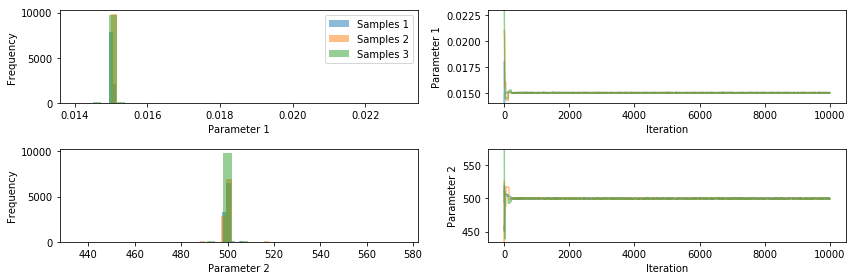

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

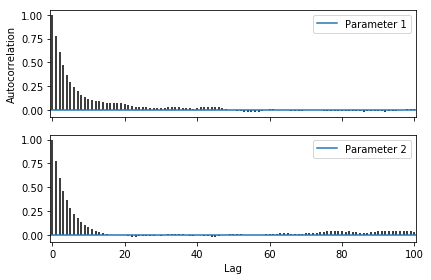

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

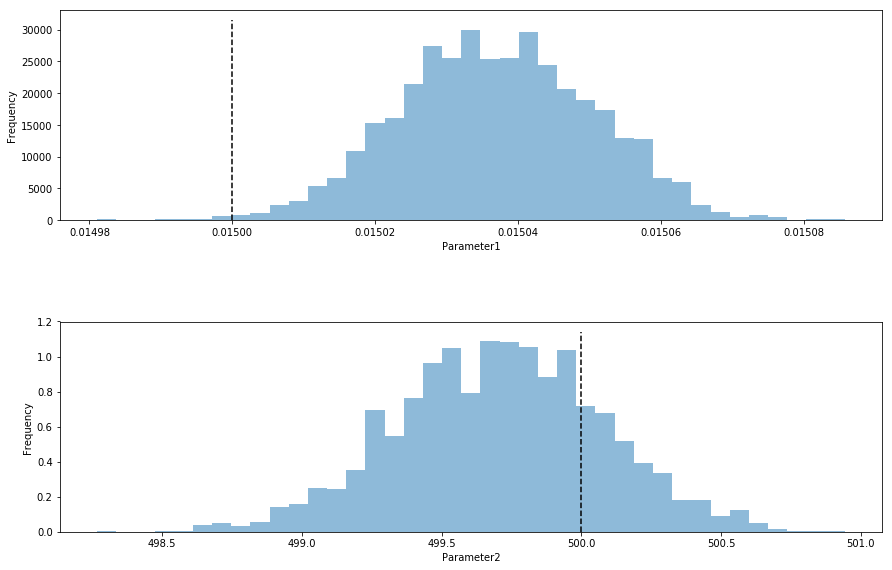

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

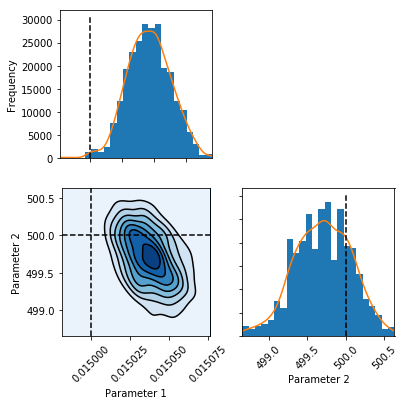

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

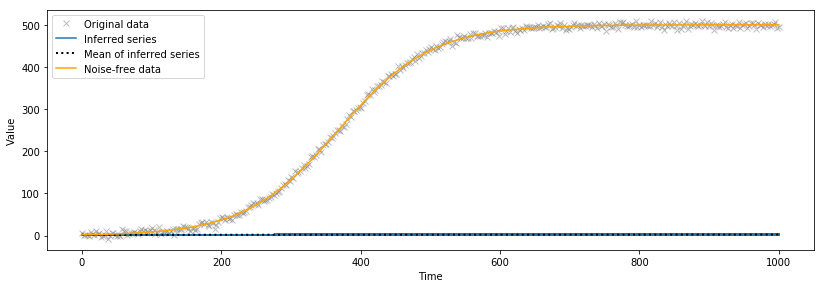

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-3614.475605909606
[0.71105319 0.99477264]
-1120383.9599910178


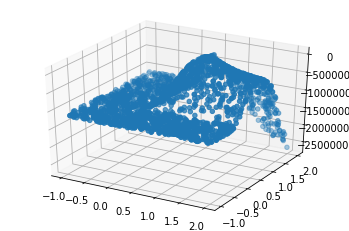

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[ 0.06010956  1.58092291]
 [ 0.83656194  1.79909105]
 [ 0.27232762  0.83112184]
 [ 0.6848439   1.27215933]
 [-0.02787084  0.46349556]]


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(problem, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=100, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [25]:
emu([0.015, 500])

array([[-1.7368682e+08]], dtype=float32)

In [26]:
log_likelihood([0.015, 500])

-1120383.9599910178

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


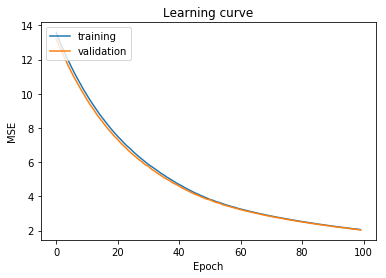

In [27]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


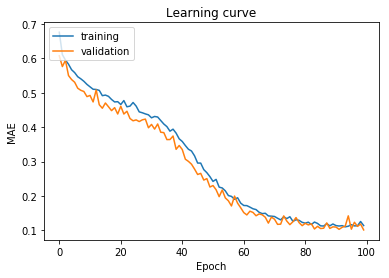

In [28]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

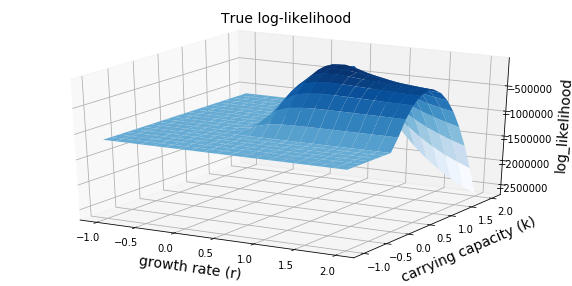

In [29]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

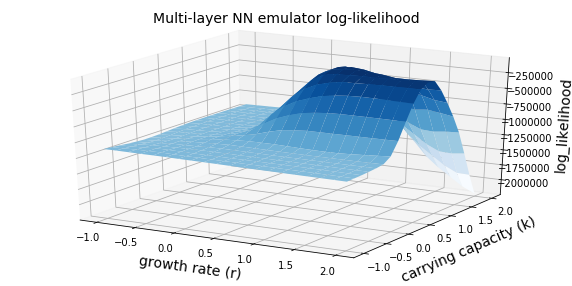

In [30]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

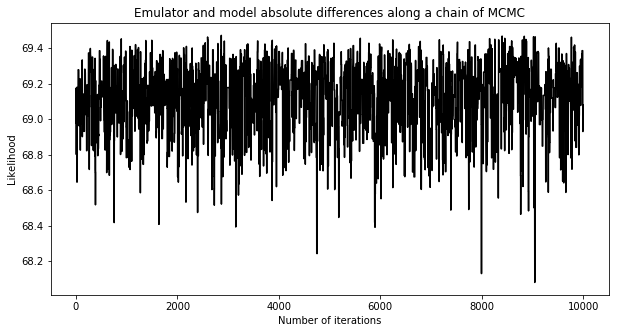

69.07839311862975

In [31]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [32]:
print(emu_prediction)

[-83758.25 -84126.   -83935.69 ... -84014.19 -84014.19 -84014.19]


In [33]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [34]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.97578042 0.86957237]
-63640.1328125


[1.01091374 1.00107649]
-63184.1328125
accepted


[1.24552814 1.22481954]
-371582.6875


1     6      0         0.5       0          0:00.0
[0.84934104 0.73205045]
-117512.0703125


[0.92904744 1.2093268 ]
-163047.890625


[1.06956453 1.12165333]
-149450.953125
accepted


2     9      0         0.333     0.333      0:00.0
[0.94985716 1.05147247]
-72330.6953125


[1.0107582  0.98206721]
-60160.6328125
accepted


[1.13996605 1.09129997]
-141830.765625
accepted


3     12     0         0.5       0.5        0:00.0
[1.04387543 0.90246254]
-57909.6328125
accepted


[0.93468016 0.99807459]
-58791.1328125
accepted


[1.13218007 0.98494631]
-74223.1328125
accepted


[1.06455322 0.7389871 ]
-100802.1328125


[1.15547835 0.88638758]
-65111.8828125


[1.21575103 

[1.10567333 0.91526687]
-62495.6953125


[0.98579501 1.08783444]
-93584.3828125


[1.06397338 0.97614255]
-63448.6328125


[0.82470875 1.08308245]
-76894.5703125


[1.01016969 0.970378  ]
-58935.3203125


[0.83743138 1.05717133]
-70302.7578125


[0.94461764 1.03657595]
-67445.6953125


[1.0441173  1.16215623]
-180010.515625


[1.0345565  0.99964056]
-65172.7578125


[1.13572839 1.07973574]
-131180.640625


[0.90951207 1.01210014]
-60750.9453125


[0.97412435 0.90632955]
-56162.6953125


[1.04249345 0.77545072]
-88318.6328125


[0.99727471 1.1197591 ]
-119221.4453125


[0.88186308 1.01190931]
-60130.5078125


[0.95046575 1.04855138]
-71542.3203125


[0.95671844 0.84512796]
-71104.6953125


[0.99005717 0.84955939]
-68688.8828125


[0.95321577 1.01631782]
-63018.8203125


[1.12991692 0.94219394]
-65927.6328125


[0.96855109 1.03162237]
-67821.8203125


[0.95668258 1.01404666]
-62566.4453125


[0.99449317 1.09845502]
-102510.6953125


[0.96891719 0.95453996]
-54882.5078125


[0.87430134 1.

-59845.8203125


[0.82728736 0.96388848]
-65111.1953125


[0.94219592 1.08350436]
-83026.0078125


[0.9782252  1.08965015]
-92526.1328125


[0.96926097 0.90154831]
-56833.1953125


[1.04595651 1.11380892]
-134645.140625


[1.04688275 1.127722  ]
-148476.140625


[0.87870414 0.94406016]
-58372.6953125


[0.90927067 0.96641976]
-55188.4453125


[1.09982335 1.03779936]
-90583.3828125


[1.00778893 0.97231939]
-58982.3203125


[0.79985105 0.88360644]
-79118.2578125


[1.10855044 1.22868201]
-319044.3125


[0.87783059 0.90701085]
-63673.1953125


[1.03383869 1.05753527]
-86363.3828125


[1.02874605 0.92909954]
-56466.7578125


[1.01610259 1.01170876]
-65854.6328125


[1.0168752  0.93448208]
-56047.5703125


[0.97604605 0.78167495]
-89148.4453125


[1.01997075 0.85236566]
-67404.0703125


[0.86762083 0.86367977]
-73167.1328125


[0.87973523 0.91239927]
-62412.1953125


[1.00223512 0.90501232]
-55888.8828125


[0.91011068 1.09231959]
-83057.6953125


[0.97343272 0.79449685]
-84955.7578125


[

[0.96693587 0.93764742]
-53322.3203125


[0.96029113 0.94120932]
-53366.0703125


[0.97427017 0.93352413]
-53271.5078125
accepted


280   843    0.0783    0.0712    0.0925     0:01.1
[0.96656781 0.93769312]
-53321.8203125


[0.96269558 0.93968425]
-53346.5078125
accepted


[0.97458554 0.93342135]
-53280.8828125


[0.96760839 0.9372982 ]
-53318.3828125
accepted


[0.96549028 0.93824322]
-53328.5078125
accepted


[0.97230505 0.93507995]
-53293.4453125


[0.96749195 0.93731487]
-53318.1328125
accepted


[0.96302848 0.9393348 ]
-53354.6328125


[0.97401202 0.93331278]
-53287.5078125


[0.96855044 0.93694578]
-53315.1953125
accepted


[0.96487643 0.93861675]
-53333.5703125
accepted


[0.9753283 0.9328034]
-53277.2578125


[0.96885446 0.93694292]
-53316.2578125


[0.96508543 0.93835182]
-53333.2578125
accepted


[0.97476205 0.93321399]
-53273.3203125


[0.96741199 0.93720838]
-53315.7578125
accepted


[0.96605496 0.93786837]
-53324.2578125
accepted


[0.97522778 0.93274913]
-53276.2578125




[0.97519694 0.9328579 ]
-53275.5703125


[0.97393802 0.93366648]
-53272.0078125
accepted


[0.97449457 0.9332856 ]
-53270.1328125
accepted


[0.97474536 0.93315121]
-53270.5078125
accepted


[0.97381084 0.93373357]
-53273.0078125


[0.97458137 0.93328413]
-53268.9453125
accepted


[0.97449172 0.93325227]
-53272.1953125
accepted


[0.97315364 0.93401844]
-53278.4453125


[0.97453186 0.93328848]
-53268.4453125
accepted


[0.97420476 0.93340177]
-53274.7578125


[0.9735665  0.93387725]
-53274.8828125


[0.97451787 0.93325719]
-53270.8203125


[0.97411388 0.93344297]
-53275.5703125


[0.97417925 0.93353614]
-53270.6328125
accepted


[0.9746545  0.93319944]
-53269.3203125


[0.97434734 0.9333264 ]
-53273.5078125
accepted


[0.97542029 0.93283926]
-53278.9453125


[0.97439444 0.93337543]
-53268.6328125
accepted


[0.97489057 0.9330119 ]
-53272.3828125
accepted


[0.97345708 0.93395733]
-53276.0703125


[0.97417467 0.93354777]
-53270.6328125


[0.97460343 0.93316538]
-53272.8828125
accepted




[0.97413945 0.93358865]
-53271.4453125


[0.97419006 0.93353581]
-53270.6328125
accepted


460   1383   0.175705  0.143167  0.208243   0:01.8
[0.97455437 0.9332493 ]
-53270.1328125
accepted


[0.97410021 0.93361324]
-53271.8203125


[0.97434596 0.9334515 ]
-53269.9453125
accepted


[0.97463666 0.93321728]
-53269.1328125
accepted


[0.97434415 0.93346975]
-53271.3203125
accepted


[0.97407166 0.93364191]
-53272.1328125


[0.97432112 0.93338665]
-53270.7578125


[0.97419098 0.93355698]
-53271.1328125
accepted


[0.97426576 0.93350353]
-53270.2578125
accepted


[0.97450765 0.93329132]
-53269.2578125
accepted


[0.97410015 0.93364493]
-53272.1953125


[0.97427596 0.9334987 ]
-53270.3203125
accepted


[0.97453384 0.93326837]
-53269.7578125
accepted


[0.97416507 0.93357397]
-53271.1328125
accepted


[0.97415354 0.93360024]
-53271.6953125


[0.97459405 0.93322654]
-53269.7578125
accepted


[0.97440643 0.93347336]
-53275.2578125


[0.97409876 0.93363279]
-53272.1328125


[0.97443947 0.933307

[0.97481955 0.93312227]
-53271.1328125


[0.97439089 0.93341369]
-53269.0703125
accepted


[0.97450611 0.93335521]
-53270.6328125
accepted


[0.97468464 0.93323096]
-53270.3203125


[0.97451888 0.9333228 ]
-53268.6328125
accepted


[0.97442208 0.9334037 ]
-53270.0078125
accepted


[0.97449736 0.93331338]
-53268.2578125
accepted


[0.97425015 0.93351169]
-53270.5078125


[0.97412565 0.93363401]
-53272.6953125


[0.97436287 0.93337317]
-53269.9453125
accepted


[0.97469387 0.93323348]
-53270.9453125


[0.97451841 0.93339834]
-53275.1953125


[0.97443628 0.9333187 ]
-53270.3203125
accepted


[0.97456045 0.9333066 ]
-53269.6328125


[0.97447315 0.93333075]
-53268.3828125
accepted


[0.97436331 0.93335558]
-53271.0078125
accepted


[0.97433915 0.93346701]
-53270.6328125


[0.97459149 0.93324077]
-53268.9453125
accepted


[0.97449524 0.93330276]
-53268.9453125
accepted


[0.9741484  0.93346471]
-53272.8828125


[0.97422115 0.9334922 ]
-53269.9453125
accepted


[0.97445098 0.9333522 ]
-53268.

[0.97490902 0.93306324]
-53272.1953125


[0.97488341 0.93308824]
-53271.8203125


[0.97463911 0.93322441]
-53269.2578125


[0.97499818 0.93306771]
-53274.2578125


[0.97423846 0.93346057]
-53269.6328125


[0.97456689 0.93329749]
-53269.1328125


[0.97455573 0.93332742]
-53271.4453125


[0.97459094 0.93326543]
-53268.5703125


[0.97466192 0.93323027]
-53269.2578125


[0.97517236 0.93293471]
-53275.0703125


[0.97423885 0.93343132]
-53271.3203125


[0.97412752 0.93347971]
-53272.8203125


[0.97473927 0.93320538]
-53271.1953125


[0.97431292 0.9334423 ]
-53269.3203125


[0.97420511 0.93349664]
-53269.9453125


[0.97449104 0.93332059]
-53268.1328125
accepted


[0.97427373 0.93344041]
-53269.3203125
accepted


[0.97495761 0.9330434 ]
-53272.6953125


[0.97404166 0.93363245]
-53271.9453125


[0.97447206 0.93329801]
-53270.2578125


[0.97434767 0.93338773]
-53269.4453125


[0.97443165 0.93335675]
-53268.2578125
accepted


[0.97413191 0.93349046]
-53271.8203125


[0.97424489 0.93350092]
-53270



[0.97467488 0.93319146]
-53269.7578125


[0.97383377 0.93370319]
-53272.3828125


[0.97464436 0.93322511]
-53269.1328125
accepted


[0.97480036 0.93316418]
-53271.3203125


[0.9745414  0.93329043]
-53267.9453125
accepted


[0.97479314 0.93311435]
-53270.9453125


[0.97485107 0.93308712]
-53271.5078125


[0.97482211 0.93315235]
-53271.1953125


[0.9741891  0.93352356]
-53270.5078125


[0.97468512 0.93320412]
-53269.5703125


[0.97497904 0.93288304]
-53275.5703125


[0.9740095 0.9336809]
-53272.8203125


[0.97439458 0.93338017]
-53268.6328125
accepted


[0.97443205 0.93342819]
-53272.6328125


[0.97503413 0.93298993]
-53273.6953125


[0.97432693 0.93344634]
-53269.5703125


[0.97457486 0.93334853]
-53274.0703125


[0.97430601 0.93347019]
-53270.0078125


[0.97447775 0.93332112]
-53268.5703125
accepted


[0.97425336 0.93341604]
-53271.6328125


[0.9752786 0.9328815]
-53276.2578125


[0.97442677 0.93332012]
-53270.7578125


[0.97455257 0.93332296]
-53270.8203125


[0.97417039 0.9335821 ]

[0.97462348 0.93314861]
-53273.1953125


[0.97470197 0.93312078]
-53271.9453125


[0.97538257 0.93280148]
-53277.6328125


[0.97390728 0.93356325]
-53276.3828125


[0.97417325 0.93344902]
-53272.8203125


[0.9742063  0.93357692]
-53272.3828125


[0.97518496 0.93287697]
-53275.4453125


[0.97474895 0.93306142]
-53273.6953125


[0.97543526 0.93274221]
-53278.1328125


[0.97674984 0.93175602]
-53294.0703125


[0.97452712 0.93326339]
-53270.0078125
accepted


[0.97499892 0.93303205]
-53273.1953125


[0.97434416 0.93352292]
-53275.7578125


[0.9741657  0.93355449]
-53270.7578125


[0.97504841 0.93311388]
-53281.1328125


[0.97417832 0.93363335]
-53275.6953125


[0.97450029 0.93324129]
-53272.6328125


[0.97531612 0.93289045]
-53277.4453125


[0.97422198 0.93350548]
-53270.0078125
accepted


[0.97435814 0.93334972]
-53271.6328125


[0.97493924 0.93296862]
-53272.8828125


[0.9747037  0.93316245]
-53270.1328125


[0.97458128 0.93319337]
-53272.1953125
accepted


[0.97515121 0.93293641]
-53274

[0.97460817 0.9331064 ]
-53276.5703125


[0.97455962 0.93326736]
-53268.6328125


[0.97398375 0.93365417]
-53272.1328125


[0.97498692 0.93299353]
-53273.1953125


[0.97386361 0.93362617]
-53274.2578125


[0.97427767 0.93349929]
-53270.3203125


920   2763   0.265     0.257329  0.257329   0:03.7
[0.97463924 0.93323314]
-53268.9453125


[0.97392518 0.9336424 ]
-53271.6328125


[0.97390532 0.93365997]
-53271.9453125


[0.97413469 0.93349446]
-53271.5078125


[0.97427654 0.93345699]
-53269.4453125


[0.97407196 0.93357837]
-53271.0078125


[0.97459585 0.93325384]
-53268.5703125


[0.97429855 0.93342352]
-53269.4453125


[0.97404245 0.93360708]
-53271.5078125
accepted


[0.97415015 0.93355985]
-53271.0078125


[0.97433955 0.93347475]
-53271.5078125


[0.97380412 0.93375349]
-53273.3828125


[0.97403283 0.93364543]
-53272.0078125


[0.97434027 0.93341032]
-53268.7578125
accepted


[0.97413534 0.93355988]
-53270.8203125
accepted


[0.97488865 0.93303567]
-53272.3828125


[0.97382483 0.933703



[0.97449468 0.9333494 ]
-53269.4453125
accepted


[0.97448787 0.93331014]
-53269.1328125
accepted


[0.97396259 0.93364599]
-53271.8203125


[0.97402251 0.93360422]
-53271.1953125


[0.97373516 0.93368724]
-53275.4453125


[0.97447523 0.93330555]
-53269.7578125
accepted


[0.97365318 0.93387211]
-53275.1953125


[0.97493555 0.93283768]
-53279.9453125


[0.97503679 0.93296648]
-53273.8828125


[0.97341156 0.93405094]
-53277.6328125


[0.97397369 0.93359871]
-53271.6953125


[0.9738495  0.93363924]
-53274.3828125


[0.97462274 0.93324916]
-53268.9453125
accepted


[0.97412671 0.9335541 ]
-53270.6328125


[0.97469691 0.93322289]
-53270.3203125
accepted


[0.97429674 0.93333718]
-53275.0078125


[0.97484545 0.93307616]
-53271.6953125


[0.975215   0.93284332]
-53275.8828125


[0.97346042 0.93413794]
-53279.4453125


[0.97429584 0.93347393]
-53269.9453125


[0.97450358 0.93336067]
-53270.9453125


[0.97479796 0.93315496]
-53270.9453125


[0.97385089 0.93370285]
-53272.6328125


[0.9756113

[0.97412469 0.93370393]
-53278.6328125


[0.97388506 0.93365626]
-53271.6328125
accepted


[0.97436206 0.93338759]
-53269.0703125
accepted


[0.97464298 0.93324672]
-53269.3203125
accepted


[0.97327667 0.93410901]
-53278.3203125


[0.97383177 0.93362945]
-53275.3828125


[0.97419598 0.93345264]
-53271.6953125


[0.97443956 0.93320708]
-53277.0703125


[0.97450097 0.93330236]
-53268.9453125
accepted


[0.9746942 0.9332934]
-53276.1328125


[0.97389783 0.93365125]
-53271.8203125
accepted


[0.97553442 0.93261478]
-53279.6328125


[0.97441925 0.93340914]
-53270.3203125


[0.9739073  0.93367256]
-53272.3203125
accepted


[0.97460918 0.93325018]
-53268.9453125
accepted


[0.97492532 0.93308908]
-53272.3203125


[0.97389326 0.93357972]
-53275.9453125


[0.97514856 0.93292469]
-53274.8828125


[0.9745381  0.93327007]
-53269.3203125
accepted


[0.9738459  0.93371911]
-53272.6953125
accepted


[0.97463071 0.93322576]
-53269.1328125
accepted


[0.97445351 0.93328961]
-53271.4453125


[0.9735152

-53273.1953125


[0.9742889  0.93350757]
-53271.3203125


[0.97395006 0.93368392]
-53272.3828125


[0.97380861 0.93375045]
-53273.0703125


[0.97577759 0.93251411]
-53282.3203125


[0.9741402  0.93344024]
-53274.8828125


[0.97381187 0.93379308]
-53274.0703125


[0.97517858 0.93296413]
-53275.8828125


[0.97403148 0.93352636]
-53273.8203125


1200  3603   0.265     0.267     0.258      0:04.9
[0.97427966 0.93358172]
-53277.0703125


[0.97374965 0.93377952]
-53273.8203125


[0.9747537  0.93310354]
-53270.8203125


[0.97416662 0.93357895]
-53271.3203125


[0.97413346 0.9336897 ]
-53277.8203125


[0.97443336 0.93341999]
-53272.1328125


[0.97364609 0.93377866]
-53273.5703125


[0.97452917 0.93327391]
-53269.4453125
accepted


[0.97438978 0.933374  ]
-53268.9453125
accepted


[0.97434567 0.93335889]
-53271.8203125


[0.97453539 0.9332983 ]
-53267.9453125
accepted


[0.97407301 0.93363403]
-53272.0078125


[0.97428973 0.93343483]
-53269.1328125


[0.97588261 0.93249716]
-53283.1953125


[0.

[0.97458294 0.93330412]
-53270.7578125
accepted


[0.97407075 0.93348462]
-53274.7578125


[0.97478327 0.9331446 ]
-53270.8203125
accepted


[0.97556278 0.93257627]
-53280.0078125


[0.97463013 0.9331495 ]
-53273.0703125


[0.97466895 0.93318836]
-53269.4453125
accepted


[0.97544246 0.93274508]
-53278.3203125


[0.97431342 0.93344471]
-53269.3203125
accepted


[0.97459664 0.93318537]
-53272.1328125


[0.97430119 0.9334626 ]
-53269.5703125
accepted


[0.97437271 0.93348412]
-53274.0703125


[0.97408105 0.93371658]
-53277.2578125


[0.97438366 0.93343626]
-53270.7578125


[0.97446834 0.93340768]
-53273.0078125


[0.9757685  0.93259011]
-53281.8828125


[0.97461452 0.93322231]
-53269.2578125
accepted


[0.97333056 0.93412567]
-53278.8203125


[0.97507679 0.93294172]
-53274.2578125


[0.97446277 0.93328754]
-53271.1953125


[0.97418816 0.93353744]
-53270.7578125


[0.97538803 0.93267883]
-53278.0703125


[0.97447741 0.93309502]
-53282.3828125


[0.97430675 0.93348604]
-53270.5078125


[0.

-53273.0078125


[0.97449793 0.93325342]
-53271.9453125


[0.97419117 0.93350535]
-53270.0078125


[0.97456717 0.93329703]
-53269.1328125
accepted


[0.97422265 0.93357912]
-53273.8203125


[0.97464919 0.93322288]
-53269.2578125
accepted


[0.97474628 0.93321042]
-53272.0078125


[0.97517519 0.93297227]
-53276.3828125


[0.9747254  0.93312894]
-53270.5078125
accepted


[0.97500855 0.93302105]
-53273.5703125


[0.97437178 0.93351231]
-53276.5703125


[0.97453498 0.93324341]
-53271.3203125


[0.97444706 0.9333488 ]
-53268.1328125
accepted


[0.97461854 0.93335815]
-53277.3203125


[0.97404187 0.93360919]
-53271.6328125
accepted


[0.97498746 0.93296344]
-53273.1953125


[0.9750319  0.93301604]
-53273.6953125


[0.97444115 0.93332197]
-53269.9453125
accepted


[0.97453495 0.93324135]
-53271.3203125


[0.97469656 0.93323911]
-53271.6328125


[0.97426472 0.93336723]
-53274.3828125


[0.97419117 0.93357399]
-53271.4453125


[0.97456571 0.93325569]
-53269.1328125
accepted


[0.97436216 0.9335

[0.97508908 0.93291933]
-53274.5078125


[0.97528371 0.93281173]
-53276.5703125


[0.97411628 0.93350367]
-53271.9453125


[0.9740842  0.93363801]
-53272.1953125


[0.97489842 0.93307057]
-53272.1328125


[0.97446955 0.93335847]
-53268.8203125
accepted


[0.97428697 0.93336252]
-53273.5703125


[0.97429469 0.9333435 ]
-53274.5078125


[0.9739653 0.9336995]
-53272.8203125


[0.97430321 0.93347949]
-53269.9453125


[0.97482784 0.93312182]
-53271.5078125
accepted


[0.97440575 0.93341865]
-53270.5078125


[0.97416026 0.93352723]
-53270.4453125


[0.97442074 0.93343141]
-53272.3203125
accepted


[0.97457654 0.93331783]
-53271.6328125


[0.97492059 0.93311969]
-53274.3828125


[0.97471325 0.93315165]
-53270.1328125
accepted


[0.97435423 0.93353826]
-53277.6328125


[0.97459665 0.93320167]
-53271.0078125


[0.97476654 0.93312409]
-53270.8203125
accepted


[0.9750956  0.93301727]
-53275.5703125


[0.97407539 0.9336522 ]
-53272.3828125


[0.97432948 0.93345937]
-53269.6328125
accepted


[0.97

[0.97398786 0.93360038]
-53271.1328125


[0.97444574 0.93332409]
-53269.7578125
accepted


[0.97348944 0.93411854]
-53279.0078125


[0.97444824 0.93336825]
-53268.5703125
accepted


[0.97348136 0.93400106]
-53276.8828125


[0.97420424 0.93367343]
-53280.5078125


[0.9744256  0.93329229]
-53272.3828125
accepted


[0.97399966 0.93358731]
-53271.1953125


[0.97433892 0.93353802]
-53276.8828125


[0.97444118 0.93320029]
-53277.5703125


[0.97489637 0.93301446]
-53272.3828125


[0.9746952 0.9330971]
-53273.6953125
accepted


1580  4743   0.257     0.265     0.264      0:06.4
[0.97484993 0.93305983]
-53271.4453125
accepted


[0.9738101  0.93361976]
-53276.8828125


[0.97575248 0.93246166]
-53282.5078125


[0.97486531 0.9331503 ]
-53273.8203125


[0.97466297 0.93323462]
-53269.6328125
accepted


[0.97402034 0.93342053]
-53280.6328125


[0.97538719 0.93283286]
-53277.5703125


[0.97460532 0.93335316]
-53276.2578125


[0.97488164 0.93283676]
-53282.1953125


[0.97405477 0.93351089]
-53273.88281

[0.97539004 0.93276357]
-53277.7578125


[0.97253324 0.93465163]
-53285.9453125


[0.97383852 0.93369343]
-53272.1328125


[0.9746943  0.93323849]
-53271.3203125
accepted


[0.97422182 0.93347506]
-53269.3203125
accepted


[0.97482298 0.93314869]
-53271.1953125


[0.9747072  0.93305835]
-53275.5703125


[0.97384365 0.93367702]
-53272.1953125


[0.97464999 0.93330542]
-53274.6953125


[0.97465696 0.93331337]
-53275.6953125


[0.97432699 0.93324353]
-53279.4453125


[0.97473191 0.93310407]
-53271.6953125


[0.97429194 0.93341058]
-53270.4453125
accepted


[0.973827   0.93373786]
-53273.0703125


[0.97461676 0.93333143]
-53274.8828125


[0.97394918 0.93382885]
-53279.5078125


[0.97336017 0.93418999]
-53280.0078125


[0.97387458 0.93376121]
-53273.8203125


[0.97459642 0.93321493]
-53270.2578125
accepted


[0.97337002 0.93401188]
-53276.6328125


[0.97422271 0.93352947]
-53270.6328125


[0.9746616 0.933112 ]
-53274.0703125


[0.97565341 0.93243672]
-53281.3203125


[0.97479231 0.93308426]

[0.97490689 0.93320992]
-53281.1328125


[0.9740664  0.93362809]
-53271.8203125


[0.97524176 0.93295163]
-53278.3203125


[0.97446116 0.9333915 ]
-53271.3203125


[0.97471276 0.9331439 ]
-53270.0078125


[0.9747577  0.93308984]
-53271.6328125


[0.97337721 0.93393947]
-53275.4453125


[0.97448854 0.93336913]
-53270.8203125


[0.97457505 0.93319732]
-53272.3203125


[0.97435683 0.93336056]
-53270.9453125


[0.97427926 0.93354303]
-53273.5703125


[0.97376766 0.93381428]
-53274.2578125


[0.9733976  0.93405149]
-53277.4453125


[0.97425218 0.9334199 ]
-53271.4453125


[0.97442079 0.93333919]
-53269.5703125


[0.97426648 0.93354793]
-53273.5703125


[0.97488117 0.9330554 ]
-53272.0078125


[0.9755745  0.93274279]
-53279.6328125


[0.97478617 0.93315177]
-53270.6328125


[0.9748455  0.93308844]
-53271.6328125


[0.9749107  0.93307025]
-53272.1328125


[0.97522081 0.93291235]
-53275.6953125


[0.97445986 0.93324796]
-53273.8203125


[0.97386052 0.93384402]
-53275.4453125


[0.97446781 0.93


[0.97465867 0.93347475]
-53289.6953125


[0.97404985 0.93356567]
-53270.7578125
accepted


[0.97389818 0.93368374]
-53272.1953125
accepted


[0.97438583 0.93336195]
-53269.8203125
accepted


[0.97337157 0.933965  ]
-53275.5703125


[0.97413556 0.93354735]
-53270.6328125
accepted


[0.97396913 0.93355864]
-53274.2578125


[0.97420269 0.93349237]
-53270.0078125
accepted


[0.97481843 0.93310069]
-53271.4453125


[0.97416965 0.93373999]
-53284.4453125


[0.97370156 0.93375939]
-53273.1953125


[0.97467749 0.93324863]
-53271.5078125
accepted


[0.97464987 0.93310634]
-53274.8828125


[0.97308582 0.93411808]
-53277.5703125


[0.97442225 0.93334831]
-53269.2578125
accepted


[0.9742366  0.93351417]
-53270.3203125


[0.97448212 0.93334169]
-53268.1328125
accepted


1860  5583   0.255     0.262762  0.25       0:07.5
[0.97487223 0.93304377]
-53272.0078125


[0.97332017 0.93398976]
-53276.0703125


[0.97576903 0.93264709]
-53282.3828125


[0.97350228 0.9339292 ]
-53275.6953125


[0.97444306 0.9

[0.97443688 0.93323379]
-53275.6953125


[0.97406449 0.93355445]
-53270.7578125


[0.9747819 0.9330542]
-53272.8203125


[0.97427141 0.93325242]
-53281.0078125


[0.97493487 0.93307014]
-53272.3828125


[0.97456963 0.93327249]
-53268.2578125
accepted


[0.97416585 0.93355706]
-53270.8203125
accepted


[0.97471331 0.93321573]
-53270.6328125


[0.97477088 0.93315385]
-53270.7578125


[0.97344581 0.93394718]
-53275.5703125


[0.97422622 0.93354471]
-53270.9453125


[0.97509934 0.932872  ]
-53274.6953125


[0.97300385 0.93432127]
-53281.3203125


[0.97487977 0.93306882]
-53271.9453125
accepted


[0.9751577  0.93287959]
-53275.3828125


[0.97415735 0.93346432]
-53272.6328125
accepted


[0.97494701 0.93306645]
-53272.6953125
accepted


[0.97404974 0.93359103]
-53271.3203125


[0.97499711 0.93304922]
-53273.1953125
accepted


[0.97512279 0.93295323]
-53274.6953125


[0.97421389 0.93347981]
-53269.7578125


[0.97463198 0.93325357]
-53269.1328125
accepted


[0.97471389 0.93321141]
-53270.445312

[0.97511698 0.93288734]
-53274.8828125


[0.973936   0.93362705]
-53271.1953125
accepted


[0.97501942 0.93293112]
-53273.6953125


[0.97454617 0.9332519 ]
-53270.1328125


2040  6123   0.251     0.255267  0.247      0:08.2
[0.97384658 0.93360342]
-53276.2578125


[0.97553732 0.9327263 ]
-53279.3203125


[0.97474657 0.93323516]
-53274.3828125


[0.97400617 0.93359953]
-53271.0078125
accepted


[0.97478817 0.93313542]
-53270.9453125


[0.97500417 0.93304655]
-53273.1953125


[0.9752412  0.93293159]
-53276.4453125


[0.97456341 0.93323249]
-53270.7578125


[0.97417009 0.93349907]
-53269.9453125


[0.97521228 0.93291931]
-53275.6953125


[0.97490536 0.93309627]
-53272.0078125


[0.97439312 0.93337872]
-53268.5703125
accepted


[0.97373582 0.93373171]
-53272.8203125


[0.97406528 0.93354907]
-53270.9453125


[0.97430901 0.93350563]
-53272.1953125


[0.97436217 0.93336421]
-53270.6328125
accepted


[0.97487256 0.93303056]
-53272.1953125


[0.97447014 0.93330242]
-53270.1328125


[0.975129  

[0.97527815 0.93290541]
-53276.5703125


[0.97459871 0.9332657 ]
-53268.6328125
accepted


[0.97473916 0.93319918]
-53270.7578125


[0.9751257  0.93283834]
-53275.0078125


[0.9745314  0.93334255]
-53271.3203125


[0.97486854 0.93315157]
-53274.0703125


[0.97613348 0.93245331]
-53286.9453125


[0.97544996 0.93263988]
-53278.9453125


[0.97443455 0.9334163 ]
-53271.6328125


[0.9743613  0.93324712]
-53277.7578125


[0.97545976 0.93272698]
-53278.5078125


[0.97418371 0.93354828]
-53270.7578125
accepted


[0.97529971 0.93285532]
-53276.8828125


[0.97448477 0.93334528]
-53268.5703125
accepted


[0.97382361 0.93373605]
-53273.0078125


[0.97411555 0.93356475]
-53270.9453125
accepted


[0.97429942 0.93350662]
-53271.8203125


[0.97478826 0.93326194]
-53279.1328125


[0.97313865 0.93412835]
-53278.1328125


[0.97440505 0.93338163]
-53268.3828125
accepted


[0.9740053  0.93369944]
-53273.0703125


2140  6423   0.251     0.257     0.248      0:08.6
[0.97429336 0.93343529]
-53269.1328125
acce

[0.97434623 0.93329037]
-53275.6953125


[0.97447704 0.93331717]
-53268.9453125
accepted


[0.97458227 0.93321958]
-53270.7578125
accepted


[0.97527568 0.93280633]
-53276.5703125


[0.97343842 0.93398925]
-53276.5703125


[0.97464604 0.9332341 ]
-53269.2578125
accepted


[0.97441467 0.93333453]
-53270.2578125


[0.97403292 0.9334754 ]
-53276.6328125


[0.97458165 0.93319698]
-53271.9453125


[0.97432328 0.93336384]
-53272.1953125


[0.97470494 0.93315875]
-53269.8203125
accepted


[0.97484143 0.93311957]
-53271.4453125


[0.97535515 0.93274199]
-53277.3203125


[0.97474165 0.93319617]
-53270.6328125
accepted


[0.97435282 0.93341732]
-53268.9453125
accepted


[0.9737533  0.93377117]
-53273.3203125


[0.9742293  0.93350915]
-53270.2578125
accepted


[0.9738042  0.93378779]
-53274.0703125


[0.97478999 0.93308094]
-53271.1328125


[0.97494712 0.93307292]
-53272.6953125


[0.9744764 0.9334641]
-53278.3203125


[0.97450753 0.93334821]
-53270.1328125


[0.97477449 0.93310032]
-53270.757812



[0.97499691 0.93298946]
-53273.3203125


[0.97453606 0.93332082]
-53269.5703125


[0.97507757 0.93290307]
-53274.2578125


[0.97473668 0.93318492]
-53270.1328125


[0.97415533 0.93349863]
-53270.5078125


[0.97323531 0.93400305]
-53276.1328125


[0.97449794 0.93321244]
-53274.3828125


[0.97443527 0.933408  ]
-53271.1953125


[0.97494702 0.93301116]
-53272.6953125


[0.97491284 0.93303444]
-53272.3203125


[0.97492072 0.93293207]
-53275.0078125


[0.97400253 0.93367403]
-53272.5078125


[0.97505751 0.93288772]
-53274.0703125


2320  6963   0.248     0.266     0.246      0:09.4
[0.97394381 0.93365163]
-53272.0078125


[0.97315461 0.93420082]
-53279.6328125


[0.97501867 0.93296951]
-53273.3828125


[0.97428391 0.93344969]
-53269.1328125


[0.97446911 0.93347977]
-53279.1953125


[0.97472599 0.93319487]
-53270.1328125


[0.97377456 0.93377146]
-53273.3828125


[0.97422117 0.93353624]
-53270.7578125


[0.9748644  0.93301417]
-53272.0078125


[0.97420854 0.93347319]
-53269.8203125


[0.9

[0.97517253 0.93283003]
-53275.5703125


[0.97475216 0.93316984]
-53270.6328125
accepted


[0.97456301 0.93310294]
-53278.4453125


[0.9744215 0.9332741]
-53273.8828125


[0.97486641 0.93309378]
-53271.8203125


[0.97484107 0.93290633]
-53279.5078125


[0.97424845 0.9335574 ]
-53273.3203125


[0.97519142 0.93290327]
-53275.3828125


[0.97368931 0.9336921 ]
-53277.0703125


[0.97405387 0.93365197]
-53272.3828125


[0.97536332 0.9328436 ]
-53277.2578125


[0.97417404 0.93351878]
-53270.1328125


[0.97392739 0.93379871]
-53275.3828125


[0.97493657 0.93312647]
-53275.6953125


[0.97592245 0.93237077]
-53284.1953125


[0.97467442 0.93322123]
-53269.5703125
accepted


[0.97481115 0.93316898]
-53272.3203125


[0.97445694 0.93320721]
-53276.2578125


[0.97461817 0.93333763]
-53275.6953125


[0.97485611 0.93306791]
-53271.9453125


[0.97404595 0.93353002]
-53272.8203125


[0.97461037 0.93315489]
-53273.5078125


[0.9745558  0.93327964]
-53268.3828125
accepted


[0.97539382 0.93285879]
-53279.0

[0.97471294 0.933224  ]
-53271.4453125


[0.97398975 0.93357688]
-53272.3203125
accepted


[0.97415844 0.93365793]
-53276.8828125


[0.97335093 0.93413987]
-53279.0078125


[0.97366421 0.93370284]
-53277.7578125


[0.97457632 0.93338548]
-53277.4453125


[0.97448431 0.93334869]
-53268.6328125
accepted


[0.97361262 0.93384009]
-53274.3828125


[0.97386452 0.93380462]
-53274.5703125


[0.97382722 0.93380944]
-53274.5078125


[0.97425083 0.93333616]
-53276.7578125


[0.97346651 0.93409043]
-53278.5078125


[0.97376515 0.93383555]
-53274.7578125


[0.97414548 0.93347202]
-53272.3828125
accepted


[0.97434599 0.9333582 ]
-53271.6953125
accepted


[0.97427047 0.93354615]
-53273.5703125


[0.97387415 0.93355125]
-53278.4453125


[0.9750422  0.93298666]
-53273.8203125


[0.97463921 0.93316309]
-53271.8203125


[0.97408663 0.9334101 ]
-53278.6328125


[0.97392105 0.93368749]
-53272.3828125


[0.97546564 0.93269202]
-53278.7578125


[0.97339844 0.93391367]
-53275.2578125


[0.97412906 0.9334758



[0.9739962  0.93350777]
-53276.4453125


[0.97456831 0.93326771]
-53268.3828125
accepted


[0.97469876 0.93309149]
-53274.0078125


[0.97527353 0.93279576]
-53276.6328125


[0.97450701 0.93326289]
-53270.9453125


[0.97419329 0.9336387 ]
-53277.1328125


[0.97447389 0.93313032]
-53280.3203125


[0.97439286 0.93334515]
-53270.4453125


[0.97487559 0.93304069]
-53272.1328125


[0.97477195 0.9331721 ]
-53270.6328125
accepted


[0.97420602 0.93350057]
-53269.8203125
accepted


[0.97373754 0.9337514 ]
-53273.1953125


[0.97503856 0.93297217]
-53273.8828125


[0.97444314 0.93340664]
-53271.5078125
accepted


[0.97482764 0.93322477]
-53277.7578125


[0.97482124 0.93312586]
-53271.1953125
accepted


[0.97452291 0.93333968]
-53270.4453125
accepted


[0.97462457 0.9332217 ]
-53269.1328125


[0.97383035 0.93366417]
-53273.3828125


2600  7803   0.25      0.256     0.244      0:10.5
[0.97437341 0.93354585]
-53279.5078125


[0.97434872 0.93344413]
-53269.4453125
accepted


[0.9748333  0.93322835]

accepted


[0.97412876 0.93354223]
-53270.4453125


[0.97379881 0.93403038]
-53287.8203125


[0.97454939 0.93328716]
-53268.2578125
accepted


[0.97474825 0.93314338]
-53270.6328125


[0.97332302 0.93400469]
-53276.3828125


[0.97414717 0.93357328]
-53271.1953125


[0.97411091 0.93357478]
-53271.1328125


[0.97329788 0.93393204]
-53278.0703125


[0.97413826 0.93355638]
-53270.9453125


[0.97474586 0.93312336]
-53270.4453125


[0.97479719 0.93308555]
-53271.3203125


[0.97432818 0.93342118]
-53268.9453125
accepted


[0.97456378 0.93335963]
-53274.3828125


[0.97428558 0.93355051]
-53274.6953125


[0.97455651 0.9333266 ]
-53271.4453125


[0.97392699 0.93371062]
-53272.8828125


[0.97376484 0.93378648]
-53273.8828125


[0.97459152 0.93318413]
-53272.1953125


[0.97440997 0.93328997]
-53273.3203125


[0.97412793 0.93339692]
-53277.7578125


[0.9746841  0.93326533]
-53273.3203125


[0.97485197 0.93294229]
-53276.9453125


[0.97413284 0.93356644]
-53270.9453125
accepted


[0.97393226 0.93361

[0.97487498 0.93319118]
-53277.7578125


[0.97485905 0.93300664]
-53272.6328125


[0.97433087 0.93348066]
-53271.5078125


[0.9735534  0.93394777]
-53276.1328125


[0.97442324 0.93325333]
-53275.0078125


[0.97459776 0.93324908]
-53268.5703125


[0.97311835 0.93419212]
-53279.5078125


[0.97422245 0.93354353]
-53270.9453125
accepted


[0.97451507 0.93324182]
-53271.9453125


[0.97435055 0.93336855]
-53270.8203125
accepted


[0.97464266 0.93314171]
-53273.0078125


[0.97439492 0.93342966]
-53270.5078125


[0.97475024 0.93300571]
-53276.9453125


[0.97430237 0.93355006]
-53275.7578125


[0.97371539 0.93385912]
-53275.0703125


[0.97443299 0.93339517]
-53270.0078125
accepted


[0.97372076 0.93379736]
-53273.8828125


[0.97439643 0.93341318]
-53269.5703125
accepted


[0.974237   0.93359984]
-53276.2578125


[0.97364634 0.93398489]
-53277.0703125


[0.97450963 0.93335665]
-53271.0078125
accepted


[0.97525525 0.93286512]
-53276.0703125


[0.97472266 0.93311147]
-53271.5078125


[0.97440983 

[0.97394993 0.93373364]
-53273.5703125


[0.97444324 0.93336491]
-53268.3828125
accepted


[0.97433405 0.93332851]
-53274.0078125


[0.97451661 0.93337315]
-53272.8203125


[0.97435001 0.93346574]
-53271.1953125


[0.97413223 0.93348856]
-53272.1328125


[0.97395043 0.93370683]
-53273.0078125


[0.97378227 0.9338989 ]
-53275.9453125


[0.97441946 0.93328323]
-53273.0703125
accepted


[0.97426919 0.93344605]
-53269.2578125


[0.97404274 0.93363609]
-53272.0078125


[0.97499678 0.93287999]
-53274.8828125


[0.97449739 0.93337943]
-53272.3828125


[0.97399224 0.9336434 ]
-53271.9453125


[0.97471745 0.9330372 ]
-53276.6328125


[0.97437804 0.93339085]
-53268.4453125
accepted


[0.97514052 0.93302434]
-53278.7578125


[0.97446395 0.93327923]
-53271.8203125
accepted


2880  8643   0.251     0.251     0.238      0:11.6
[0.97444233 0.93346824]
-53276.8828125


[0.97441617 0.93324982]
-53275.3828125


[0.97425378 0.93342505]
-53271.1328125
accepted


[0.97450387 0.9332773 ]
-53270.2578125


[0

-53271.8203125


[0.97389842 0.93362   ]
-53273.5078125


[0.9740585  0.93359947]
-53271.1953125


[0.97382105 0.93367409]
-53273.3203125


[0.97515176 0.93284356]
-53275.4453125


[0.97417819 0.93347324]
-53271.1328125


[0.97377583 0.93376134]
-53273.3203125


[0.97475384 0.9331596 ]
-53270.6328125
accepted


[0.97420667 0.93355661]
-53271.1953125


[0.97380897 0.93373605]
-53273.0703125


[0.97443862 0.93342847]
-53273.0703125


[0.97487467 0.93309831]
-53271.9453125


[0.97437086 0.93341263]
-53268.7578125
accepted


[0.97566127 0.93259891]
-53281.0078125


[0.97454745 0.93344716]
-53280.8828125


[0.97444921 0.93344765]
-53275.4453125


[0.97535438 0.93280945]
-53277.3203125


[0.97435709 0.93346638]
-53271.8203125


[0.97465368 0.93329107]
-53273.6953125
accepted


[0.97463734 0.9331892 ]
-53270.2578125
accepted


[0.97409511 0.93360299]
-53271.6328125


[0.97462982 0.93324248]
-53269.0703125
accepted


[0.97467064 0.933003  ]
-53280.3828125


[0.97483762 0.93309455]
-53271.63281

[0.97395847 0.93360536]
-53271.8203125


[0.97504304 0.93293687]
-53273.8828125


3060  9183   0.249     0.245998  0.238      0:12.3
[0.97315983 0.9340414 ]
-53276.9453125


[0.97426188 0.9334999 ]
-53270.1328125
accepted


[0.97457715 0.93322191]
-53270.7578125


[0.97347323 0.93385317]
-53276.0703125


[0.97428825 0.9334833 ]
-53270.1328125
accepted


[0.97446363 0.93326362]
-53272.5078125


[0.97334639 0.9339802 ]
-53275.9453125


[0.97477722 0.93318693]
-53271.8203125


[0.97450147 0.93335696]
-53270.5078125


[0.97366616 0.93384469]
-53274.5078125


[0.97462018 0.93325307]
-53268.8203125
accepted


[0.97452525 0.93336906]
-53273.0703125


[0.97371472 0.93390104]
-53275.9453125


[0.97555502 0.93263631]
-53279.5078125


[0.97418205 0.93348874]
-53270.1328125
accepted


[0.97484669 0.93312596]
-53271.4453125
accepted


[0.97434121 0.9334213 ]
-53268.9453125
accepted


[0.97430107 0.93323904]
-53280.5078125


[0.97625767 0.93229069]
-53287.4453125


[0.97476158 0.93320868]
-53272.695

[0.97491533 0.93305354]
-53272.3203125


[0.97420145 0.9335157 ]
-53270.2578125


[0.97451887 0.93330917]
-53267.8828125
accepted


[0.97425076 0.9334732 ]
-53269.6328125
accepted


[0.97476868 0.93323062]
-53275.0703125


[0.97526181 0.93294814]
-53279.1328125


[0.97407148 0.93361528]
-53271.4453125
accepted


[0.97361727 0.93382722]
-53273.8828125


[0.97477242 0.93320914]
-53273.5703125


[0.97363749 0.93388924]
-53275.2578125


[0.97406998 0.93362673]
-53271.8203125


[0.97453209 0.93322929]
-53272.1328125


[0.97464481 0.93341473]
-53283.8828125


[0.97519033 0.93299318]
-53278.9453125


[0.97365657 0.93387836]
-53275.1953125


[0.9733379  0.93403013]
-53276.9453125


[0.97483205 0.93323107]
-53278.6328125


[0.9748416  0.93312761]
-53271.5078125


3160  9483   0.247     0.247     0.237583   0:12.7
[0.97387679 0.93353399]
-53279.4453125


[0.9744899  0.93327168]
-53271.1953125


[0.97462532 0.93329051]
-53272.0078125


[0.9742642  0.93363282]
-53280.8203125


[0.97363712 0.933926

[0.97381777 0.9337016 ]
-53272.6328125


[0.97359612 0.93391609]
-53275.6953125


[0.97401914 0.93359536]
-53271.1328125


[0.97382869 0.93379748]
-53274.3828125


[0.97488438 0.93304151]
-53272.1953125


[0.97446124 0.93333948]
-53268.2578125
accepted


[0.97476169 0.9333509 ]
-53284.8828125


[0.97325303 0.93415391]
-53279.0078125


[0.97459649 0.93331937]
-53273.0703125


[0.97472043 0.93318035]
-53270.1328125


[0.97438068 0.93328901]
-53274.5078125


[0.97536725 0.93283917]
-53277.2578125


[0.973908   0.93377687]
-53274.1953125


[0.97457399 0.93334565]
-53273.6953125


[0.97388267 0.93361373]
-53274.5078125


[0.9744613  0.93336576]
-53269.2578125
accepted


[0.97471955 0.93310465]
-53272.1953125
accepted


[0.97443717 0.93339083]
-53269.8203125
accepted


[0.97507501 0.93288898]
-53274.3828125
accepted


[0.97393461 0.93371579]
-53273.0703125
accepted


[0.97459068 0.93330893]
-53271.6328125


[0.97406939 0.9334903 ]
-53274.5703125
accepted


[0.9736885  0.93382952]
-53274.5078

[0.97486681 0.93295685]
-53275.3828125


[0.97448506 0.93335509]
-53269.4453125


[0.97444273 0.93336428]
-53268.3828125
accepted


[0.97457065 0.93331049]
-53270.6328125
accepted


[0.97394917 0.93369296]
-53272.8203125


[0.97499609 0.93299073]
-53273.3203125


[0.97541588 0.93275176]
-53278.1328125


[0.97514853 0.93287952]
-53275.1953125


[0.97362712 0.93374753]
-53276.1328125


[0.97479208 0.93318467]
-53272.3828125
accepted


[0.97426466 0.93356898]
-53275.0703125


[0.97417368 0.93361418]
-53273.5703125


[0.97471473 0.93334055]
-53281.3203125


[0.97528268 0.93276448]
-53276.7578125


[0.97462887 0.9331892 ]
-53270.7578125


[0.97470421 0.93311332]
-53272.1953125
accepted


[0.97388757 0.93370173]
-53272.3828125


[0.97505856 0.93297127]
-53274.0703125


[0.9750256  0.93307123]
-53276.0703125


[0.9749023  0.93308577]
-53272.1328125


[0.97432262 0.93349586]
-53272.1953125


[0.97378603 0.93368299]
-53274.0078125


[0.97457614 0.933261  ]
-53268.5703125
accepted


[0.97448462 

[0.97479267 0.93297743]
-53277.1328125


[0.97462613 0.93320056]
-53270.3203125


[0.9755366 0.9325948]
-53279.8203125


[0.97439091 0.93345531]
-53272.6328125


[0.97436416 0.93352814]
-53277.4453125


[0.97477018 0.93314905]
-53270.8203125


[0.97439176 0.93354642]
-53280.3203125


[0.97450951 0.93335623]
-53271.0078125


[0.97435128 0.93341996]
-53268.8203125


3440  10323  0.24      0.247     0.238      0:13.9
[0.97422856 0.93334588]
-53277.0703125


[0.97400235 0.93357161]
-53272.1953125


[0.97419182 0.93343692]
-53272.6953125


[0.97534831 0.93277963]
-53277.4453125


[0.97504568 0.93293629]
-53274.0703125


[0.97464974 0.93330543]
-53274.7578125


[0.97468575 0.9331299 ]
-53272.0078125
accepted


[0.97452329 0.93344822]
-53279.6953125


[0.97438112 0.93340849]
-53268.8203125
accepted


[0.97513593 0.93288134]
-53275.1953125


[0.97436458 0.93352268]
-53276.8828125


[0.97480864 0.93317926]
-53273.1953125


[0.97414122 0.9334929 ]
-53271.5078125
accepted


[0.97379687 0.93377924


[0.97426457 0.93359511]
-53277.3203125


[0.97475838 0.93317124]
-53270.6328125


[0.97451686 0.93324224]
-53271.9453125


[0.97524939 0.93288331]
-53275.9453125


[0.97470561 0.93321018]
-53269.9453125


[0.97407378 0.93357478]
-53271.1328125


[0.97393439 0.93359486]
-53273.3828125


[0.97409513 0.93366245]
-53273.3828125


[0.97375021 0.93375182]
-53272.8828125


[0.97409745 0.93365704]
-53273.3203125


[0.97461604 0.93333548]
-53275.1953125


[0.97446228 0.93332202]
-53269.3203125
accepted


[0.97534693 0.9326719 ]
-53277.7578125


[0.97457045 0.93331911]
-53271.4453125


[0.97458807 0.93326103]
-53268.5703125
accepted


[0.973963   0.93368717]
-53272.6953125


[0.9736276  0.93397692]
-53276.9453125


[0.97422188 0.93344366]
-53271.1953125


[0.97389003 0.93362875]
-53273.0703125


[0.97379803 0.93375703]
-53273.1953125


3540  10623  0.24      0.243     0.238      0:14.2
[0.97440878 0.93328943]
-53273.3203125


[0.97400488 0.93370425]
-53273.3203125


[0.97494263 0.93301636]
-532

-53269.5703125
accepted


[0.97420725 0.93354848]
-53270.9453125


[0.97485973 0.93315842]
-53274.1953125


[0.9742773  0.93350929]
-53270.8203125


[0.97542284 0.93277162]
-53278.1328125


[0.97472059 0.9332245 ]
-53271.9453125


[0.97417381 0.93355583]
-53270.8203125


[0.97406752 0.93349974]
-53273.8828125


[0.97488776 0.93305632]
-53272.1328125


[0.97444267 0.93341217]
-53271.8203125


[0.97454703 0.93332956]
-53270.9453125


[0.97316986 0.9342168 ]
-53279.9453125


[0.97439832 0.93342872]
-53270.7578125


[0.97425503 0.93348626]
-53269.8203125
accepted


[0.97392546 0.93373731]
-53273.3828125


[0.97485156 0.93308898]
-53271.6953125
accepted


[0.97377946 0.93382613]
-53274.6953125


[0.97345419 0.93402028]
-53277.3203125


[0.97478323 0.93310591]
-53270.9453125
accepted


[0.97500676 0.93301498]
-53273.3828125


[0.97395417 0.93365102]
-53271.8203125


[0.9753513  0.93259622]
-53278.1328125


[0.97476146 0.93315666]
-53270.7578125
accepted


[0.97562277 0.93268401]
-53280.32031

-53270.9453125


[0.97451112 0.93329204]
-53269.0703125
accepted


3720  11163  0.238     0.248     0.242      0:15.0
[0.97500737 0.93301304]
-53273.3828125


[0.97563988 0.93259921]
-53280.6953125


[0.97462789 0.93323451]
-53268.8203125
accepted


[0.97424077 0.93344263]
-53270.5078125


[0.97370392 0.93398237]
-53278.6328125


[0.97400788 0.93372114]
-53273.3828125


[0.97462167 0.93315084]
-53273.3203125


[0.97451598 0.93343021]
-53277.6328125


[0.97425753 0.93338343]
-53273.5078125


[0.973779   0.93374771]
-53273.0703125


[0.97493305 0.93311743]
-53274.6953125


[0.9751777  0.93289477]
-53275.2578125


[0.97573763 0.93249059]
-53281.8828125


[0.97433632 0.93353994]
-53276.9453125


[0.97442525 0.93326266]
-53274.1953125


[0.9747266  0.93322492]
-53272.1328125


[0.97471774 0.93332172]
-53280.1953125


[0.9741595  0.93354173]
-53270.6328125


[0.97411625 0.93358893]
-53271.4453125


[0.97440364 0.93343486]
-53271.6328125


[0.97454507 0.93331999]
-53269.8203125


[0.975031   

[0.97456357 0.93337692]
-53275.8828125


[0.97371839 0.93374136]
-53273.0078125


[0.97403992 0.93360051]
-53271.1953125


[0.97501512 0.9330349 ]
-53273.3203125


[0.97494542 0.93304901]
-53272.6328125


[0.97444107 0.93332065]
-53270.0078125
accepted


[0.97496393 0.93307423]
-53273.3203125


[0.97486366 0.93305937]
-53271.8203125


[0.97468719 0.93318817]
-53269.6328125
accepted


[0.97438137 0.93334777]
-53270.9453125


[0.97446603 0.93328929]
-53271.0078125


[0.97470959 0.93315906]
-53270.1328125
accepted


[0.97553953 0.93272261]
-53279.3203125


[0.97430281 0.93353795]
-53274.6953125


[0.97468335 0.93324301]
-53271.4453125


[0.97467624 0.93326137]
-53272.3828125


[0.97443674 0.93336002]
-53268.0703125
accepted


[0.97472981 0.93308974]
-53272.6328125


[0.97459369 0.9332771 ]
-53269.1328125
accepted


[0.97405036 0.93370525]
-53274.3828125


3820  11463  0.236     0.244     0.24       0:15.4
[0.97517599 0.93284331]
-53275.5703125


[0.97543219 0.93275153]
-53278.1328125


[0

[0.9742413  0.93346328]
-53269.4453125


[0.97441766 0.93341117]
-53270.4453125


[0.97532379 0.93279114]
-53277.0703125


[0.97469306 0.93320573]
-53269.8203125


[0.97432492 0.93339354]
-53270.2578125


[0.9738838  0.93365697]
-53271.6328125


[0.97468946 0.93325219]
-53272.3828125


[0.9740863  0.93362104]
-53271.9453125


[0.97397195 0.93360414]
-53271.3203125


[0.97486524 0.93312805]
-53271.9453125


[0.9741257 0.93362  ]
-53272.0078125


[0.97418525 0.93350558]
-53270.0078125


[0.97398897 0.9336501 ]
-53271.9453125


[0.97477639 0.93312873]
-53270.8203125


[0.97479914 0.93315384]
-53270.9453125


[0.97416599 0.93352432]
-53270.1328125


[0.9749136  0.93311123]
-53273.3203125


[0.97370693 0.93372103]
-53274.7578125


[0.97469815 0.93316106]
-53269.9453125


[0.97481214 0.93317421]
-53272.6953125


[0.97470083 0.9332923 ]
-53276.4453125


[0.97405801 0.93359066]
-53271.1328125
accepted


[0.97543368 0.93268934]
-53278.2578125


[0.97444714 0.93332468]
-53269.6328125
accepted






4000  12003  0.238     0.242     0.236      0:16.1
[0.9745168  0.93336971]
-53272.6953125


[0.97465607 0.93322513]
-53269.3203125
accepted


[0.97481562 0.93316286]
-53272.0078125


[0.97457671 0.93332198]
-53271.9453125


[0.97479427 0.93309524]
-53271.0078125


[0.97446644 0.9333898 ]
-53271.4453125


[0.97499956 0.93303967]
-53273.3828125


[0.97462614 0.93328259]
-53271.4453125


[0.97417313 0.93349722]
-53269.7578125


[0.97530298 0.93277047]
-53276.8828125


[0.97459763 0.93336976]
-53277.2578125


[0.97446511 0.93336932]
-53269.6328125


[0.97417629 0.93357413]
-53271.3203125


[0.97471292 0.93319818]
-53270.0078125


[0.97439198 0.93338446]
-53268.5703125
accepted


[0.97448128 0.93330743]
-53269.5703125
accepted


[0.97480178 0.93315492]
-53271.0078125


[0.9741277  0.93356569]
-53271.0078125


[0.97473891 0.93321567]
-53272.1328125


[0.97477119 0.93312964]
-53270.9453125


[0.97473351 0.93320319]
-53270.7578125
accepted


[0.97464244 0.93328375]
-53272.3828125


[0.974816

-53275.0703125


[0.9747378  0.93310826]
-53271.1953125
accepted


[0.97426835 0.93345313]
-53269.3203125
accepted


[0.97475288 0.93314044]
-53270.6328125
accepted


[0.9745915 0.9331639]
-53273.8203125


[0.97428171 0.93339002]
-53272.1328125


[0.97496913 0.93300845]
-53273.0078125


[0.97469996 0.93315658]
-53269.8203125
accepted


[0.97454547 0.93323662]
-53271.1953125


[0.97504908 0.93290449]
-53273.8203125
accepted


[0.97485734 0.93303227]
-53271.9453125


[0.97395136 0.93362445]
-53271.3203125


[0.97429538 0.93341385]
-53269.9453125
accepted


[0.97548601 0.93259797]
-53279.3203125


[0.9743302  0.93341928]
-53269.0703125
accepted


[0.97427774 0.93344695]
-53269.1328125
accepted


[0.97490504 0.93291936]
-53276.1328125


[0.97434782 0.93344081]
-53269.2578125


[0.97366163 0.93378366]
-53273.5703125


[0.97419029 0.93352575]
-53270.5078125
accepted


[0.97418644 0.93351308]
-53270.1328125


[0.97393437 0.93378027]
-53274.1953125


[0.97469481 0.9332895 ]
-53275.9453125


[0

[0.97377377 0.93376815]
-53273.5078125


[0.97376721 0.93380409]
-53274.1953125


[0.97453521 0.9333    ]
-53267.8828125
accepted


[0.97453401 0.93336628]
-53273.3203125


[0.97506288 0.93290769]
-53274.1953125


[0.97507915 0.93290883]
-53274.5078125


[0.97499225 0.93301636]
-53273.5078125


[0.97472911 0.93316957]
-53270.1328125
accepted


[0.97446036 0.9334089 ]
-53272.6953125


[0.97444882 0.93333151]
-53269.0703125
accepted


[0.97424451 0.93347643]
-53269.7578125
accepted


[0.9747385  0.93313774]
-53270.4453125


[0.97464106 0.93331568]
-53275.0078125


[0.97406577 0.9335879 ]
-53271.1328125


[0.97477992 0.93311092]
-53270.8203125


[0.97483115 0.93308117]
-53271.5078125


[0.97470255 0.93315311]
-53269.7578125
accepted


[0.97506539 0.93303812]
-53275.5703125


[0.97509454 0.93287308]
-53274.6953125


[0.97494821 0.93299619]
-53272.8828125


[0.97458452 0.93320072]
-53271.6953125


[0.97432973 0.93330739]
-53275.1953125


[0.97364513 0.93382686]
-53274.2578125


[0.97463304 

[0.97461672 0.93325406]
-53269.0703125
accepted


[0.97482361 0.93306388]
-53271.5078125


[0.97460129 0.93323097]
-53269.2578125
accepted


[0.97500105 0.93296633]
-53273.1953125


[0.97385302 0.9337489 ]
-53273.3828125


[0.97527281 0.93277777]
-53276.4453125


[0.97422171 0.93349837]
-53269.9453125
accepted


[0.97476415 0.93311399]
-53270.7578125


[0.97408312 0.93352251]
-53271.8203125


[0.97485495 0.93307444]
-53271.8203125


[0.97382376 0.93374907]
-53273.1953125


[0.97426455 0.93349012]
-53270.1328125


[0.97439488 0.93351915]
-53278.5078125


[0.97438157 0.93341941]
-53269.1328125
accepted


[0.97447605 0.93321433]
-53275.1953125


4280  12843  0.237     0.244569  0.24       0:17.2
[0.97385192 0.93369588]
-53272.5078125
accepted


[0.97525225 0.93276294]
-53276.4453125


[0.97491002 0.93310074]
-53272.1953125


[0.97401708 0.93365248]
-53272.1328125
accepted


[0.97517007 0.93290111]
-53275.1953125


[0.97481752 0.93312424]
-53271.1328125


[0.97411013 0.93362293]
-53272.132



[0.97429823 0.93344146]
-53269.1328125
accepted


[0.97425635 0.93344741]
-53269.7578125
accepted


[0.97400042 0.93359914]
-53271.0078125


[0.97373714 0.93374941]
-53272.8203125


[0.9741425  0.93340341]
-53276.8828125


[0.97433498 0.93342762]
-53269.2578125


[0.97445497 0.93335036]
-53267.9453125
accepted


[0.97348387 0.93385787]
-53275.3828125


[0.97420748 0.93356451]
-53271.5078125


[0.97451178 0.93330171]
-53268.4453125
accepted


[0.97458749 0.93337055]
-53276.5703125


[0.97519744 0.93297534]
-53277.8203125


[0.9749756  0.93301008]
-53273.1953125


[0.97416624 0.93345871]
-53272.5078125


[0.97379071 0.93373509]
-53272.8828125


[0.97395835 0.9336201 ]
-53271.1953125


[0.97402288 0.93362038]
-53271.6953125


[0.97470645 0.9332273 ]
-53271.3203125


[0.97486284 0.93301691]
-53272.0078125


[0.97470046 0.93310828]
-53272.6328125


[0.97375192 0.93381565]
-53274.3828125


[0.97393398 0.93357864]
-53274.3828125


[0.97388386 0.93370479]
-53272.6953125


[0.97399785 0.93364

[0.97439259 0.93332726]
-53271.6328125


[0.97458982 0.9331895 ]
-53272.1328125


[0.97468745 0.93321468]
-53269.7578125
accepted


[0.97444037 0.93333665]
-53269.1328125
accepted


[0.97493256 0.93304795]
-53272.6328125


[0.97477682 0.93306035]
-53272.6328125


[0.97428805 0.93345427]
-53269.3203125
accepted


[0.97369179 0.93377335]
-53273.5078125


[0.97502347 0.93307899]
-53276.8828125


[0.97327104 0.9341086 ]
-53278.3203125


[0.97471754 0.93324028]
-53272.8828125


[0.9744608  0.93332445]
-53269.0703125
accepted


[0.97455918 0.93327169]
-53268.5703125
accepted


[0.97479165 0.93320148]
-53274.0703125


[0.97398755 0.93354699]
-53274.1953125


[0.97390165 0.93371685]
-53273.0078125


[0.97493692 0.93301231]
-53272.6328125


[0.97415067 0.93349089]
-53271.0078125


4460  13383  0.239     0.244     0.239184   0:18.0
[0.97470227 0.93322671]
-53270.9453125


[0.97528202 0.93284093]
-53276.3828125


[0.97462201 0.93317259]
-53271.9453125


[0.97454101 0.93333162]
-53270.7578125


[0

[0.97492252 0.93309542]
-53272.1953125


[0.97442786 0.93326491]
-53274.0078125


[0.97488282 0.93317363]
-53276.9453125


[0.97487591 0.93316687]
-53275.9453125


[0.97470327 0.93315317]
-53269.9453125
accepted


[0.97482032 0.93312222]
-53271.1953125


[0.97443598 0.9333861 ]
-53269.2578125
accepted


[0.9750737  0.93284223]
-53274.3828125


[0.97437235 0.93338612]
-53268.6328125
accepted


[0.97503074 0.93301338]
-53273.6953125


[0.9747478  0.93318494]
-53270.3203125
accepted


[0.97412987 0.93349713]
-53271.6328125


[0.97468553 0.93325285]
-53272.1328125


[0.97458796 0.93339178]
-53278.5078125


[0.97454678 0.93330268]
-53268.5703125
accepted


[0.97484465 0.9330773 ]
-53271.6328125


[0.97509016 0.93300215]
-53274.0703125


[0.97395371 0.93358933]
-53273.1953125


[0.97432367 0.9334388 ]
-53269.3203125
accepted


[0.97497175 0.9331174 ]
-53276.9453125


[0.9748581  0.93307305]
-53271.6953125


[0.97349192 0.93405467]
-53277.9453125


[0.97479387 0.93312882]
-53271.1328125


[0.

[0.97415749 0.93347672]
-53271.8203125


[0.97441182 0.93337431]
-53268.2578125
accepted


[0.97531431 0.9328149 ]
-53276.9453125


[0.97431557 0.93354332]
-53275.7578125


[0.97445183 0.93336805]
-53268.6328125


[0.97427226 0.93348671]
-53270.1328125
accepted


[0.97395711 0.93366687]
-53272.3203125


[0.97362558 0.93401759]
-53277.7578125


[0.97434763 0.933384  ]
-53269.8203125
accepted


[0.97386115 0.93367167]
-53271.9453125


[0.97459455 0.93334798]
-53275.0703125


[0.97475589 0.9331403 ]
-53270.6328125
accepted


[0.9739567  0.93370858]
-53273.1953125


[0.97462001 0.93315541]
-53273.0078125


[0.97424439 0.93347463]
-53269.5703125
accepted


[0.97401856 0.93361649]
-53271.4453125


[0.9743224  0.93339762]
-53270.2578125


[0.9748216  0.93305129]
-53271.4453125


[0.97470055 0.93316742]
-53270.0078125


[0.97414732 0.93357507]
-53271.1328125


[0.97430431 0.93345519]
-53269.6328125
accepted


[0.97498478 0.93302608]
-53273.1953125


[0.97432277 0.93343994]
-53269.2578125


[0.

[0.97498973 0.93293529]
-53273.3828125


[0.97432163 0.93343667]
-53269.2578125


[0.9747444  0.93313526]
-53270.4453125
accepted


[0.97456033 0.93329017]
-53268.2578125
accepted


[0.97381514 0.93387619]
-53275.7578125


[0.97426276 0.93341011]
-53271.8203125


[0.97478779 0.93315233]
-53270.7578125


[0.97384619 0.93383748]
-53275.1953125


[0.97529036 0.93283597]
-53276.6328125


[0.97477054 0.9332508 ]
-53277.0703125


[0.97471874 0.93319105]
-53270.1328125


[0.97404949 0.93356803]
-53270.6328125


4740  14223  0.239     0.244     0.242      0:19.1
[0.97441419 0.93346638]
-53275.0703125


[0.97408828 0.93363942]
-53272.1328125


[0.97481057 0.93307872]
-53271.1953125


[0.97454139 0.93330735]
-53268.6328125


[0.97513734 0.93286826]
-53275.2578125


[0.97505544 0.93293693]
-53274.0703125


[0.97518529 0.93283868]
-53275.7578125


[0.97478561 0.93315615]
-53270.7578125
accepted


[0.97495295 0.93303231]
-53272.8203125


[0.97502833 0.93297762]
-53273.8203125


[0.97469086 0.933233


[0.97367398 0.9337262 ]
-53275.4453125


[0.97455949 0.93322704]
-53271.1953125


[0.97454841 0.93332143]
-53270.1328125
accepted


[0.97435504 0.93335558]
-53271.4453125


[0.97432699 0.93347601]
-53270.6328125
accepted


[0.9749339  0.93307456]
-53272.5078125


[0.97420584 0.93354105]
-53270.7578125
accepted


[0.97495072 0.93309348]
-53273.8828125


[0.975056   0.93302075]
-53273.8828125


[0.97313635 0.93420528]
-53279.6953125


[0.97393473 0.93368472]
-53272.5078125


[0.97499008 0.93299487]
-53273.3203125


[0.97394654 0.93383369]
-53279.6328125


[0.97421282 0.93356193]
-53271.8203125
accepted


[0.97431185 0.93351798]
-53273.3828125


[0.97387543 0.93371141]
-53272.8203125


[0.97406356 0.9337158 ]
-53276.2578125


[0.9744521  0.93344104]
-53274.8828125


[0.97401338 0.93366585]
-53272.3203125


[0.97434644 0.93349555]
-53273.3828125


[0.97432445 0.93351849]
-53274.1953125


[0.9734371  0.93401046]
-53276.8828125


[0.97470465 0.93318429]
-53269.9453125
accepted


[0.97393505

[0.9736445  0.93389401]
-53275.1953125


[0.97421101 0.93355058]
-53271.0078125


[0.97495617 0.93294951]
-53273.3203125


[0.97360386 0.93392012]
-53275.9453125


[0.97478759 0.93310912]
-53271.0078125


[0.97407814 0.9335694 ]
-53270.9453125
accepted


[0.97358351 0.93381116]
-53274.0703125


[0.97446606 0.93334281]
-53267.9453125
accepted


[0.97384315 0.93370099]
-53272.3203125
accepted


[0.97324502 0.93412091]
-53278.4453125


[0.97446136 0.93337735]
-53270.1328125


[0.97442769 0.93326987]
-53273.8203125


[0.97442069 0.93328448]
-53273.0703125
accepted


[0.97444587 0.93341499]
-53272.1953125


[0.97341379 0.93398392]
-53276.4453125


[0.97427186 0.9332708 ]
-53279.8203125


[0.9734063  0.93397446]
-53276.0703125


[0.97478126 0.93311192]
-53271.0078125
accepted


[0.97545888 0.93256763]
-53279.0078125


[0.97503353 0.93298963]
-53273.6953125


[0.97583718 0.93246882]
-53283.0703125


[0.97410022 0.93339954]
-53278.7578125


[0.97489047 0.93309425]
-53271.8203125


[0.97433162 

[0.97454096 0.93329987]
-53267.9453125
accepted


[0.97496693 0.93303809]
-53273.0078125


[0.97412498 0.93353405]
-53270.3203125
accepted


[0.97385293 0.93370359]
-53272.6953125


[0.97427004 0.93336958]
-53273.8828125


[0.97392126 0.93363382]
-53271.5078125


5020  15063  0.24      0.242     0.243      0:20.2
[0.97435842 0.93346214]
-53271.4453125


[0.97424857 0.93351257]
-53270.3203125


[0.97445567 0.93334669]
-53267.9453125
accepted


[0.97465217 0.93325312]
-53270.4453125


[0.9745138  0.93315767]
-53277.1328125


[0.97313165 0.93432915]
-53282.0078125


[0.97480303 0.93303439]
-53273.1953125


[0.97392872 0.93360313]
-53273.0703125


[0.97468542 0.93324394]
-53271.6328125


[0.97434879 0.93343423]
-53269.3203125
accepted


[0.97501146 0.93288332]
-53274.0703125


[0.97463305 0.93316121]
-53272.3203125


[0.97390155 0.93365507]
-53271.6953125


[0.97354274 0.93385504]
-53274.3828125


[0.97492335 0.93300671]
-53272.6953125


[0.97366667 0.93387496]
-53275.1953125


[0.97488469

[0.97453976 0.93338212]
-53275.0078125


[0.97424298 0.93362713]
-53279.1328125


[0.97436848 0.93331706]
-53273.0703125


[0.97517212 0.93288154]
-53275.3828125


[0.97302522 0.93428431]
-53280.5078125


[0.97344908 0.93397687]
-53276.3828125


[0.97407345 0.93355075]
-53270.6328125


[0.9736715  0.93384462]
-53274.5703125


[0.9739146  0.93365173]
-53271.8203125


[0.97463788 0.93323112]
-53269.0703125
accepted


[0.97427336 0.93357523]
-53276.1328125


[0.97459388 0.93322961]
-53269.5703125
accepted


[0.97501443 0.93291707]
-53273.5703125


[0.97316807 0.93406232]
-53276.9453125


[0.97420927 0.93346585]
-53270.4453125


[0.97430206 0.9334125 ]
-53270.0078125


[0.97387363 0.93376011]
-53273.6953125


[0.97491559 0.93306443]
-53272.3203125


5120  15363  0.23843   0.242     0.242      0:20.6
[0.97512058 0.93282663]
-53275.0078125


[0.97368432 0.9339438 ]
-53276.6328125


[0.97441822 0.93336624]
-53268.2578125
accepted


[0.97488189 0.93307142]
-53271.9453125


[0.97409421 0.933444



[0.97502771 0.932977  ]
-53273.8203125


[0.97457413 0.93321067]
-53271.6328125


[0.97386582 0.93370194]
-53272.6328125


[0.97457507 0.93324606]
-53269.3203125
accepted


[0.97486039 0.93305857]
-53271.9453125


[0.97431592 0.9334299 ]
-53269.0703125
accepted


[0.97421777 0.93341145]
-53273.5078125


[0.97463459 0.93319548]
-53270.2578125
accepted


[0.97466752 0.93318556]
-53269.4453125
accepted


[0.97443197 0.93325121]
-53274.8828125


[0.9741144  0.93360966]
-53271.6328125


[0.975252   0.93277507]
-53276.3828125


[0.97401234 0.93359027]
-53271.0078125


[0.97374718 0.93368193]
-53275.5703125


[0.97510727 0.93285545]
-53274.7578125


[0.97457515 0.93326179]
-53268.4453125
accepted


[0.97477314 0.93312126]
-53270.9453125


[0.9746593  0.93317408]
-53270.2578125


[0.97561556 0.93263199]
-53280.3828125


[0.9744849  0.93330379]
-53269.5703125
accepted


[0.97420686 0.93354883]
-53271.0078125


[0.97443412 0.93331904]
-53270.3203125


[0.97460164 0.9331107 ]
-53276.3828125


[

-53271.9453125
accepted


[0.97404029 0.93361824]
-53271.5078125


[0.97441424 0.93333516]
-53270.3203125


[0.97419085 0.93356265]
-53270.9453125
accepted


[0.97498421 0.93302083]
-53273.1953125


[0.97397466 0.93364121]
-53271.6953125


[0.97418797 0.93361059]
-53274.5078125


[0.9745529  0.93333494]
-53271.6328125


[0.97410691 0.93358442]
-53271.3203125
accepted


[0.9733142  0.93406802]
-53277.6328125


[0.97480337 0.93319673]
-53274.3828125


[0.97374059 0.93382401]
-53274.5078125


[0.9744918  0.93327883]
-53270.6328125
accepted


[0.97460903 0.93329525]
-53271.6328125


[0.97461905 0.93327917]
-53270.6328125
accepted


[0.97455904 0.93325085]
-53269.8203125
accepted


[0.97406197 0.93359038]
-53271.1953125
accepted


[0.97572595 0.93263688]
-53281.3828125


[0.97454848 0.93324258]
-53270.6328125


[0.97344457 0.93386483]
-53276.3828125


[0.9744776 0.933369 ]
-53270.2578125
accepted


[0.97470942 0.93308907]
-53273.5078125


[0.97426345 0.93341753]
-53271.1953125
accepted


[0

[0.97571275 0.93254768]
-53281.5078125


[0.97500091 0.93300147]
-53273.1953125


[0.97501807 0.93292834]
-53273.6953125


[0.97380027 0.93377347]
-53273.8828125


[0.97435399 0.93344784]
-53270.0078125


[0.97367451 0.93382223]
-53274.1953125


[0.97466638 0.93321861]
-53269.7578125


[0.97428756 0.93351006]
-53271.4453125


[0.97461817 0.9332858 ]
-53271.1328125
accepted


[0.97368673 0.93380869]
-53273.8828125


[0.97539613 0.9328701 ]
-53280.1328125


[0.97430838 0.93349733]
-53271.4453125
accepted


[0.97476546 0.93311488]
-53270.7578125


[0.97456115 0.93330746]
-53269.7578125


[0.97498534 0.93315478]
-53281.1328125


5400  16203  0.239     0.239215  0.244      0:21.7
[0.97455992 0.93331293]
-53270.1328125


[0.97459923 0.93324548]
-53268.7578125


[0.97405574 0.93362512]
-53271.9453125


[0.97440049 0.93341853]
-53270.2578125


[0.97455797 0.93323944]
-53270.4453125


[0.97394545 0.93365191]
-53271.9453125


[0.97386343 0.93376907]
-53273.8828125


[0.97417594 0.93353807]
-5327

[0.97484807 0.93305609]
-53271.8203125


[0.9740438  0.93350076]
-53274.7578125


[0.97468602 0.93314087]
-53271.1953125
accepted


[0.97427495 0.93357737]
-53276.3828125


[0.9734418  0.93388008]
-53275.6953125


[0.9747083  0.93314565]
-53270.2578125
accepted


[0.97428596 0.93348379]
-53270.0078125


[0.97420551 0.93340087]
-53274.3828125
accepted


[0.97434702 0.9334633 ]
-53270.8203125
accepted


[0.9741017  0.93359751]
-53271.5078125


[0.97448091 0.93319459]
-53276.2578125


[0.97448958 0.93345155]
-53278.1328125


[0.97467365 0.93320889]
-53269.5703125


[0.97340836 0.93379557]
-53282.0078125


[0.97420887 0.93357213]
-53272.1953125
accepted


[0.97475716 0.93310147]
-53271.0078125


[0.97391079 0.93345441]
-53282.8828125


[0.97504007 0.93297412]
-53274.0078125


[0.97477554 0.93310129]
-53270.9453125


[0.97386642 0.93361495]
-53275.0078125


[0.97433843 0.93342627]
-53269.0703125
accepted


[0.97500748 0.93300091]
-53273.5078125


[0.97408495 0.93340576]
-53279.0078125


[0.

[0.97463274 0.93324136]
-53268.9453125
accepted


[0.97541502 0.93277358]
-53278.0703125


[0.97406837 0.9336423 ]
-53272.1953125
accepted


[0.97487979 0.93302266]
-53272.1953125


[0.97493519 0.93317052]
-53279.3203125


[0.97397488 0.93367556]
-53272.5078125
accepted


[0.9745885  0.93331026]
-53271.5078125


[0.97465235 0.93315165]
-53271.9453125


[0.97386263 0.93371432]
-53272.8203125
accepted


[0.97501525 0.93304013]
-53273.3828125


[0.97399794 0.93354371]
-53274.0703125
accepted


[0.97371189 0.93376367]
-53273.1953125
accepted


[0.97402765 0.93362106]
-53271.6328125


[0.97355374 0.93385921]
-53274.5078125
accepted


[0.97454464 0.93323335]
-53271.4453125
accepted


[0.9743461 0.9334162]
-53269.0703125
accepted


[0.97378202 0.93364595]
-53276.3828125


[0.9745174  0.93324928]
-53271.4453125
accepted


[0.9744261  0.93343607]
-53273.0703125


[0.97403926 0.93355816]
-53271.5078125
accepted


[0.97462663 0.93320952]
-53269.4453125
accepted


[0.97468588 0.93321214]
-53269.63

[0.97534081 0.93267096]
-53277.4453125


[0.97473508 0.93313266]
-53270.3203125
accepted


[0.97463228 0.93320901]
-53269.4453125
accepted


[0.97532193 0.9326849 ]
-53277.4453125


[0.97419314 0.93349481]
-53269.8203125
accepted


[0.97456232 0.93318161]
-53273.8203125


[0.97500376 0.93302817]
-53273.3828125
accepted


[0.97416111 0.93346575]
-53272.1328125


[0.97446691 0.9333296 ]
-53268.4453125
accepted


[0.97519761 0.93298038]
-53278.2578125


[0.9736828  0.93386581]
-53275.0078125


[0.97448782 0.93330316]
-53269.3203125


[0.97528024 0.93283413]
-53276.5703125


[0.97401514 0.93353094]
-53274.2578125


[0.97407648 0.9336206 ]
-53271.8203125


[0.97468935 0.93309911]
-53273.8828125


[0.9740772  0.93343559]
-53277.4453125


5680  17043  0.239     0.24      0.245      0:22.9
[0.97462175 0.93318462]
-53271.1328125


[0.97458694 0.93334754]
-53274.8828125


[0.97421805 0.93343364]
-53272.0078125


[0.97480287 0.93314221]
-53271.1328125


[0.97533078 0.93264656]
-53277.4453125


[0

[0.97479873 0.93309694]
-53271.1953125


[0.97433742 0.9332181 ]
-53280.5078125


[0.97391696 0.93369748]
-53272.6328125


[0.97398385 0.93368072]
-53272.6328125


[0.97540535 0.9327013 ]
-53278.1328125


[0.97449254 0.93342845]
-53276.3828125


[0.97432377 0.93342805]
-53268.9453125


[0.97466606 0.93342284]
-53285.7578125


[0.97429409 0.93342155]
-53269.7578125


[0.97418052 0.93350345]
-53269.9453125


[0.97492548 0.93285746]
-53279.3203125


[0.97491649 0.93308533]
-53272.3203125


[0.97487582 0.93302025]
-53272.1328125


[0.97468877 0.93316448]
-53269.7578125
accepted


[0.9752768 0.9330128]
-53285.6328125


[0.97458933 0.93335895]
-53275.7578125


[0.97462827 0.93307402]
-53277.7578125


[0.97424987 0.93345733]
-53269.2578125
accepted


[0.97435281 0.93346852]
-53271.5078125


[0.97375439 0.93403246]
-53285.7578125


[0.97529731 0.93282093]
-53276.6328125


[0.97452746 0.93335003]
-53271.5078125


[0.97394947 0.93361575]
-53271.5078125


[0.97368881 0.93380363]
-53273.8203125




[0.97473127 0.93317474]
-53270.3203125


[0.97508021 0.93293898]
-53274.3828125


[0.97407716 0.93359451]
-53271.1953125


[0.97469204 0.93317127]
-53269.8203125


[0.97558059 0.93269182]
-53279.6953125


[0.97474898 0.93318302]
-53270.4453125


[0.97472457 0.93320772]
-53270.4453125


[0.97407183 0.93364059]
-53272.1328125


[0.97448591 0.93333812]
-53268.0703125
accepted


[0.97402817 0.93355969]
-53271.8203125


[0.97538809 0.93270848]
-53277.9453125


[0.97459428 0.93324149]
-53268.8203125


[0.97438469 0.93335958]
-53269.9453125


[0.9738082 0.9337554]
-53273.3203125


[0.97489119 0.93308638]
-53271.9453125


[0.9743707  0.93337943]
-53269.2578125


[0.97538254 0.93274825]
-53277.8203125


[0.97457079 0.93323077]
-53270.5078125


[0.97455627 0.93324055]
-53270.4453125


[0.97430338 0.93345404]
-53269.5703125
accepted


[0.97446648 0.93337699]
-53270.2578125


[0.97439816 0.93337448]
-53268.3828125
accepted


[0.97479825 0.93308767]
-53271.3203125
accepted


[0.97410539 0.93354699]

[0.97411324 0.93359106]
-53271.1953125


[0.97420977 0.93348562]
-53269.6328125
accepted


[0.97457337 0.93324014]
-53269.8203125


[0.97505212 0.93298825]
-53273.8828125


[0.97378376 0.93377294]
-53273.5703125


[0.97413031 0.93345473]
-53274.1953125


[0.97395539 0.93375499]
-53273.8203125


[0.97365513 0.93378578]
-53273.5078125


[0.97485472 0.93315374]
-53273.3828125


[0.97489827 0.93308937]
-53272.1328125


[0.97391204 0.93381891]
-53276.2578125


[0.97415335 0.9334746 ]
-53272.1328125


5960  17883  0.241     0.239     0.243751   0:24.0
[0.97526535 0.93281894]
-53276.3828125


[0.97390009 0.93366938]
-53272.0078125


[0.97443341 0.93327172]
-53273.3828125


[0.97437653 0.93343865]
-53270.5078125


[0.97352623 0.9340491 ]
-53278.0703125


[0.97416901 0.93335673]
-53278.5078125


[0.97573164 0.93248065]
-53282.0078125


[0.97414985 0.93346007]
-53272.8828125


[0.97372226 0.93387839]
-53275.3828125


[0.97438159 0.93342088]
-53269.0703125
accepted


[0.97422499 0.93348342]
-5326

[0.97432828 0.93344366]
-53269.5703125


[0.97579663 0.93247105]
-53282.7578125


[0.97406934 0.93353117]
-53272.1328125


[0.97454714 0.9332708 ]
-53268.7578125
accepted


[0.97579984 0.93236236]
-53282.8828125


[0.97402767 0.93370463]
-53273.3828125


[0.97405187 0.93358822]
-53271.0078125


[0.97354056 0.93402716]
-53277.6328125


[0.97402299 0.93368145]
-53272.8203125


[0.97474988 0.93312427]
-53270.5078125


[0.97393    0.93384153]
-53279.4453125


[0.97382792 0.93371594]
-53272.6953125


[0.9747562  0.93302777]
-53275.4453125


[0.97519897 0.93289529]
-53275.5703125


[0.97440121 0.93332124]
-53271.5078125


[0.97405548 0.93346273]
-53276.6328125


[0.97498466 0.93299939]
-53273.0703125
accepted


[0.97417923 0.93338707]
-53276.5703125


[0.97498284 0.93299248]
-53273.3203125


[0.97481056 0.93312621]
-53271.1328125
accepted


[0.97456385 0.93332049]
-53271.1328125


[0.97420283 0.93351555]
-53270.2578125
accepted


[0.97537915 0.93277679]
-53277.8203125


[0.97498907 0.9329890

[0.97478328 0.9331181 ]
-53270.9453125
accepted


[0.97384162 0.93366468]
-53273.0078125


[0.97444997 0.93345134]
-53275.6953125


[0.9747618  0.93314819]
-53270.7578125
accepted


[0.97440709 0.93332164]
-53271.4453125
accepted


[0.97476055 0.93320109]
-53272.0078125


[0.97450779 0.93338172]
-53273.0703125
accepted


[0.97338549 0.93399921]
-53276.6328125


[0.97365146 0.93387788]
-53275.1953125


[0.97346377 0.93410716]
-53278.8203125


[0.97424224 0.93338537]
-53274.0703125


[0.97477017 0.93317018]
-53270.7578125


[0.97510092 0.93293371]
-53274.5703125


[0.97438432 0.93337397]
-53269.2578125
accepted


[0.97450654 0.93325283]
-53271.6328125


[0.97445178 0.93337606]
-53269.6328125
accepted


[0.97341657 0.93396675]
-53276.0703125


[0.97395663 0.93362988]
-53271.6328125


[0.97437547 0.93331696]
-53273.0078125


[0.97469204 0.93312436]
-53272.1953125


[0.9732531  0.93415617]
-53279.1953125


[0.97533996 0.93278177]
-53277.2578125


[0.97417616 0.93348383]
-53270.5078125


[0.

[0.9748002  0.93312194]
-53271.0078125


[0.97451065 0.93333092]
-53268.8203125
accepted


[0.97499168 0.93286847]
-53275.9453125


[0.97538718 0.9326785 ]
-53277.9453125


[0.97468126 0.93322258]
-53269.8203125


[0.97545294 0.93273677]
-53278.5078125


[0.97424625 0.93341407]
-53272.0078125


[0.97406842 0.93355546]
-53270.5078125


[0.97475969 0.93321084]
-53272.8828125
accepted


[0.97521208 0.93284796]
-53275.7578125


[0.97444729 0.93338257]
-53269.7578125


[0.97504056 0.93295138]
-53273.8828125
accepted


[0.97486426 0.93305182]
-53271.6328125


[0.97471942 0.93320104]
-53270.1328125


[0.97521709 0.93293804]
-53275.8828125


[0.97506127 0.93292087]
-53274.1953125


[0.97475874 0.93318053]
-53270.4453125
accepted


[0.97543541 0.93270621]
-53278.5078125


[0.97487565 0.93305114]
-53271.9453125


[0.97497496 0.93316979]
-53281.6953125


[0.97484698 0.9330903 ]
-53271.6953125
accepted


[0.97472223 0.93317028]
-53270.2578125


[0.9745859  0.93322026]
-53270.4453125
accepted


[0.

[0.97279131 0.93436597]
-53281.1953125


[0.97465155 0.93318428]
-53270.0078125


[0.97398375 0.93370483]
-53273.3203125


[0.97467336 0.93324951]
-53271.1328125


[0.97465491 0.9331092 ]
-53274.6953125


[0.9746717  0.93328524]
-53274.0703125


[0.97439714 0.93339065]
-53268.4453125
accepted


[0.97404888 0.93360449]
-53271.3203125


[0.97454237 0.93327009]
-53269.2578125
accepted


[0.9740802  0.93352167]
-53272.1953125


[0.97397247 0.93375186]
-53274.0078125


[0.97547181 0.93269417]
-53278.9453125


[0.97517216 0.93297209]
-53275.9453125


[0.97365039 0.93394966]
-53276.4453125


[0.97456009 0.93327299]
-53268.3828125
accepted


[0.97448046 0.93340542]
-53273.5703125


[0.97435347 0.93359489]
-53282.5703125


[0.9748066  0.93319038]
-53274.1953125


[0.97466643 0.93333536]
-53278.2578125


[0.9741098  0.93357909]
-53271.3203125


6340  19023  0.239     0.236     0.243      0:25.5
[0.97446407 0.93330374]
-53270.0078125


[0.97477404 0.93320656]
-53273.3828125


[0.97517361 0.932851

[0.97530813 0.93284052]
-53276.9453125


[0.97341897 0.93394039]
-53275.3828125


[0.97421874 0.93348858]
-53269.7578125


[0.97469021 0.93318146]
-53269.7578125
accepted


[0.97538819 0.93257258]
-53278.4453125


[0.97440685 0.933349  ]
-53269.5703125


[0.97402367 0.93359175]
-53270.9453125
accepted


[0.97478614 0.93317585]
-53271.6328125


[0.97429423 0.93345676]
-53269.6328125


[0.97429578 0.93339718]
-53271.1328125
accepted


[0.97324728 0.93425932]
-53281.1953125


[0.97458542 0.93340324]
-53279.5078125


[0.97464282 0.9331862 ]
-53270.2578125
accepted


[0.97378266 0.93380096]
-53274.3828125


[0.97528643 0.93281412]
-53276.5703125


[0.97410796 0.93347995]
-53273.5078125


[0.97393041 0.93374202]
-53273.5078125


[0.97423298 0.93355827]
-53272.5078125


[0.97413937 0.93344503]
-53274.5078125


[0.97451429 0.93335664]
-53271.1953125


[0.9740417  0.93362232]
-53271.6953125


[0.97390826 0.93375083]
-53273.5703125


[0.97351107 0.93398961]
-53276.6328125


[0.97425135 0.9334679

[0.97441102 0.93334165]
-53269.9453125


[0.97440557 0.93339044]
-53268.6328125
accepted


[0.97459959 0.93321682]
-53270.1328125


[0.97425265 0.93341509]
-53271.8203125


[0.97502692 0.93297975]
-53273.6953125


[0.97498593 0.93300226]
-53273.1953125


[0.97446209 0.93330568]
-53270.0078125


[0.97372343 0.93384891]
-53274.8828125


[0.97449172 0.93332768]
-53267.7578125
accepted


[0.97433049 0.93342958]
-53269.1328125


[0.97391788 0.93371282]
-53272.8828125


[0.97452798 0.93333196]
-53269.9453125


[0.97486262 0.93313888]
-53272.6953125


[0.97376234 0.93383126]
-53274.6953125


[0.97374963 0.93373741]
-53273.0078125


[0.97443902 0.93344643]
-53274.6953125
accepted


[0.97383344 0.933805  ]
-53274.5078125


[0.97429754 0.9334304 ]
-53268.9453125


[0.97502386 0.93296247]
-53273.5703125
accepted


[0.97400231 0.93368751]
-53272.8828125


[0.97418449 0.93347992]
-53270.5078125


[0.97481721 0.93321943]
-53277.1328125


[0.97465807 0.93330039]
-53274.6953125


[0.97482492 0.9331476

[0.97386419 0.9336798 ]
-53272.1953125


[0.97435362 0.93341086]
-53268.8203125
accepted


[0.9748255  0.93309006]
-53271.6328125


6620  19863  0.24      0.233     0.239      0:26.6
[0.97484834 0.93309137]
-53271.6328125


[0.97497734 0.93304143]
-53273.1953125


[0.97457331 0.93319368]
-53272.6953125


[0.97444873 0.933383  ]
-53269.9453125
accepted


[0.97405454 0.9335457 ]
-53271.6953125


[0.97457259 0.93326418]
-53268.4453125
accepted


[0.97416086 0.93357611]
-53271.4453125


[0.97436365 0.93346311]
-53271.6953125


[0.9742636  0.93348373]
-53269.9453125


[0.97489023 0.93310031]
-53272.1953125


[0.97419341 0.93355357]
-53271.0078125


[0.97481023 0.93308547]
-53271.3203125


[0.97457035 0.93324348]
-53269.7578125
accepted


[0.97395906 0.93368768]
-53272.6953125


[0.97489188 0.93304115]
-53272.3203125


[0.97419602 0.93344959]
-53272.0078125


[0.97339635 0.93406024]
-53277.7578125


[0.97469485 0.93326022]
-53273.1953125


[0.97541129 0.93274838]
-53278.2578125


[0.97409854

[0.97368552 0.93382498]
-53274.2578125


[0.97458695 0.93323138]
-53269.8203125


[0.97417531 0.93345421]
-53272.1953125


[0.97525185 0.93294901]
-53278.7578125


[0.97429424 0.93341471]
-53269.9453125
accepted


[0.97430175 0.93339961]
-53271.0078125


[0.97420527 0.93357513]
-53272.1953125


[0.97382111 0.93364022]
-53275.1953125


[0.97387898 0.93371783]
-53272.8203125


[0.97455125 0.93328982]
-53268.2578125
accepted


[0.97431262 0.93345943]
-53269.6328125
accepted


[0.97395256 0.93364411]
-53271.9453125


[0.97397149 0.93375156]
-53273.8828125


[0.97456973 0.93337364]
-53275.8828125


[0.97399433 0.93360054]
-53271.1328125


[0.97495489 0.93308425]
-53273.3203125


[0.97373097 0.93376113]
-53273.0703125


[0.97447879 0.93327777]
-53271.1328125


[0.975275   0.93288747]
-53276.2578125


[0.97425305 0.93347498]
-53269.7578125
accepted


[0.97410473 0.93342546]
-53277.0703125


[0.97485327 0.93317673]
-53275.4453125


[0.97393755 0.93368756]
-53272.5078125


[0.97442189 0.9333471

[0.97521375 0.93286946]
-53275.6953125


[0.97406603 0.93370164]
-53275.1953125


[0.97415111 0.93348245]
-53271.6953125


[0.97388512 0.93366844]
-53271.8203125


[0.97397718 0.9336651 ]
-53272.3203125


[0.97418369 0.93353937]
-53270.6328125


[0.97429957 0.93346654]
-53269.8203125
accepted


[0.97431475 0.93343204]
-53268.9453125


[0.97434179 0.93347401]
-53271.5078125


[0.97465641 0.93327361]
-53272.3203125


[0.97413598 0.93359952]
-53271.6953125


[0.97408253 0.93372273]
-53277.6328125


[0.97470386 0.93312193]
-53271.8203125


[0.97421866 0.93351055]
-53270.1328125


[0.97441248 0.93343418]
-53272.0078125


[0.9742068  0.93340848]
-53274.0078125


[0.97402213 0.93360974]
-53271.3203125


[0.97446763 0.93335689]
-53268.6328125
accepted


[0.97500443 0.93311058]
-53278.1328125


[0.97491144 0.93305309]
-53272.1953125


[0.97414331 0.93365674]
-53275.7578125


[0.97435415 0.93340999]
-53268.7578125
accepted


[0.97439652 0.93338106]
-53268.5703125
accepted


[0.97394248 0.9336865

[0.97438694 0.93352288]
-53278.3203125


[0.97425585 0.93342538]
-53271.0078125


[0.97417631 0.93351514]
-53270.1328125
accepted


[0.97449514 0.93327643]
-53270.6328125


[0.97391536 0.9336485 ]
-53271.6953125


[0.9741914  0.93352549]
-53270.5078125
accepted


[0.9746626  0.93318997]
-53269.5703125
accepted


[0.97422872 0.93346752]
-53269.5703125
accepted


[0.97460346 0.93314558]
-53274.3828125


[0.97480088 0.93315755]
-53270.9453125


[0.97400488 0.93364262]
-53272.0078125


[0.97448598 0.93337313]
-53271.0078125
accepted


6900  20703  0.239     0.236     0.241      0:27.7
[0.97455694 0.93326134]
-53269.0703125
accepted


[0.97400271 0.93362663]
-53271.6953125
accepted


[0.97434825 0.93343597]
-53269.4453125
accepted


[0.97446576 0.93334564]
-53267.9453125
accepted


[0.97419733 0.93351928]
-53270.3203125
accepted


[0.97401859 0.9335494 ]
-53272.8203125


[0.97463851 0.93319612]
-53269.9453125


[0.9750191 0.9329636]
-53273.6953125


[0.9743188  0.93356134]
-53277.6328125




[0.97428545 0.93342662]
-53269.8203125
accepted


[0.9745258 0.9333345]
-53270.0078125
accepted


[0.97420943 0.93346421]
-53270.5078125


[0.97418044 0.93346746]
-53271.5078125


[0.9749261  0.93303482]
-53272.3203125


[0.97422627 0.93347423]
-53269.3203125
accepted


[0.97403703 0.93358566]
-53270.8203125


[0.9745019  0.93331074]
-53268.3828125
accepted


[0.97475367 0.9330493 ]
-53274.2578125


[0.97423377 0.93337073]
-53275.1953125


[0.9742908  0.93338947]
-53271.6953125


[0.97367088 0.93375376]
-53274.1953125


[0.97462819 0.93318179]
-53271.1328125


[0.97426112 0.93350848]
-53270.4453125
accepted


[0.97425938 0.93335444]
-53275.2578125


[0.97448589 0.93330733]
-53269.1328125
accepted


[0.9742515  0.93350791]
-53270.3203125
accepted


[0.97453128 0.93328877]
-53268.4453125
accepted


[0.97457395 0.93323318]
-53270.1328125


[0.97394593 0.93365407]
-53271.9453125
accepted


[0.97434904 0.9333355 ]
-53272.6953125


[0.97444337 0.93330271]
-53271.0078125


[0.97355044 0.93397

[0.97438629 0.93338873]
-53268.5703125
accepted


[0.97405707 0.93363782]
-53272.1328125


[0.97254309 0.93440566]
-53281.1953125


[0.97437469 0.93337419]
-53269.2578125
accepted


[0.97511953 0.93292458]
-53274.7578125


[0.97354562 0.93382873]
-53274.6953125
accepted


[0.97359154 0.9338802 ]
-53275.0078125


[0.97438851 0.93345916]
-53272.8828125


[0.97381811 0.93373871]
-53273.0703125
accepted


[0.97466741 0.933239  ]
-53269.9453125


[0.97539615 0.93276333]
-53278.0703125


[0.97394369 0.93357784]
-53274.3828125


[0.97500473 0.93290834]
-53273.8203125


[0.97332346 0.93405045]
-53277.4453125


[0.97424849 0.93347701]
-53269.8203125
accepted


[0.97463977 0.93321864]
-53269.2578125
accepted


[0.97474499 0.93319665]
-53270.8203125


[0.974277   0.93345262]
-53269.1328125
accepted


[0.97537284 0.93269006]
-53277.8203125


[0.97491505 0.93313229]
-53275.0703125


[0.97431691 0.93332477]
-53274.7578125


[0.97461869 0.93321791]
-53269.3203125
accepted


[0.97467736 0.93329298]
-5

[0.97539346 0.93276772]
-53277.8203125


[0.97410794 0.9335569 ]
-53270.9453125


[0.97476431 0.93312234]
-53270.7578125


[0.97460869 0.93318118]
-53272.0078125


[0.97563522 0.93261412]
-53280.6328125


[0.97421698 0.93356779]
-53272.3203125


7180  21543  0.239     0.236     0.24       0:28.8
[0.97550207 0.93262823]
-53279.3203125


[0.97496564 0.93307003]
-53272.8203125


[0.97400683 0.9335306 ]
-53274.5703125


[0.97512074 0.93292885]
-53274.8828125


[0.97437683 0.93335292]
-53270.6328125
accepted


[0.97429447 0.93348926]
-53270.1328125


[0.9745466 0.9332753]
-53268.5703125
accepted


[0.97414534 0.93345189]
-53274.0703125


[0.97378691 0.93384415]
-53275.0078125


[0.97489556 0.93300311]
-53272.5078125


[0.97503766 0.93297274]
-53273.8828125


[0.97406547 0.9336039 ]
-53271.4453125
accepted


[0.97459206 0.93334049]
-53274.1953125


[0.97417267 0.9335129 ]
-53270.2578125
accepted


[0.97383644 0.93371814]
-53272.6953125
accepted


[0.97478336 0.93305973]
-53272.3203125


[0.9

[0.97322179 0.93406036]
-53277.2578125


[0.97455971 0.9332086 ]
-53272.1328125


[0.97457719 0.93326326]
-53268.6328125
accepted


[0.97442826 0.9333519 ]
-53268.7578125
accepted


[0.97466185 0.93326818]
-53272.3203125


[0.97437341 0.93331474]
-53273.1953125


[0.97471804 0.933076  ]
-53274.0078125


[0.97511826 0.9329621 ]
-53274.6953125


[0.97444108 0.93331953]
-53270.0078125


[0.97420204 0.93351202]
-53270.3203125


[0.97391503 0.93361235]
-53273.0078125


[0.97489854 0.93292423]
-53276.2578125


[0.97406964 0.93361632]
-53271.5078125


[0.97460976 0.93326233]
-53268.7578125


[0.97380384 0.93365833]
-53274.6953125


[0.97438138 0.93339489]
-53268.5703125
accepted


[0.97400074 0.93346725]
-53278.7578125


[0.9741143  0.93354434]
-53270.5078125


[0.97420829 0.93360213]
-53274.7578125


[0.97379353 0.93384914]
-53275.2578125


[0.97507145 0.93291674]
-53274.2578125


[0.97420219 0.93349439]
-53269.9453125


[0.97337245 0.93413044]
-53278.9453125


[0.9742695 0.9336419]
-53281.8

[0.9750078 0.9330317]
-53273.5703125


[0.97394555 0.93362273]
-53271.4453125
accepted


[0.9742487  0.93343875]
-53270.4453125


[0.97455514 0.9333864 ]
-53276.1328125


[0.97368938 0.93380651]
-53273.8828125


[0.9747937  0.93301827]
-53274.5078125


[0.97391946 0.93373982]
-53273.5703125


[0.97484953 0.93304568]
-53271.8203125


[0.97523882 0.93289223]
-53276.0703125


[0.97410099 0.93358462]
-53271.3203125


[0.97439904 0.93335155]
-53270.0078125
accepted


[0.97416473 0.93343668]
-53274.0703125


[0.97414361 0.93347756]
-53272.1953125


[0.97421939 0.93341404]
-53273.1953125


[0.97430016 0.93348762]
-53270.5078125


[0.97443079 0.93342669]
-53272.5078125


[0.97479069 0.93318193]
-53272.0078125


[0.9743105  0.93345531]
-53269.5703125


[0.97498878 0.93305583]
-53273.1953125


[0.97351504 0.93390394]
-53275.2578125


[0.97445717 0.93336171]
-53268.4453125
accepted


[0.97467002 0.93338598]
-53282.7578125


[0.97487885 0.9331161 ]
-53271.8203125


[0.97456311 0.93325925]
-53268.9

[0.97479665 0.93304016]
-53273.0078125


[0.97413646 0.93360954]
-53272.0078125


[0.97514269 0.93294535]
-53274.6953125


[0.97422918 0.9334816 ]
-53269.6328125


[0.97474271 0.93325697]
-53275.9453125


[0.97450828 0.93333422]
-53268.9453125


[0.97415122 0.9335332 ]
-53270.3203125
accepted


[0.97414435 0.93352034]
-53270.1328125
accepted


[0.97452143 0.93326982]
-53269.8203125
accepted


[0.97412471 0.93349825]
-53271.6953125


[0.97482664 0.93303629]
-53272.0078125


[0.97448602 0.93316546]
-53277.6328125


[0.97453213 0.93327329]
-53269.3203125
accepted


[0.97412928 0.93349686]
-53271.6953125


[0.9739705  0.93363901]
-53271.6328125


[0.97499152 0.93292969]
-53273.3828125


[0.9742623  0.93345946]
-53269.3203125
accepted


[0.97460822 0.93325513]
-53268.7578125
accepted


[0.97492489 0.93301601]
-53272.5078125


[0.97432376 0.93336984]
-53271.6953125


[0.97458615 0.93327894]
-53268.8203125
accepted


[0.9750131  0.93304219]
-53273.3203125


[0.97462392 0.93330798]
-53273.5703

[0.97459408 0.93324492]
-53268.8203125
accepted


[0.97384727 0.9338339 ]
-53275.0078125


[0.97445863 0.93345787]
-53276.9453125


[0.97502148 0.93303106]
-53273.3828125


[0.97446083 0.93333278]
-53268.6328125
accepted


[0.97356091 0.93398485]
-53276.7578125


[0.97444116 0.93336318]
-53268.3828125
accepted


[0.97403463 0.93365696]
-53272.5078125


[0.97463094 0.93330433]
-53273.5703125


[0.97405873 0.93367078]
-53272.8203125


[0.97354578 0.93388968]
-53275.1953125


[0.97486188 0.93303385]
-53271.6953125


[0.97419048 0.93366217]
-53279.0078125


[0.97497989 0.93303612]
-53273.0703125


[0.97458482 0.93324143]
-53269.3203125


7560  22683  0.238196  0.234     0.239      0:30.4
[0.97449002 0.93328947]
-53270.2578125


[0.97484931 0.93312964]
-53271.6328125


[0.97509632 0.93299483]
-53274.2578125


[0.97450951 0.93336191]
-53271.5078125


[0.97414807 0.93351306]
-53269.8203125


[0.97433308 0.93344524]
-53269.4453125


[0.97455057 0.93332909]
-53271.1953125


[0.97477181 0.933099

[0.97433241 0.93344234]
-53269.2578125
accepted


[0.9743576  0.93348547]
-53273.3203125
accepted


[0.97423825 0.933412  ]
-53272.5078125
accepted


[0.97419061 0.9335365 ]
-53270.5078125


[0.97378094 0.93372124]
-53272.5078125
accepted


[0.97408054 0.93355628]
-53270.5078125
accepted


[0.97428247 0.93342206]
-53270.2578125
accepted


[0.97326576 0.93396879]
-53277.1328125


[0.97456718 0.93326093]
-53268.9453125
accepted


[0.97403855 0.93360089]
-53271.3203125


[0.97428381 0.93332717]
-53275.8828125


[0.97450231 0.9332608 ]
-53271.4453125


[0.97506383 0.93290963]
-53274.0078125


[0.97363788 0.93391083]
-53275.7578125


[0.97482784 0.93302564]
-53272.6953125


[0.97364476 0.93383127]
-53274.1953125


[0.97286484 0.93429221]
-53280.0078125


[0.97420652 0.93338349]
-53275.5703125


[0.97458462 0.93320171]
-53271.6953125


[0.97457105 0.93326793]
-53268.4453125
accepted


[0.97453111 0.93330599]
-53267.9453125
accepted


[0.97430684 0.93335489]
-53273.3203125


[0.97459529 0.933

[0.97491622 0.93303097]
-53272.3828125


[0.97472842 0.93320002]
-53270.0078125
accepted


[0.97472162 0.93322775]
-53272.1953125


[0.9740371  0.93358002]
-53270.8203125


[0.97394022 0.93368638]
-53272.6953125


[0.97453582 0.93327904]
-53268.9453125
accepted


[0.97405528 0.93364575]
-53272.1328125


[0.97532984 0.93296617]
-53284.5703125


[0.97470787 0.93314606]
-53270.2578125


[0.97413759 0.93355339]
-53270.7578125


[0.97507901 0.93292465]
-53274.5078125


[0.97473763 0.93317264]
-53270.2578125


[0.97448118 0.93330333]
-53269.6328125


[0.97442091 0.93341388]
-53270.7578125


[0.97552974 0.93266944]
-53279.3203125


[0.97358522 0.93383277]
-53274.2578125


[0.97473693 0.93325873]
-53275.7578125


[0.97451889 0.93324609]
-53271.5078125
accepted


[0.97493868 0.93302231]
-53272.6953125


[0.97531284 0.93284395]
-53276.8828125


[0.97457082 0.93318802]
-53272.8203125


[0.97458917 0.9332668 ]
-53268.4453125
accepted


[0.9759222  0.93251266]
-53283.5703125


[0.97426502 0.9334425


[0.97363611 0.93399663]
-53277.5703125


[0.97392025 0.93375993]
-53273.8828125


[0.97503013 0.93295182]
-53273.8203125


[0.97387686 0.93375479]
-53273.6953125


[0.97564017 0.93245035]
-53281.1328125


[0.97455689 0.93337268]
-53275.2578125


[0.97401654 0.93375739]
-53276.9453125


[0.97511738 0.93291029]
-53274.7578125


[0.97473145 0.9330413 ]
-53275.5703125


[0.97422739 0.93354121]
-53270.8203125
accepted


[0.97392216 0.93355512]
-53276.4453125


[0.974337   0.93347852]
-53271.6328125


[0.97428955 0.93349831]
-53270.5078125
accepted


[0.97466642 0.93308483]
-53275.6953125


[0.97413227 0.93355196]
-53270.5078125


[0.97392842 0.93370921]
-53273.0078125


[0.97462654 0.93320096]
-53270.1328125
accepted


7840  23523  0.237     0.234     0.23849    0:31.5
[0.97460319 0.9332656 ]
-53268.7578125
accepted


[0.97371738 0.93389301]
-53275.6953125


[0.97493083 0.93294904]
-53273.1953125


[0.97475037 0.93314896]
-53270.5078125
accepted


[0.97450901 0.93334878]
-53270.3203125
acc



[0.97444377 0.93334744]
-53268.4453125
accepted


[0.97421312 0.93344758]
-53271.4453125


[0.97384438 0.93370238]
-53272.6328125


[0.97457583 0.93321517]
-53271.3203125


[0.97465673 0.93327607]
-53272.6953125


[0.97536584 0.93267472]
-53277.8203125


[0.97441814 0.93330933]
-53271.5078125


[0.97441595 0.93342238]
-53271.3203125


[0.97400451 0.9336116 ]
-53271.1953125
accepted


[0.974365   0.93341604]
-53268.9453125
accepted


[0.97526145 0.93280526]
-53276.1328125


[0.97429788 0.93345817]
-53269.4453125
accepted


[0.97542426 0.93270737]
-53278.4453125


[0.97484381 0.93316066]
-53273.5078125


[0.97443121 0.9334129 ]
-53271.1953125


[0.97480552 0.93313191]
-53271.0078125
accepted


[0.97410285 0.93367322]
-53274.7578125


[0.97412377 0.9335691 ]
-53271.0078125


[0.97449628 0.9334181 ]
-53275.5703125


[0.97445643 0.93323794]
-53274.5078125


[0.97481013 0.93308416]
-53271.4453125
accepted


[0.97520734 0.93278284]
-53275.8828125


[0.97456324 0.93323023]
-53270.7578125


[

[0.9741475  0.93354877]
-53270.8203125
accepted


[0.97517199 0.93293989]
-53275.4453125


[0.97382366 0.9337356 ]
-53272.8828125


[0.97431917 0.9335131 ]
-53273.5078125


[0.97437762 0.93338975]
-53268.5703125


[0.97320244 0.93415668]
-53278.9453125


[0.97409603 0.93380901]
-53286.3203125


[0.973941   0.93370478]
-53272.8828125


[0.97450616 0.93327003]
-53270.7578125


[0.97355945 0.93396375]
-53276.4453125


[0.97468505 0.93326591]
-53273.1953125


[0.9740162  0.93366335]
-53272.1953125


[0.97418132 0.93365514]
-53277.6328125


[0.97460432 0.9332501 ]
-53268.8203125


[0.97379551 0.93374347]
-53272.8828125


[0.97352968 0.93392883]
-53275.7578125


[0.97434267 0.93345063]
-53269.3203125
accepted


[0.9750297  0.93286776]
-53274.3828125


[0.97358083 0.9338872 ]
-53275.1953125


[0.97459691 0.93333826]
-53274.3828125


[0.97387209 0.93373685]
-53273.0078125


[0.97519236 0.93292225]
-53275.4453125


[0.97448806 0.93333734]
-53268.0703125
accepted


[0.97444383 0.93334168]
-53268

-53269.7578125
accepted


[0.97469494 0.93329873]
-53276.8828125


[0.97443536 0.93332677]
-53269.9453125


[0.97517486 0.93295904]
-53275.0703125


[0.97474352 0.93318651]
-53270.2578125
accepted


[0.97503298 0.93296306]
-53273.8828125


[0.97455158 0.93331017]
-53269.4453125
accepted


[0.97514534 0.93287911]
-53275.0703125


[0.97434109 0.93338261]
-53270.3203125
accepted


[0.97464673 0.93322091]
-53269.2578125
accepted


[0.97497544 0.93308198]
-53274.2578125


[0.9731957  0.93409595]
-53277.6328125


[0.97503517 0.9330174 ]
-53273.6953125


[0.97519583 0.93289727]
-53275.4453125


[0.97453896 0.93344993]
-53280.8203125


[0.97419689 0.93348093]
-53270.0078125


[0.97444564 0.93336953]
-53268.3828125
accepted


[0.97400328 0.93352087]
-53275.2578125


[0.97410911 0.93357321]
-53271.1953125


[0.97479807 0.93303456]
-53273.3828125


8120  24363  0.239     0.231     0.238      0:32.6
[0.97521372 0.9327177 ]
-53276.2578125


[0.97465154 0.93319736]
-53269.2578125
accepted


[0.97491

[0.97513571 0.93283913]
-53275.1953125


[0.97479079 0.93316969]
-53271.3203125


[0.97366342 0.93391329]
-53275.9453125


[0.97358338 0.93396432]
-53276.4453125


[0.97449566 0.93329312]
-53269.6328125
accepted


[0.97466374 0.93327639]
-53273.1953125


[0.97473305 0.93304096]
-53275.6953125


[0.97474025 0.9332301 ]
-53273.5078125


[0.97400835 0.9336389 ]
-53271.9453125


[0.97439198 0.93344885]
-53272.1328125


[0.97443843 0.93331436]
-53270.6328125


[0.97466493 0.93334703]
-53279.3203125


[0.9748875  0.93303524]
-53272.1328125


[0.97486855 0.93302532]
-53272.0078125
accepted


[0.97437575 0.93337176]
-53269.4453125
accepted


[0.97441853 0.93336468]
-53268.3828125
accepted


[0.97434691 0.93330764]
-53274.7578125
accepted


[0.97375301 0.9338296 ]
-53274.5703125


[0.97424393 0.93349587]
-53270.0078125


[0.9744199 0.9332205]
-53277.1328125


[0.97406581 0.93358844]
-53271.1328125


[0.97467448 0.93325111]
-53271.5078125


[0.9747102  0.93305223]
-53275.8828125


[0.97542755 0.

[0.97397701 0.93362243]
-53271.4453125
accepted


[0.97404997 0.93341079]
-53280.1328125


[0.97462942 0.93325232]
-53268.8203125
accepted


[0.97324701 0.93409427]
-53277.8203125


[0.97377351 0.93376803]
-53273.3828125


[0.97441329 0.93339347]
-53268.7578125
accepted


[0.97460971 0.93323891]
-53268.8203125
accepted


[0.97426983 0.93344472]
-53269.4453125
accepted


[0.97439466 0.93342731]
-53270.5078125


[0.97484414 0.93311906]
-53271.4453125


[0.97347482 0.93403951]
-53277.6328125


[0.97437772 0.93329459]
-53274.2578125


[0.97479337 0.93309372]
-53271.0078125


[0.97417333 0.93348496]
-53270.6328125
accepted


[0.97445312 0.93328975]
-53271.4453125
accepted


[0.9742502 0.9334473]
-53270.2578125


[0.97448097 0.93328162]
-53270.9453125
accepted


[0.97419592 0.93348119]
-53270.1328125
accepted


[0.97459709 0.93322987]
-53269.4453125
accepted


[0.97433503 0.93349662]
-53272.8828125


[0.97396786 0.93368695]
-53272.6328125


[0.97501195 0.93297716]
-53273.3203125


[0.9743132

[0.97374797 0.9339613 ]
-53279.0078125


[0.9746926  0.93311259]
-53272.8203125


[0.97461372 0.93327507]
-53270.0078125


[0.97409993 0.93359343]
-53271.4453125


[0.9746917  0.93312071]
-53272.1953125


[0.97469671 0.93320325]
-53269.8203125


[0.97391505 0.93373773]
-53273.6953125


[0.97470207 0.93314748]
-53270.2578125


[0.97489645 0.93311017]
-53272.0078125


[0.97420164 0.9334598 ]
-53271.1328125


[0.97438653 0.93339563]
-53268.6328125
accepted


[0.97488563 0.93294856]
-53275.2578125


[0.97472193 0.93315473]
-53270.3203125


[0.9746071  0.93327906]
-53270.0078125


[0.97422983 0.9333919 ]
-53274.0703125


[0.97415765 0.93351547]
-53270.1328125


[0.9746168  0.93318162]
-53271.6328125


[0.97482585 0.93299525]
-53274.5703125


8400  25203  0.236     0.232     0.239      0:33.7
[0.97377308 0.93377369]
-53273.6953125


[0.97431858 0.93351135]
-53273.3828125


[0.9742086  0.93353971]
-53270.6328125


[0.97420901 0.93342743]
-53272.8828125


[0.9738927  0.93364999]
-53271.8203125

[0.97396662 0.93377664]
-53275.7578125


[0.97415662 0.93342885]
-53274.8828125


[0.97474515 0.9330857 ]
-53272.1953125


[0.97485032 0.9331057 ]
-53271.6953125


[0.97380057 0.93370052]
-53272.3203125


[0.97364381 0.93381185]
-53273.8828125


[0.97538096 0.932832  ]
-53277.5703125


[0.97409445 0.93356665]
-53270.8203125
accepted


[0.97474523 0.9332469 ]
-53275.2578125


[0.97529367 0.9328523 ]
-53276.5703125


[0.97395474 0.93367764]
-53272.3828125


[0.97468829 0.93319163]
-53269.8203125
accepted


[0.97410945 0.93355641]
-53270.6328125
accepted


[0.97386498 0.93365071]
-53272.6953125


[0.9735965  0.93391189]
-53275.5703125


[0.97480604 0.93310567]
-53271.1328125


[0.97367933 0.93383876]
-53274.3828125


[0.97452086 0.93332623]
-53268.8203125
accepted


[0.9736872  0.93387283]
-53275.2578125


[0.9742927  0.93345249]
-53269.5703125
accepted


[0.97416415 0.93351332]
-53270.1328125


[0.97469483 0.93312859]
-53271.6953125


[0.974819   0.93317006]
-53272.8203125


[0.97387494 

[0.97474112 0.93313696]
-53270.4453125


[0.97452158 0.93333114]
-53269.6328125
accepted


[0.97466148 0.93321577]
-53269.6328125
accepted


[0.97466902 0.93317562]
-53269.8203125
accepted


[0.97435644 0.93335925]
-53271.1328125
accepted


[0.97445696 0.93340566]
-53272.3203125


[0.97463006 0.93319088]
-53270.4453125
accepted


[0.97453416 0.93329715]
-53268.0703125
accepted


[0.97390004 0.93385186]
-53278.7578125


[0.97454863 0.93329305]
-53268.1328125
accepted


[0.97388337 0.93359053]
-53275.8828125


[0.97454354 0.93335183]
-53272.5078125


[0.9748077 0.9331627]
-53271.5078125


[0.97493269 0.93306424]
-53272.5078125


[0.97402202 0.9335499 ]
-53272.6328125


[0.97447046 0.93331692]
-53269.1328125


[0.97419484 0.93345533]
-53271.6953125


[0.97513427 0.93294958]
-53274.6953125


[0.97494818 0.93303327]
-53272.6953125


[0.97420409 0.93356574]
-53271.4453125


[0.97500243 0.93293239]
-53273.5078125
accepted


[0.97515553 0.93288039]
-53275.1953125


[0.97457959 0.93330399]
-532

[0.97436332 0.93339127]
-53268.8203125
accepted


[0.97465091 0.93322628]
-53269.3203125
accepted


[0.97466572 0.933151  ]
-53271.6328125
accepted


[0.97392247 0.93370207]
-53272.6953125


[0.97409797 0.9335916 ]
-53271.3203125


[0.975094   0.93285778]
-53274.5703125
accepted


[0.97391117 0.93373866]
-53273.5703125


[0.97519733 0.9328637 ]
-53275.5703125


[0.97479846 0.93304633]
-53272.6328125
accepted


[0.97409428 0.93348643]
-53273.6953125


[0.97435624 0.93344571]
-53270.0078125


[0.97472411 0.9331786 ]
-53270.0078125
accepted


[0.97424544 0.93345241]
-53269.8203125
accepted


[0.97475768 0.93321099]
-53272.8203125


[0.97481178 0.93307035]
-53271.4453125


[0.97362778 0.93381205]
-53273.8828125


[0.97515396 0.93291371]
-53275.0703125


[0.97447946 0.9332601 ]
-53272.3828125


[0.97365864 0.93383821]
-53274.3828125


[0.97467884 0.93313648]
-53272.0078125


[0.97404875 0.93362082]
-53271.6953125


8680  26043  0.236     0.235     0.237991   0:34.9
[0.97429924 0.93335843]
-

[0.97447141 0.93340002]
-53272.5078125


[0.97461972 0.93321011]
-53269.7578125
accepted


[0.97445941 0.93343353]
-53274.7578125


[0.97441478 0.93351516]
-53279.1953125


[0.97444972 0.93330649]
-53270.6328125
accepted


[0.97493381 0.93290396]
-53276.0703125


[0.97509535 0.93294698]
-53274.3828125


[0.97450889 0.93321143]
-53274.0078125


[0.97507102 0.93286327]
-53274.5078125


[0.9751192  0.93293295]
-53274.5078125


[0.97390691 0.93367601]
-53272.1328125


[0.97404021 0.93357234]
-53270.5078125


[0.97452638 0.93325497]
-53270.7578125
accepted


[0.97469331 0.93321717]
-53269.8203125
accepted


[0.97444077 0.93337483]
-53268.7578125


[0.97421378 0.93350079]
-53270.2578125
accepted


[0.97493432 0.93301934]
-53272.6328125


[0.97456299 0.93337905]
-53276.0703125


[0.97433819 0.93344599]
-53269.3203125
accepted


[0.97406064 0.93354361]
-53271.3203125


[0.9743477  0.93337703]
-53270.4453125


[0.9747902  0.93323117]
-53276.5703125


[0.97439312 0.9334401 ]
-53271.5078125


[0.

[0.97432811 0.93342155]
-53269.0703125
accepted


[0.97386435 0.93364527]
-53273.1953125
accepted


[0.97433038 0.93354139]
-53276.7578125


[0.97476665 0.93315058]
-53270.7578125


[0.97392582 0.93361899]
-53272.1953125
accepted


[0.97446953 0.93347115]
-53278.6328125


8860  26583  0.236     0.235     0.236      0:35.6
[0.97409567 0.93357845]
-53271.1328125


[0.97444321 0.93329899]
-53271.3203125
accepted


[0.97436076 0.93341703]
-53269.1328125
accepted


[0.97418991 0.9335756 ]
-53271.4453125


[0.97436737 0.93341385]
-53268.9453125
accepted


[0.97385667 0.93382994]
-53275.0703125


[0.97444927 0.933473  ]
-53277.5703125


[0.97412153 0.9335173 ]
-53270.7578125


[0.97402629 0.93359902]
-53271.3203125


[0.97414263 0.93349352]
-53271.4453125


[0.97383367 0.93376986]
-53273.6953125


[0.97398134 0.93371242]
-53273.1953125


[0.97479728 0.93327319]
-53280.5078125


[0.97400449 0.93355732]
-53272.8828125


[0.9744203  0.93333759]
-53269.8203125
accepted


[0.97436399 0.93336353]
-

[0.9740018  0.93372876]
-53273.5703125


[0.97466954 0.93325359]
-53271.4453125


[0.97453049 0.93333544]
-53270.3203125
accepted


[0.97469656 0.93326088]
-53273.5703125


[0.97472861 0.93313757]
-53270.2578125


[0.97449048 0.93333723]
-53268.1328125
accepted


[0.97394077 0.9337114 ]
-53273.0703125


[0.97454425 0.93326156]
-53269.7578125


[0.97455446 0.93334216]
-53272.3828125


[0.97442666 0.93339861]
-53269.8203125
accepted


[0.97465211 0.93330541]
-53274.8828125


[0.97448143 0.9333516 ]
-53269.0703125


[0.97496109 0.93311247]
-53275.9453125


[0.97437294 0.93332222]
-53272.6953125


[0.9744323  0.93343263]
-53273.0703125


[0.97471905 0.93326979]
-53275.7578125


[0.9742459  0.93347238]
-53269.5703125


[0.97501723 0.93302209]
-53273.5078125


[0.97445203 0.9333605 ]
-53268.1328125
accepted


[0.97482766 0.93307871]
-53271.4453125


[0.97511656 0.93294655]
-53274.5703125


[0.97444744 0.93338898]
-53270.2578125
accepted


[0.97415012 0.9335168 ]
-53270.2578125


[0.97423244 



[0.97462744 0.93308816]
-53276.7578125


[0.97502453 0.93297986]
-53273.8203125


[0.97436114 0.93332297]
-53273.1953125


[0.97354924 0.93394087]
-53276.0703125


[0.9741143  0.93361234]
-53271.9453125


[0.97453821 0.93319016]
-53274.0703125


[0.97513274 0.93279842]
-53275.0703125


[0.97438848 0.93342391]
-53269.8203125


[0.97433982 0.93338471]
-53270.3203125


[0.97481082 0.93312357]
-53271.1953125


[0.97416729 0.93358836]
-53271.6953125


[0.97507094 0.93292591]
-53274.1953125


[0.97401464 0.93362224]
-53271.6328125
accepted


[0.97487891 0.93307532]
-53272.0078125


[0.97417092 0.93349939]
-53269.8203125


[0.97352686 0.93406746]
-53278.2578125


[0.97463902 0.93321438]
-53269.1328125
accepted


[0.97445729 0.93345002]
-53276.0703125


[0.97438687 0.93338398]
-53268.3828125
accepted


[0.97443192 0.93330914]
-53271.1328125


[0.97521077 0.9328529 ]
-53275.7578125


[0.97441332 0.93336068]
-53268.8203125
accepted


[0.97383953 0.93381694]
-53274.7578125


[0.97401708 0.93355

[0.97452264 0.93323109]
-53272.3203125


[0.97393152 0.93372324]
-53273.1953125


[0.97398886 0.93360346]
-53271.3203125


[0.97436067 0.93342137]
-53268.9453125
accepted


[0.97452806 0.93331144]
-53268.0703125
accepted


[0.97464533 0.93330288]
-53274.0078125


[0.97407373 0.93351744]
-53272.3828125


[0.97378738 0.93379197]
-53274.1953125


[0.97454102 0.93331784]
-53269.5703125
accepted


[0.97417556 0.93354302]
-53270.6328125


[0.97440474 0.93333755]
-53270.3203125


[0.97467548 0.93314458]
-53271.6328125


[0.9747366  0.93315037]
-53270.6328125


[0.97442105 0.93337134]
-53268.1328125


[0.97401536 0.93351406]
-53275.0703125


[0.97468227 0.93317393]
-53269.5703125
accepted


[0.97460264 0.93321789]
-53270.0078125


[0.97454023 0.93337891]
-53274.6953125


[0.97506164 0.9329838 ]
-53274.0078125


[0.97461982 0.93329571]
-53272.1953125


[0.97539318 0.93284057]
-53277.4453125


[0.97438597 0.93333873]
-53271.1953125
accepted


[0.97494549 0.93307397]
-53272.6328125


[0.97417497 

-53275.4453125


[0.97446034 0.93333531]
-53268.4453125
accepted


[0.97490622 0.93312129]
-53273.5703125


[0.97352073 0.93401808]
-53277.3203125


[0.97418869 0.93345378]
-53271.9453125


[0.97527859 0.93278317]
-53276.6328125


[0.97484966 0.93313434]
-53271.6953125


[0.97476672 0.9331014 ]
-53270.6328125


[0.97500943 0.93301122]
-53273.3203125


[0.97481913 0.93307773]
-53271.3203125


[0.974265   0.93334551]
-53275.5703125


[0.97450701 0.93328322]
-53269.7578125
accepted


[0.97485884 0.9331002 ]
-53271.6328125


[0.97482593 0.93314364]
-53271.3203125


[0.97417011 0.93346613]
-53271.8203125
accepted


[0.97513186 0.93302467]
-53278.1328125


[0.9740005  0.93363707]
-53271.6953125


[0.97480864 0.93301393]
-53274.1953125


[0.97357358 0.93390689]
-53275.4453125


[0.974944   0.93296764]
-53273.0078125


9240  27723  0.237     0.234282  0.235      0:37.1
[0.97366763 0.93387542]
-53275.1953125


[0.97457175 0.93320801]
-53271.8203125


[0.97460565 0.93332333]
-53273.8203125


[0.

accepted


[0.97469201 0.93317351]
-53269.8203125
accepted


[0.9747969  0.93308301]
-53271.1953125


[0.97457158 0.93331717]
-53271.3203125


[0.97507687 0.93282232]
-53275.3828125


[0.97284194 0.93439736]
-53282.1953125


[0.9746423 0.9331964]
-53269.7578125
accepted


[0.9750114  0.93304711]
-53273.3203125


[0.97426077 0.933408  ]
-53271.8203125


[0.9746229  0.93318573]
-53271.1953125


[0.97468151 0.9330813 ]
-53275.2578125


[0.97360188 0.93391362]
-53275.6953125


[0.97494221 0.93305091]
-53272.6328125
accepted


[0.9744699  0.93327885]
-53271.5078125


[0.97357022 0.93390798]
-53275.5703125


[0.9745103  0.93327207]
-53270.4453125
accepted


[0.97481978 0.93310241]
-53271.5078125


[0.97396828 0.93359304]
-53272.1328125


[0.97501195 0.93303161]
-53273.5078125


[0.97500543 0.93301215]
-53273.3828125


[0.97399045 0.93368159]
-53272.6328125


[0.97432657 0.93337067]
-53271.5078125


[0.97512829 0.93291363]
-53275.0078125


[0.97380171 0.93370792]
-53272.3828125


[0.97486282 

[0.97451303 0.93331688]
-53267.8828125
accepted


[0.97450355 0.93331283]
-53268.2578125
accepted


[0.97507721 0.93282446]
-53275.1953125


9420  28263  0.236     0.235     0.235      0:37.8
[0.97487668 0.93308502]
-53271.8203125


[0.9738027  0.93377377]
-53273.8828125


[0.97514202 0.93281584]
-53275.1953125


[0.97484336 0.93306892]
-53271.6328125


[0.97490612 0.93303321]
-53272.3828125


[0.97411871 0.93353344]
-53270.2578125
accepted


[0.97551034 0.93270345]
-53279.0078125


[0.97425167 0.93347734]
-53269.5703125


[0.97340801 0.93406757]
-53278.0703125


[0.97503067 0.93296186]
-53273.5703125


[0.9738268  0.93382571]
-53275.0078125


[0.97400343 0.9335227 ]
-53275.1953125


[0.97432369 0.93351839]
-53274.2578125


[0.97422065 0.93357024]
-53272.8203125


[0.97455359 0.93320191]
-53272.8203125


[0.97450798 0.93336955]
-53272.1328125


[0.97474104 0.93314743]
-53270.4453125


[0.97438534 0.93335879]
-53270.0078125
accepted


[0.97437751 0.93335946]
-53270.2578125


[0.97440993

[0.9747885 0.9331027]
-53270.9453125


[0.97491402 0.9330334 ]
-53272.3828125


[0.97451683 0.93338203]
-53273.5703125


[0.97439911 0.93343348]
-53271.4453125


[0.97462346 0.93322892]
-53269.0703125


[0.97578076 0.93233353]
-53283.0703125


[0.97469962 0.93319547]
-53270.0078125
accepted


[0.97448551 0.93322647]
-53274.0078125


[0.9744     0.93335981]
-53269.4453125


[0.97547145 0.93267107]
-53278.9453125


[0.97410501 0.93346897]
-53274.5078125


[0.9738964  0.93365234]
-53271.6953125


[0.97444233 0.93339701]
-53270.5078125


[0.97467397 0.93322742]
-53269.6328125


[0.97401826 0.93354065]
-53273.3203125


[0.97524721 0.93287304]
-53276.1328125


[0.97424056 0.93343842]
-53270.9453125


[0.9752986  0.93275214]
-53276.9453125


[0.97503754 0.93294152]
-53273.8828125
accepted


[0.97482217 0.9330737 ]
-53271.1953125


[0.97492426 0.93302871]
-53272.5078125


[0.97501695 0.93284484]
-53276.3828125


[0.97416077 0.93350237]
-53270.2578125


[0.97438821 0.93337833]
-53268.7578125
ac


[0.97419788 0.93344668]
-53271.9453125


[0.97523275 0.93288849]
-53275.7578125


[0.97521359 0.93271559]
-53276.3828125


[0.97468837 0.9332635 ]
-53273.3828125


[0.97482074 0.93319633]
-53275.1953125


[0.97511903 0.93281935]
-53274.8828125


[0.97458688 0.93326635]
-53268.6328125
accepted


[0.97406927 0.93363967]
-53272.1328125


[0.97444072 0.93332736]
-53269.7578125
accepted


[0.97400528 0.933678  ]
-53272.6953125


[0.97504038 0.93296679]
-53273.6953125


[0.97469849 0.93321301]
-53269.7578125
accepted


[0.97458629 0.93326383]
-53268.7578125


[0.97477314 0.93313177]
-53270.7578125


[0.97465215 0.93324311]
-53269.5703125
accepted


[0.97501778 0.93307872]
-53276.2578125


[0.9746811  0.93317335]
-53269.7578125


[0.9744957 0.933387 ]
-53272.8203125


[0.97393174 0.93371017]
-53273.0078125


[0.97434209 0.93336557]
-53271.3203125


[0.97496699 0.93304771]
-53272.8828125


[0.97430837 0.93341612]
-53269.6328125


[0.97402445 0.93358817]
-53270.9453125


[0.97460471 0.93330657

[0.97478212 0.93308339]
-53271.0078125


[0.97390281 0.93363328]
-53272.3203125


[0.97559881 0.9325199 ]
-53280.5078125


[0.97359941 0.93382022]
-53273.5703125


[0.97429233 0.93342641]
-53269.4453125
accepted


[0.97448387 0.93323169]
-53273.5703125


[0.9747675  0.93310135]
-53270.7578125


[0.9741352  0.93357594]
-53270.9453125


[0.97358681 0.93376637]
-53276.6328125


9700  29103  0.235     0.234     0.236      0:39.0
[0.97441518 0.93342304]
-53271.3203125


[0.97404947 0.93350604]
-53274.2578125


[0.97415065 0.93362718]
-53273.5703125


[0.97395171 0.93365374]
-53272.0078125


[0.97431912 0.93342893]
-53269.0703125
accepted


[0.97486255 0.93317734]
-53275.9453125


[0.97391442 0.93364678]
-53271.6328125


[0.97423303 0.93345496]
-53270.3203125


[0.9747839  0.93306626]
-53272.0078125


[0.97490446 0.93308253]
-53272.1328125


[0.97398476 0.93370307]
-53272.8828125


[0.97539331 0.93285056]
-53278.3203125


[0.97405128 0.93357632]
-53270.8203125
accepted


[0.97475874 0.933128

[0.97439185 0.93340426]
-53268.7578125
accepted


[0.9742683  0.93341003]
-53271.4453125


[0.97416015 0.93357024]
-53271.1328125
accepted


[0.9740863  0.93361382]
-53271.5078125


[0.974798   0.93313284]
-53270.9453125


[0.97382571 0.93392228]
-53280.1953125


[0.97414645 0.93358857]
-53271.4453125


[0.97428412 0.93337692]
-53272.6953125


[0.9743261  0.93357505]
-53279.3203125


[0.97488614 0.93307201]
-53271.9453125


[0.97437446 0.93331739]
-53273.0078125


[0.97440269 0.93346996]
-53274.5703125


[0.97410348 0.93358509]
-53271.1953125


[0.97449157 0.9333239 ]
-53267.9453125
accepted


[0.97421451 0.93357965]
-53273.3203125


[0.97392936 0.93366191]
-53271.9453125


[0.97450804 0.93322073]
-53273.1953125


[0.97432378 0.93349401]
-53272.1328125


[0.97480497 0.93313803]
-53271.1953125


[0.97463367 0.93322375]
-53269.1328125


[0.97431295 0.93345286]
-53269.3203125
accepted


[0.97476573 0.93317709]
-53270.8203125


[0.97420434 0.9334656 ]
-53270.6328125


9800  29403  0.235   

[0.9746904  0.93309265]
-53274.2578125


[0.97488281 0.93306877]
-53271.9453125


[0.97498175 0.93305579]
-53273.3203125
accepted


[0.97425614 0.93346222]
-53269.2578125


[0.97494543 0.93290954]
-53275.1953125


[0.9747772  0.93327311]
-53279.3203125


[0.97436474 0.93342327]
-53269.0703125
accepted


[0.97486989 0.93302083]
-53272.1328125


[0.97437992 0.93344205]
-53270.9453125
accepted


[0.97456237 0.93332237]
-53271.3203125


[0.97435246 0.93341422]
-53268.8203125
accepted


[0.97448163 0.93335017]
-53268.7578125
accepted


[0.97469497 0.93318707]
-53269.9453125


[0.97390304 0.93367169]
-53272.3203125


[0.97483687 0.93308436]
-53271.5078125


[0.97443582 0.93351378]
-53280.3828125


[0.9752307  0.93289887]
-53275.6953125


[0.97388908 0.93364217]
-53272.5078125


[0.97419607 0.93346245]
-53271.1328125


[0.97413406 0.93350161]
-53271.1328125


[0.97523383 0.93287816]
-53275.8828125


[0.97429388 0.93343075]
-53269.1328125
accepted


[0.97453233 0.93326435]
-53269.9453125


[0.

[0.97515348 0.93290251]
-53275.0078125


[0.97418705 0.93349907]
-53269.8203125
accepted


[0.97367762 0.9339045 ]
-53275.7578125


[0.97470694 0.93316285]
-53269.9453125
accepted


[0.97455251 0.93321846]
-53271.9453125


[0.9752181  0.93281958]
-53276.1328125


9980  29943  0.235     0.235     0.235      0:40.1
[0.97491465 0.93306514]
-53272.1953125


[0.97420817 0.93341807]
-53273.3828125


[0.97466971 0.93311688]
-53273.3203125


[0.97496323 0.93290497]
-53274.7578125


[0.97459121 0.93325344]
-53268.5703125
accepted


[0.9741663  0.93350281]
-53269.7578125
accepted


[0.974034   0.93353767]
-53273.0078125
accepted


[0.97392089 0.93365748]
-53272.0078125


[0.97476222 0.93306606]
-53272.8203125


[0.97383386 0.93372294]
-53272.8203125
accepted


[0.97442681 0.9332169 ]
-53276.9453125


[0.97398811 0.93362451]
-53271.4453125


[0.97383262 0.93382141]
-53274.6953125


[0.97458878 0.93320708]
-53271.1328125


[0.97462515 0.93321447]
-53269.4453125
accepted


[0.97438098 0.93335205]
-

In [35]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

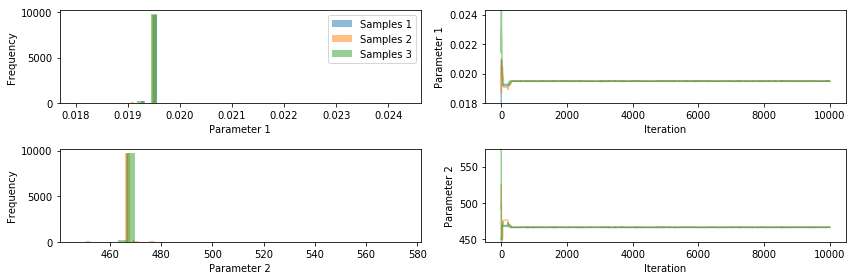

In [36]:
pints.plot.trace(chains_emu)
plt.show()

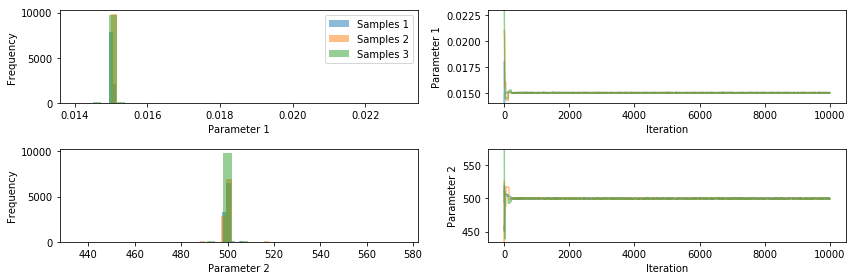

In [37]:
pints.plot.trace(chains)
plt.show()

In [38]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

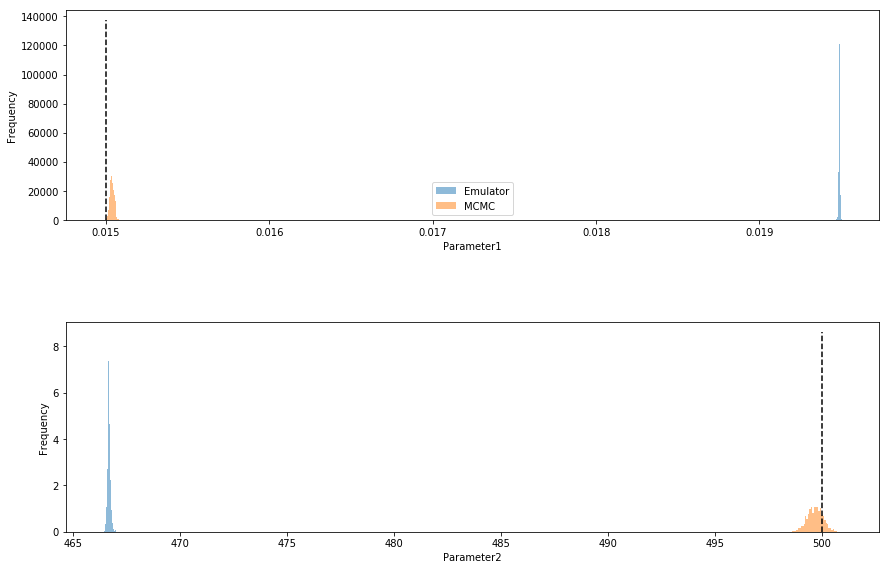

In [39]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

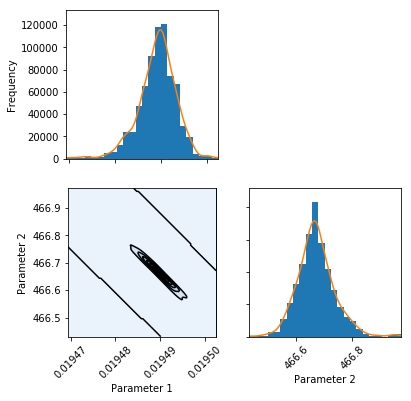

In [40]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

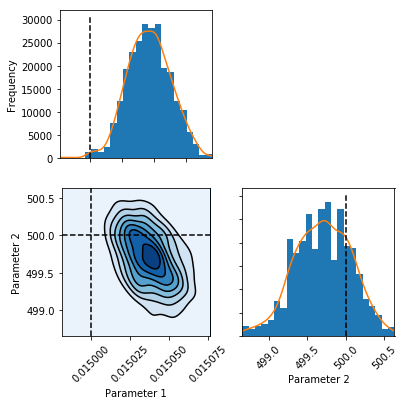

In [41]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

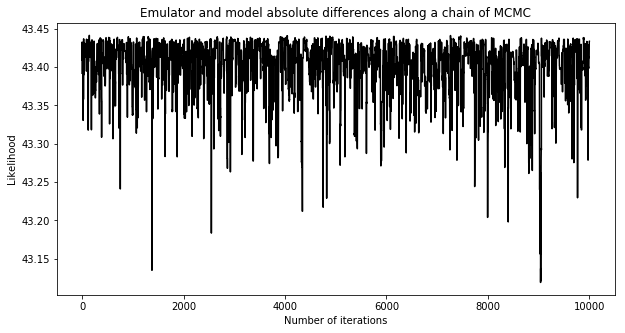

43.433563343476806

In [42]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [43]:
chain_emu

array([[1.94878490e-02, 4.66690634e+02],
       [1.94878490e-02, 4.66690634e+02],
       [1.94878490e-02, 4.66690634e+02],
       ...,
       [1.94802382e-02, 4.66785767e+02],
       [1.94802382e-02, 4.66785767e+02],
       [1.94802382e-02, 4.66785767e+02]])

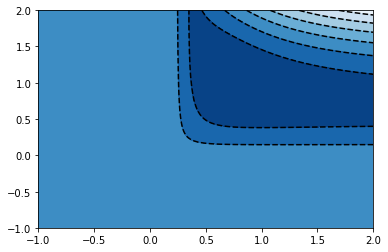

In [44]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

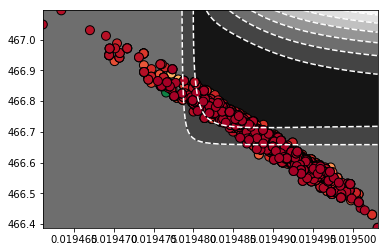

In [45]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.333     0          0:00.0
3     12     0         0.25      0          0:00.0
20    63     0         0.0476    0          0:00.0
40    123    0.0244    0.0244    0          0:00.1
60    183    0.0164    0.0164    0.0328     0:00.1
80    243    0.0123    0.0123    0.0247     0:00.2
100   303    0.0099    0.0099    0.0297     0:00.2
120   363    0.00826   0.00826   0.0248     0:00.2
140   423    0.00709   0.0142    0.0213     0:00.3
160   483    0.00621   0.0186    0.0186     0:00.3
180   543    0.00552   0.0166    0.0166     0:00.4
200   603    0.00498   0.0199    0.0149     0:00.4
220   663    0.00452   0.0181    0.0136     0:00.4
240   723    0.00415   0.0166    0.0124     0:00.5
260   783    0.00383   0.0153    0.0115   

3120  9363   0.000641  0.0032    0.00224    0:06.0
3140  9423   0.000637  0.00318   0.00223    0:06.0
3160  9483   0.000633  0.00316   0.00221    0:06.0
3180  9543   0.000629  0.00314   0.0022     0:06.1
3200  9603   0.000625  0.00312   0.00219    0:06.1
3220  9663   0.000621  0.0031    0.00217    0:06.1
3240  9723   0.000617  0.00309   0.00216    0:06.2
3260  9783   0.000613  0.00307   0.00215    0:06.2
3280  9843   0.00061   0.00305   0.00213    0:06.3
3300  9903   0.000606  0.00303   0.00212    0:06.3
3320  9963   0.000602  0.00301   0.00211    0:06.3
3340  10023  0.000599  0.00299   0.0021     0:06.4
3360  10083  0.000595  0.00298   0.00208    0:06.4
3380  10143  0.000592  0.00296   0.00266    0:06.5
3400  10203  0.000588  0.00294   0.00265    0:06.5
3420  10263  0.000585  0.00292   0.00263    0:06.5
3440  10323  0.000581  0.00291   0.00262    0:06.6
3460  10383  0.000578  0.00289   0.00289    0:06.6
3480  10443  0.000575  0.00287   0.00287    0:06.6
3500  10503  0.000571  0.00286 

6340  19023  0.000946  0.00189   0.00284    0:12.0
6360  19083  0.000943  0.00189   0.00283    0:12.1
6380  19143  0.00094   0.00188   0.00282    0:12.1
6400  19203  0.000937  0.00187   0.00281    0:12.2
6420  19263  0.000934  0.00187   0.0028     0:12.2
6440  19323  0.000932  0.00186   0.00279    0:12.2
6460  19383  0.000929  0.00186   0.00279    0:12.3
6480  19443  0.000926  0.00185   0.00278    0:12.3
6500  19503  0.000923  0.00185   0.00277    0:12.4
6520  19563  0.00092   0.00184   0.00276    0:12.4
6540  19623  0.000917  0.00183   0.00275    0:12.4
6560  19683  0.000914  0.00183   0.00274    0:12.5
6580  19743  0.000912  0.00182   0.00274    0:12.5
6600  19803  0.000909  0.00182   0.00273    0:12.5
6620  19863  0.000906  0.00181   0.00272    0:12.6
6640  19923  0.000903  0.00181   0.00271    0:12.6
6660  19983  0.000901  0.0018    0.0027     0:12.7
6680  20043  0.000898  0.0018    0.00269    0:12.7
6700  20103  0.000895  0.00179   0.00269    0:12.7
6720  20163  0.000893  0.00179 

9580  28743  0.000731  0.00136   0.0023     0:18.2
9600  28803  0.000729  0.00135   0.00229    0:18.2
9620  28863  0.000728  0.00135   0.00229    0:18.2
9640  28923  0.000726  0.00135   0.00228    0:18.3
9660  28983  0.000725  0.00135   0.00228    0:18.3
9680  29043  0.000723  0.00134   0.00227    0:18.4
9700  29103  0.000722  0.00134   0.00227    0:18.4
9720  29163  0.00072   0.00134   0.00226    0:18.4
9740  29223  0.000719  0.00133   0.00226    0:18.5
9760  29283  0.000717  0.00133   0.00225    0:18.5
9780  29343  0.000716  0.00133   0.00225    0:18.5
9800  29403  0.000714  0.00133   0.00224    0:18.6
9820  29463  0.000713  0.00132   0.00224    0:18.6
9840  29523  0.000711  0.00132   0.00224    0:18.7
9860  29583  0.00071   0.00132   0.00223    0:18.7
9880  29643  0.000708  0.00132   0.00233    0:18.7
9900  29703  0.000707  0.00131   0.00232    0:18.8
9920  29763  0.000706  0.00131   0.00232    0:18.8
9940  29823  0.000704  0.00131   0.00231    0:18.8
9960  29883  0.000703  0.00131 

12880 38643  0.000543  0.00109   0.0021     0:24.5
12900 38703  0.000543  0.00109   0.00209    0:24.6
12920 38763  0.000542  0.00108   0.00209    0:24.6
12940 38823  0.000541  0.00108   0.00209    0:24.6
12960 38883  0.00054   0.00108   0.00208    0:24.7
12980 38943  0.000539  0.00108   0.00208    0:24.7
13000 39003  0.000538  0.00108   0.00208    0:24.8
13020 39063  0.000538  0.00108   0.00207    0:24.8
13040 39123  0.000537  0.00107   0.00207    0:24.8
13060 39183  0.000536  0.00107   0.00207    0:24.9
13080 39243  0.000535  0.00107   0.00206    0:24.9
13100 39303  0.000534  0.00107   0.00206    0:24.9
13120 39363  0.000533  0.00107   0.00206    0:25.0
13140 39423  0.000533  0.00107   0.00205    0:25.0
13160 39483  0.000532  0.00106   0.00205    0:25.1
13180 39543  0.000531  0.00106   0.00205    0:25.1
13200 39603  0.00053   0.00106   0.00205    0:25.1
13220 39663  0.000529  0.00106   0.00204    0:25.2
13240 39723  0.000529  0.00106   0.00204    0:25.2
13260 39783  0.000528  0.00106 

16120 48363  0.000496  0.000868  0.00167    0:30.6
16140 48423  0.000496  0.000867  0.00167    0:30.7
16160 48483  0.000495  0.000866  0.00167    0:30.7
16180 48543  0.000494  0.000865  0.00167    0:30.8
16200 48603  0.000494  0.000864  0.00167    0:30.8
16220 48663  0.000493  0.000863  0.00166    0:30.8
16240 48723  0.000493  0.000862  0.00166    0:30.9
16260 48783  0.000492  0.000861  0.00166    0:30.9
16280 48843  0.000491  0.00086   0.00166    0:30.9
16300 48903  0.000491  0.000859  0.00166    0:31.0
16320 48963  0.00049   0.000858  0.00165    0:31.0
16340 49023  0.00049   0.000857  0.00165    0:31.1
16360 49083  0.000489  0.000856  0.00165    0:31.1
16380 49143  0.000488  0.000855  0.00165    0:31.1
16400 49203  0.000488  0.000854  0.00165    0:31.2
16420 49263  0.000487  0.000853  0.00164    0:31.2
16440 49323  0.000487  0.000852  0.00164    0:31.2
16460 49383  0.000486  0.00085   0.00164    0:31.3
16480 49443  0.000485  0.000849  0.00164    0:31.3
16500 49503  0.000485  0.000848

19440 58323  0.000463  0.000772  0.00139    0:37.0
19460 58383  0.000462  0.000771  0.00139    0:37.0
19480 58443  0.000462  0.00077   0.00139    0:37.1
19500 58503  0.000462  0.000769  0.00138    0:37.1
19520 58563  0.000461  0.000768  0.00138    0:37.2
19540 58623  0.000461  0.000768  0.00138    0:37.2
19560 58683  0.00046   0.000767  0.00138    0:37.3
19580 58743  0.00046   0.000766  0.00138    0:37.3
19600 58803  0.000459  0.000765  0.00138    0:37.3
19620 58863  0.000459  0.000764  0.00138    0:37.4
19640 58923  0.000458  0.000764  0.00137    0:37.4
19660 58983  0.000458  0.000763  0.00137    0:37.5
19680 59043  0.000457  0.000762  0.00137    0:37.5
19700 59103  0.000457  0.000761  0.00137    0:37.5
19720 59163  0.000456  0.000761  0.00137    0:37.6
19740 59223  0.000456  0.00076   0.00137    0:37.6
19760 59283  0.000455  0.000759  0.00137    0:37.7
19780 59343  0.000455  0.000758  0.00136    0:37.7
19800 59403  0.000455  0.000758  0.00136    0:37.8
19820 59463  0.000454  0.000757

22760 68283  0.000395  0.000747  0.00119    0:43.6
22780 68343  0.000395  0.000746  0.00119    0:43.6
22800 68403  0.000395  0.000746  0.00118    0:43.6
22820 68463  0.000394  0.000745  0.00118    0:43.7
22840 68523  0.000394  0.000744  0.00118    0:43.7
22860 68583  0.000394  0.000744  0.00118    0:43.7
22880 68643  0.000393  0.000743  0.00118    0:43.8
22900 68703  0.000393  0.000742  0.00118    0:43.8
22920 68763  0.000393  0.000742  0.00118    0:43.9
22940 68823  0.000392  0.000741  0.00118    0:43.9
22960 68883  0.000392  0.00074   0.00118    0:43.9
22980 68943  0.000392  0.00074   0.00117    0:44.0
23000 69003  0.000391  0.000739  0.00117    0:44.0
23020 69063  0.000391  0.000738  0.00117    0:44.1
23040 69123  0.000391  0.000738  0.00117    0:44.1
23060 69183  0.00039   0.000737  0.00117    0:44.1
23080 69243  0.00039   0.000737  0.00117    0:44.2
23100 69303  0.00039   0.000736  0.00117    0:44.2
23120 69363  0.000389  0.000735  0.00117    0:44.2
23140 69423  0.000389  0.000735

26020 78063  0.000346  0.000653  0.00104    0:50.0
26040 78123  0.000346  0.000653  0.00104    0:50.0
26060 78183  0.000345  0.000652  0.00104    0:50.0
26080 78243  0.000345  0.000652  0.00104    0:50.1
26100 78303  0.000345  0.000651  0.00103    0:50.1
26120 78363  0.000345  0.000651  0.00103    0:50.2
26140 78423  0.000344  0.00065   0.00103    0:50.2
26160 78483  0.000344  0.00065   0.00103    0:50.2
26180 78543  0.000344  0.000649  0.00103    0:50.3
26200 78603  0.000343  0.000649  0.00103    0:50.3
26220 78663  0.000343  0.000648  0.00103    0:50.3
26240 78723  0.000343  0.000648  0.00103    0:50.4
26260 78783  0.000343  0.000647  0.00103    0:50.4
26280 78843  0.000342  0.000647  0.00103    0:50.5
26300 78903  0.000342  0.000646  0.00103    0:50.5
26320 78963  0.000342  0.000646  0.00103    0:50.5
26340 79023  0.000342  0.000645  0.00103    0:50.6
26360 79083  0.000341  0.000645  0.00102    0:50.6
26380 79143  0.000341  0.000644  0.00102    0:50.7
26400 79203  0.000341  0.000644

29320 87963  0.000307  0.00058   0.000921   0:56.5
29340 88023  0.000307  0.000579  0.00092    0:56.5
29360 88083  0.000307  0.000579  0.00092    0:56.5
29380 88143  0.000306  0.000579  0.000919   0:56.6
29400 88203  0.000306  0.000578  0.000918   0:56.6
29420 88263  0.000306  0.000578  0.000918   0:56.6
29440 88323  0.000306  0.000577  0.000917   0:56.7
29460 88383  0.000305  0.000577  0.000916   0:56.7
29480 88443  0.000305  0.000577  0.000916   0:56.8
29500 88503  0.000305  0.000576  0.000915   0:56.8
29520 88563  0.000305  0.000576  0.000915   0:56.9
29540 88623  0.000305  0.000575  0.000914   0:56.9
29560 88683  0.000304  0.000575  0.000913   0:56.9
29580 88743  0.000304  0.000575  0.000913   0:57.0
29600 88803  0.000304  0.000574  0.000912   0:57.0
29620 88863  0.000304  0.000574  0.000912   0:57.1
29640 88923  0.000304  0.000574  0.000911   0:57.1
29660 88983  0.000303  0.000573  0.00091    0:57.1
29680 89043  0.000303  0.000573  0.00091    0:57.2
29700 89103  0.000303  0.000572

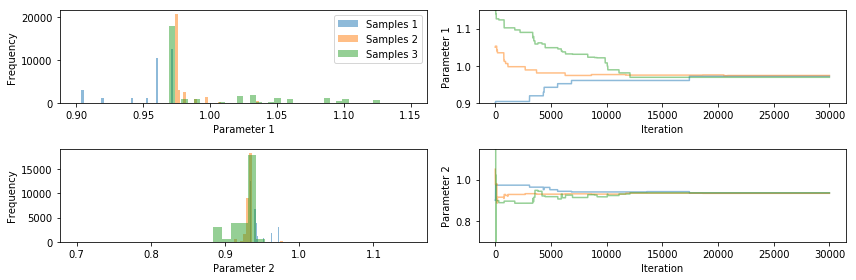

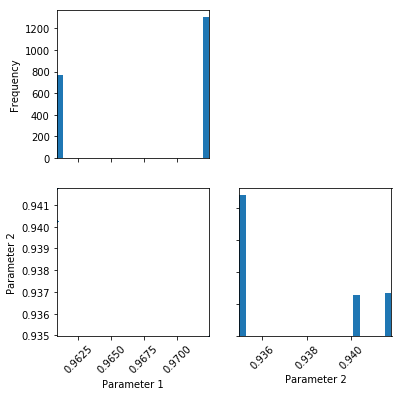

In [65]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-3

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.0
2     9      0.333     0.667     0.667      0:00.0
3     12     0.25      0.5       0.75       0:00.0
20    63     0.0476    0.238     0.333      0:00.0
40    123    0.0732    0.122     0.22       0:00.0
60    183    0.0492    0.0984    0.18       0:00.0
80    243    0.037     0.0741    0.136      0:00.1
100   303    0.0396    0.0594    0.109      0:00.1
120   363    0.0413    0.0496    0.0909     0:00.1
140   423    0.0496    0.0426    0.078      0:00.1
160   483    0.0497    0.0373    0.0683     0:00.1
180   543    0.0442    0.0387    0.0663     0:00.1
200   603    0.039801  0.039801  0.0647     0:00.1
220   663    0.0362    0.0407    0.0588     0:00.2
240   723    0.0373    0.0456    0.0539     0:00.2
260   783    0.046     0.0421    0.0498

3180  9543   0.0302    0.033     0.038      0:02.2
3200  9603   0.0306    0.0331    0.0378     0:02.2
3220  9663   0.0304    0.0335    0.0379     0:02.2
3240  9723   0.0305    0.0333    0.0383     0:02.2
3260  9783   0.031     0.0334    0.0386     0:02.2
3280  9843   0.0311    0.0332    0.0387     0:02.2
3300  9903   0.0309    0.0336    0.0391     0:02.2
3320  9963   0.0307    0.0334    0.0388     0:02.3
3340  10023  0.0305    0.0332    0.0389     0:02.3
3360  10083  0.0306    0.0333    0.0387     0:02.3
3380  10143  0.0305    0.0337    0.039      0:02.3
3400  10203  0.0306    0.0335    0.0388     0:02.3
3420  10263  0.031     0.0336    0.0389     0:02.3
3440  10323  0.0311    0.034     0.0389     0:02.3
3460  10383  0.0309    0.0338    0.0396     0:02.4
3480  10443  0.0307    0.0339    0.0396     0:02.4
3500  10503  0.0306    0.0343    0.0397     0:02.4
3520  10563  0.0304    0.0341    0.0395     0:02.4
3540  10623  0.0302    0.0345    0.0393     0:02.4
3560  10683  0.03      0.0345  

6500  19503  0.0289    0.0346    0.0358     0:04.4
6520  19563  0.0288    0.0345    0.0357     0:04.4
6540  19623  0.0287    0.0344    0.0358     0:04.5
6560  19683  0.0287    0.0343    0.0358     0:04.5
6580  19743  0.0286    0.0343    0.0357     0:04.5
6600  19803  0.0285    0.0342    0.0358     0:04.5
6620  19863  0.0284    0.0341    0.0358     0:04.5
6640  19923  0.0283    0.034     0.0358     0:04.5
6660  19983  0.0284    0.0339    0.0357     0:04.5
6680  20043  0.0283    0.034     0.0358     0:04.5
6700  20103  0.0284    0.0339    0.0358     0:04.6
6720  20163  0.0283    0.0339    0.0359     0:04.6
6740  20223  0.0282    0.0341    0.036      0:04.6
6760  20283  0.0281    0.034     0.0359     0:04.6
6780  20343  0.0282    0.0342    0.0358     0:04.6
6800  20403  0.0281    0.0341    0.0362     0:04.6
6820  20463  0.028     0.0342    0.0361     0:04.6
6840  20523  0.0279    0.0341    0.0361     0:04.7
6860  20583  0.028     0.0341    0.0363     0:04.7
6880  20643  0.0279    0.0343  

9800  29403  0.023     0.0343    0.0349     0:06.7
9820  29463  0.0229    0.0342    0.0349     0:06.7
9840  29523  0.0229    0.0341    0.0349     0:06.7
9860  29583  0.0228    0.0342    0.0349     0:06.7
9880  29643  0.0228    0.0341    0.035      0:06.7
9900  29703  0.0228    0.0341    0.0349     0:06.7
9920  29763  0.0228    0.0343    0.0349     0:06.7
9940  29823  0.0227    0.0342    0.0348     0:06.8
9960  29883  0.0227    0.0341    0.0348     0:06.8
9980  29943  0.0226    0.0342    0.0349     0:06.8
10000 30003  0.0226    0.0341    0.0348     0:06.8
10020 30063  0.0226    0.0341    0.0347     0:06.8
10040 30123  0.0225    0.0342    0.0349     0:06.8
10060 30183  0.0225    0.0341    0.0348     0:06.8
10080 30243  0.0224    0.034     0.0347     0:06.8
10100 30303  0.0224    0.034     0.0347     0:06.9
10120 30363  0.0223    0.0341    0.0346     0:06.9
10140 30423  0.0223    0.034     0.0347     0:06.9
10160 30483  0.0222    0.034     0.0348     0:06.9
10180 30543  0.0222    0.0339  

13020 39063  0.0177    0.0309    0.0332     0:08.8
13040 39123  0.0177    0.0309    0.0332     0:08.8
13060 39183  0.0177    0.0309    0.0332     0:08.9
13080 39243  0.0177    0.0309    0.0331     0:08.9
13100 39303  0.0176    0.03099   0.0331     0:08.9
13120 39363  0.0176    0.0309    0.0331     0:08.9
13140 39423  0.0176    0.0309    0.0331     0:08.9
13160 39483  0.0176    0.0308    0.0331     0:08.9
13180 39543  0.0176    0.0309    0.033      0:08.9
13200 39603  0.0176    0.030831  0.033      0:09.0
13220 39663  0.0175    0.0308    0.0329     0:09.0
13240 39723  0.0175    0.0307    0.0329     0:09.0
13260 39783  0.0175    0.0307    0.0328     0:09.0
13280 39843  0.0175    0.0306    0.0328     0:09.0
13300 39903  0.0174    0.0306    0.0329     0:09.0
13320 39963  0.0174    0.0306    0.0329     0:09.0
13340 40023  0.01739   0.0305    0.033      0:09.0
13360 40083  0.0174    0.0305    0.0329     0:09.1
13380 40143  0.0173    0.0304    0.033      0:09.1
13400 40203  0.0173    0.0304  

16340 49023  0.0149    0.0263    0.0313     0:11.1
16360 49083  0.0149    0.0262    0.0313     0:11.1
16380 49143  0.0149    0.0262    0.0313     0:11.1
16400 49203  0.0149    0.0262    0.0312     0:11.1
16420 49263  0.0149    0.0262    0.0312     0:11.1
16440 49323  0.0148    0.0262    0.0311     0:11.1
16460 49383  0.0148    0.0261    0.0311     0:11.1
16480 49443  0.0148    0.0261    0.0311     0:11.2
16500 49503  0.0148    0.0261    0.0311     0:11.2
16520 49563  0.0148    0.0261    0.0311     0:11.2
16540 49623  0.0148    0.0261    0.0311     0:11.2
16560 49683  0.0147    0.026025  0.0311     0:11.2
16580 49743  0.0147    0.0261    0.0312     0:11.2
16600 49803  0.0147    0.026     0.0313     0:11.2
16620 49863  0.0147    0.026     0.0313     0:11.3
16640 49923  0.0147    0.026     0.0312     0:11.3
16660 49983  0.0146    0.0259    0.0312     0:11.3
16680 50043  0.0146    0.0259    0.0312     0:11.3
16700 50103  0.0146    0.0259    0.0312     0:11.3
16720 50163  0.0146    0.0258  

19700 59103  0.0131    0.0225    0.0284     0:13.3
19720 59163  0.0131    0.0225    0.0284     0:13.4
19740 59223  0.0131    0.0224    0.0284     0:13.4
19760 59283  0.0131    0.0224    0.0284     0:13.4
19780 59343  0.0131    0.0224    0.0284     0:13.4
19800 59403  0.0131    0.0224    0.0283     0:13.4
19820 59463  0.0131    0.0224    0.0283     0:13.4
19840 59523  0.0131    0.0223    0.0283     0:13.4
19860 59583  0.013     0.0223    0.0282     0:13.4
19880 59643  0.013     0.0223    0.0283     0:13.5
19900 59703  0.013     0.0223    0.0282     0:13.5
19920 59763  0.013     0.0222    0.0282     0:13.5
19940 59823  0.013     0.0222    0.0282     0:13.5
19960 59883  0.013     0.0222    0.0282     0:13.5
19980 59943  0.013     0.0222    0.0282     0:13.5
20000 60003  0.0129    0.0222    0.0282     0:13.5
20020 60063  0.0129    0.0222    0.0282     0:13.6
20040 60123  0.013     0.0222    0.028292   0:13.6
20060 60183  0.013     0.0222    0.0283     0:13.6
20080 60243  0.0129    0.0222  

23120 69363  0.0118    0.0199    0.0255     0:15.6
23140 69423  0.0118    0.0199    0.0255     0:15.7
23160 69483  0.0117    0.0199    0.0255     0:15.7
23180 69543  0.0117    0.0199    0.0255     0:15.7
23200 69603  0.0118    0.0199    0.0254     0:15.7
23220 69663  0.0118    0.0199    0.0255     0:15.7
23240 69723  0.0118    0.0198    0.0254     0:15.7
23260 69783  0.0118    0.0198    0.0254     0:15.7
23280 69843  0.0118    0.0198    0.0254     0:15.7
23300 69903  0.0118    0.0198    0.0254     0:15.8
23320 69963  0.0118    0.0198    0.0253     0:15.8
23340 70023  0.0118    0.0198    0.0253     0:15.8
23360 70083  0.0118    0.0198    0.0253     0:15.8
23380 70143  0.0118    0.0198    0.0253     0:15.8
23400 70203  0.0118    0.0197    0.0253     0:15.8
23420 70263  0.0117    0.0197    0.0252     0:15.8
23440 70323  0.0117    0.0197    0.0252     0:15.9
23460 70383  0.0118    0.0197    0.0252     0:15.9
23480 70443  0.0118    0.0197    0.0252     0:15.9
23500 70503  0.0117    0.0197  

26400 79203  0.0107    0.0178    0.023      0:17.8
26420 79263  0.0107    0.0178    0.023      0:17.9
26440 79323  0.0107    0.0178    0.023      0:17.9
26460 79383  0.0107    0.0178    0.023      0:17.9
26480 79443  0.0106    0.0177    0.023      0:17.9
26500 79503  0.0106    0.0177    0.0229     0:17.9
26520 79563  0.0106    0.0177    0.0229     0:17.9
26540 79623  0.0106    0.0177    0.0229     0:17.9
26560 79683  0.0106    0.0177    0.0229     0:18.0
26580 79743  0.0106    0.0177    0.0229     0:18.0
26600 79803  0.0106    0.0177    0.0229     0:18.0
26620 79863  0.0106    0.0177    0.0228     0:18.0
26640 79923  0.0106    0.0176    0.0228     0:18.0
26660 79983  0.0106    0.0176    0.0228     0:18.0
26680 80043  0.0106    0.0176    0.0228     0:18.0
26700 80103  0.0106    0.0176    0.0228     0:18.0
26720 80163  0.0106    0.0176    0.0228     0:18.1
26740 80223  0.010583  0.0176    0.0227     0:18.1
26760 80283  0.0106    0.0176    0.0227     0:18.1
26780 80343  0.0106    0.0175  

29640 88923  0.00995   0.0161    0.0207     0:20.0
29660 88983  0.00995   0.0161    0.0207     0:20.0
29680 89043  0.00994   0.0161    0.0207     0:20.0
29700 89103  0.00993   0.0161    0.0207     0:20.1
29720 89163  0.00993   0.0161    0.0207     0:20.1
29740 89223  0.00992   0.0161    0.0207     0:20.1
29760 89283  0.00991   0.0161    0.0207     0:20.1
29780 89343  0.00991   0.0161    0.0207     0:20.1
29800 89403  0.00993   0.0161    0.0206     0:20.1
29820 89463  0.00993   0.0161    0.0206     0:20.1
29840 89523  0.00992   0.0161    0.0206     0:20.2
29860 89583  0.00991   0.0161    0.0206     0:20.2
29880 89643  0.00991   0.0161    0.0206     0:20.2
29900 89703  0.0099    0.0161    0.0206     0:20.2
29920 89763  0.00989   0.0161    0.0206     0:20.2
29940 89823  0.00989   0.0161    0.0206     0:20.2
29960 89883  0.00988   0.0161    0.0206     0:20.2
29980 89943  0.00987   0.016     0.0206     0:20.2
30000 90000  0.00987   0.016     0.0206     0:20.3
Halting: Maximum number of iter

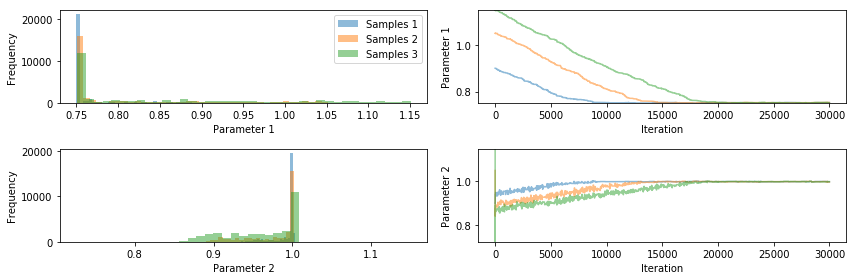

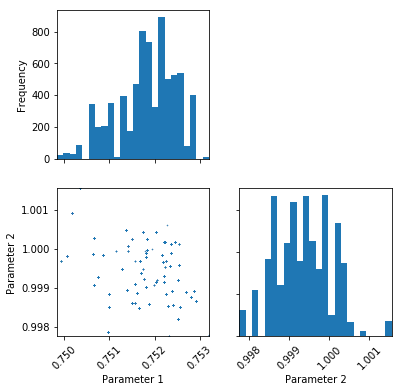

In [62]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [66]:
metropolis_chains.shape

(3, 30000, 2)

In [67]:
metropolis_chains[0][:10]

array([[0.9       , 0.9       ],
       [0.9       , 0.9       ],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463],
       [0.90013681, 0.94070463]])

In [68]:
emulated_chains[0][:10]

array([[0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9]])

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.0
2     9      0.333     0.667     0.667      0:00.0
3     12     0.25      0.75      0.75       0:00.0
20    63     0.381     0.524     0.619      0:00.0
40    123    0.439     0.537     0.61       0:00.0
60    183    0.492     0.59      0.639      0:00.0
80    243    0.531     0.556     0.617284   0:00.1
100   303    0.525     0.535     0.545      0:00.1
120   363    0.553719  0.521     0.562      0:00.1
140   423    0.574     0.525     0.553      0:00.1
160   483    0.565     0.509     0.547      0:00.1
180   543    0.564     0.525     0.53       0:00.1
200   603    0.552     0.542     0.517      0:00.1
220   663    0.538     0.538     0.516      0:00.2
240   723    0.535     0.523     0.498      0:00.2
260   783    0.536     0.517     0.517 

3240  9723   0.825     0.673     0.534      0:02.2
3260  9783   0.825     0.674     0.536      0:02.2
3280  9843   0.826     0.675     0.536      0:02.2
3300  9903   0.826     0.676     0.538      0:02.2
3320  9963   0.826     0.677     0.54       0:02.2
3340  10023  0.826     0.679     0.540856   0:02.2
3360  10083  0.827     0.68      0.542      0:02.3
3380  10143  0.828     0.68      0.545      0:02.3
3400  10203  0.828     0.68      0.546      0:02.3
3420  10263  0.828     0.68      0.548      0:02.3
3440  10323  0.828     0.682     0.55       0:02.3
3460  10383  0.828     0.682     0.552      0:02.3
3480  10443  0.829     0.683     0.553002   0:02.3
3500  10503  0.829     0.684     0.555      0:02.3
3520  10563  0.829     0.686     0.558      0:02.4
3540  10623  0.83      0.687     0.559      0:02.4
3560  10683  0.83      0.687     0.56       0:02.4
3580  10743  0.83      0.688     0.562      0:02.4
3600  10803  0.831     0.689     0.563      0:02.4
3620  10863  0.831     0.689   

6520  19563  0.844     0.761     0.69       0:04.4
6540  19623  0.844     0.761963  0.69       0:04.4
6560  19683  0.844     0.762     0.691      0:04.4
6580  19743  0.844     0.762     0.691      0:04.4
6600  19803  0.844266  0.762     0.691      0:04.4
6620  19863  0.845     0.762     0.692      0:04.5
6640  19923  0.844     0.763     0.692      0:04.5
6660  19983  0.844     0.763     0.693      0:04.5
6680  20043  0.844     0.763     0.693      0:04.5
6700  20103  0.844     0.763     0.694      0:04.5
6720  20163  0.844     0.764     0.694      0:04.5
6740  20223  0.84305   0.764     0.694259   0:04.5
6760  20283  0.843     0.764384  0.695      0:04.6
6780  20343  0.843     0.765     0.695      0:04.6
6800  20403  0.843     0.765     0.695      0:04.6
6820  20463  0.843     0.765     0.696      0:04.6
6840  20523  0.843     0.765     0.696      0:04.6
6860  20583  0.843     0.766     0.696      0:04.6
6880  20643  0.843     0.766     0.697      0:04.6
6900  20703  0.843356  0.766   

9820  29463  0.846     0.787     0.743407   0:06.6
9840  29523  0.846     0.787     0.743522   0:06.6
9860  29583  0.846     0.787     0.743738   0:06.6
9880  29643  0.846     0.787     0.743953   0:06.7
9900  29703  0.846     0.787     0.744      0:06.7
9920  29763  0.846     0.788     0.743      0:06.7
9940  29823  0.846     0.788     0.744      0:06.7
9960  29883  0.847     0.788     0.744102   0:06.7
9980  29943  0.847     0.788398  0.744      0:06.7
10000 30003  0.847     0.788     0.745      0:06.7
10020 30063  0.847     0.788     0.745      0:06.7
10040 30123  0.847     0.789     0.745      0:06.8
10060 30183  0.847     0.789     0.745254   0:06.8
10080 30243  0.847     0.789     0.745561   0:06.8
10100 30303  0.847     0.789     0.746      0:06.8
10120 30363  0.847     0.789     0.746      0:06.8
10140 30423  0.847     0.789     0.746      0:06.8
10160 30483  0.847     0.789194  0.746      0:06.8
10180 30543  0.847     0.789     0.746685   0:06.9
10200 30603  0.847     0.79    

13140 39423  0.85      0.803     0.767      0:08.8
13160 39483  0.85      0.803     0.767      0:08.8
13180 39543  0.85      0.803     0.768      0:08.9
13200 39603  0.85      0.803     0.768      0:08.9
13220 39663  0.85      0.803     0.768      0:08.9
13240 39723  0.85      0.802885  0.768      0:08.9
13260 39783  0.85      0.803     0.768      0:08.9
13280 39843  0.85      0.803     0.768      0:08.9
13300 39903  0.85      0.803     0.769      0:08.9
13320 39963  0.849711  0.803243  0.768      0:09.0
13340 40023  0.85      0.803     0.769      0:09.0
13360 40083  0.85      0.803     0.769      0:09.0
13380 40143  0.85      0.803     0.769      0:09.0
13400 40203  0.85      0.803     0.769      0:09.0
13420 40263  0.85      0.803     0.769      0:09.0
13440 40323  0.849788  0.803     0.769288   0:09.0
13460 40383  0.85      0.803     0.77       0:09.1
13480 40443  0.85      0.803     0.77       0:09.1
13500 40503  0.849863  0.803     0.77       0:09.1
13520 40563  0.85      0.803195

16380 49143  0.851     0.812     0.783896   0:11.0
16400 49203  0.851     0.813     0.784      0:11.0
16420 49263  0.851     0.813     0.784      0:11.0
16440 49323  0.851     0.813     0.784      0:11.1
16460 49383  0.851     0.813     0.784278   0:11.1
16480 49443  0.851     0.812     0.784115   0:11.1
16500 49503  0.851     0.812     0.784      0:11.1
16520 49563  0.851     0.813     0.784      0:11.1
16540 49623  0.851     0.813     0.784      0:11.1
16560 49683  0.851     0.812934  0.785      0:11.1
16580 49743  0.851     0.813     0.785      0:11.1
16600 49803  0.851     0.813     0.785      0:11.2
16620 49863  0.851     0.813128  0.78467    0:11.2
16640 49923  0.85      0.813     0.785      0:11.2
16660 49983  0.85      0.813     0.785      0:11.2
16680 50043  0.85      0.813     0.785      0:11.2
16700 50103  0.85      0.813     0.785      0:11.2
16720 50163  0.85      0.813     0.785      0:11.2
16740 50223  0.85      0.813     0.785      0:11.3
16760 50283  0.85      0.813   

19700 59103  0.852     0.819     0.795      0:13.3
19720 59163  0.852     0.819     0.795      0:13.3
19740 59223  0.852     0.819     0.795      0:13.3
19760 59283  0.852     0.819     0.796      0:13.3
19780 59343  0.852     0.819     0.796      0:13.3
19800 59403  0.852     0.819     0.796      0:13.3
19820 59463  0.852     0.819     0.796      0:13.3
19840 59523  0.852     0.819     0.796      0:13.3
19860 59583  0.852     0.819     0.796      0:13.4
19880 59643  0.852     0.819     0.796      0:13.4
19900 59703  0.852     0.819     0.796      0:13.4
19920 59763  0.852     0.819     0.796      0:13.4
19940 59823  0.852     0.819     0.796      0:13.4
19960 59883  0.852     0.819     0.796      0:13.4
19980 59943  0.852     0.818978  0.796      0:13.4
20000 60003  0.852     0.819     0.796      0:13.5
20020 60063  0.852405  0.819     0.796      0:13.5
20040 60123  0.852     0.819021  0.796      0:13.5
20060 60183  0.852     0.819     0.796      0:13.5
20080 60243  0.852     0.819   

22980 68943  0.853     0.823     0.803      0:15.5
23000 69003  0.853     0.823     0.803      0:15.5
23020 69063  0.853     0.823     0.803      0:15.5
23040 69123  0.853305  0.823     0.803      0:15.5
23060 69183  0.853     0.823     0.803      0:15.5
23080 69243  0.853     0.822798  0.803      0:15.5
23100 69303  0.853     0.823     0.802909   0:15.5
23120 69363  0.853     0.823018  0.803      0:15.6
23140 69423  0.853     0.823     0.803      0:15.6
23160 69483  0.853     0.823     0.803031   0:15.6
23180 69543  0.854     0.823     0.803      0:15.6
23200 69603  0.853     0.823068  0.803      0:15.6
23220 69663  0.853     0.823     0.803      0:15.6
23240 69723  0.853     0.823     0.803      0:15.6
23260 69783  0.853     0.823     0.803      0:15.7
23280 69843  0.853     0.823     0.803      0:15.7
23300 69903  0.853     0.823     0.803      0:15.7
23320 69963  0.853     0.823     0.803      0:15.7
23340 70023  0.853     0.823     0.803436   0:15.7
23360 70083  0.853     0.823   

26340 79023  0.854     0.827     0.81       0:17.7
26360 79083  0.854     0.826     0.81       0:17.7
26380 79143  0.854     0.826466  0.81       0:17.8
26400 79203  0.853604  0.827     0.81       0:17.8
26420 79263  0.854     0.827     0.81       0:17.8
26440 79323  0.854     0.827     0.81       0:17.8
26460 79383  0.854     0.827     0.81       0:17.8
26480 79443  0.854     0.827     0.809977   0:17.8
26500 79503  0.854     0.827     0.81       0:17.8
26520 79563  0.854     0.827005  0.810075   0:17.9
26540 79623  0.854     0.827     0.81       0:17.9
26560 79683  0.854     0.827     0.81       0:17.9
26580 79743  0.854     0.827     0.81       0:17.9
26600 79803  0.854     0.827     0.809932   0:17.9
26620 79863  0.854     0.827129  0.81       0:17.9
26640 79923  0.854     0.827     0.81       0:17.9
26660 79983  0.854     0.827     0.81       0:17.9
26680 80043  0.854     0.827     0.810202   0:18.0
26700 80103  0.854     0.82716   0.81       0:18.0
26720 80163  0.854     0.827252

29660 88983  0.854     0.829473  0.815      0:20.0
29680 89043  0.854     0.829     0.815      0:20.0
29700 89103  0.854     0.829467  0.815      0:20.0
29720 89163  0.854     0.829     0.815      0:20.0
29740 89223  0.854     0.829     0.815      0:20.0
29760 89283  0.85397   0.829     0.815      0:20.0
29780 89343  0.854     0.829     0.815      0:20.0
29800 89403  0.854     0.829     0.815      0:20.1
29820 89463  0.854     0.829     0.815      0:20.1
29840 89523  0.854     0.829     0.815      0:20.1
29860 89583  0.854     0.83      0.81511    0:20.1
29880 89643  0.854     0.83      0.815      0:20.1
29900 89703  0.854     0.83      0.815      0:20.1
29920 89763  0.854     0.83      0.815      0:20.1
29940 89823  0.854     0.83      0.815      0:20.2
29960 89883  0.854     0.83      0.815      0:20.2
29980 89943  0.854     0.83      0.815      0:20.2
30000 90000  0.854     0.83      0.815      0:20.2
Halting: Maximum number of iterations (30000) reached.
Done!
R-hat:
[308.148614547

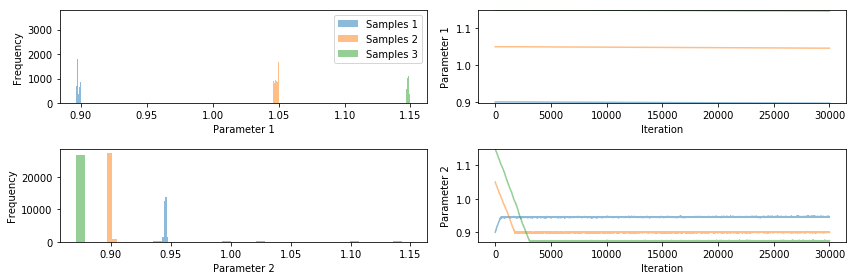

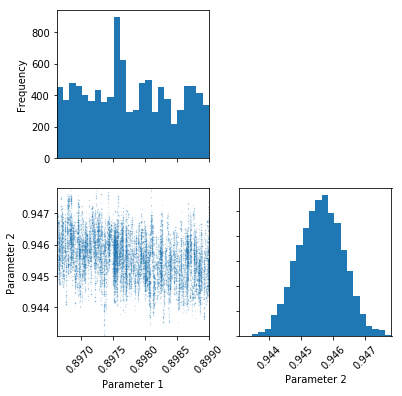

In [69]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 1e-10

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()